In [1]:
import os
import numpy as np
np.set_printoptions(precision=4, suppress=True)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Helvetica'
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import seaborn as sns
sns.set(palette='husl')
sns.set_context('paper')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib import layers as tf_layers
from tensorflow_probability import distributions as tfp

from scipy import stats
from sklearn import preprocessing
from datetime import datetime

seed = 11
np.random.seed(seed)
tf.set_random_seed(seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [2]:
n_trials = 50
n_epochs_decoder = 100
n_epochs_encoder = 10
n_epochs_cvae_real = 10
batch_size_sim = 512
# Use low batch size for real data since we don't have many samples
batch_size_real = 1
dropout_rate = 0.0
param_noise = 0.
PREPROCESS = False
shuffle = True

# Number of simulation episodes to collect
n_episodes = 1000
# Cartpole environment is 200 steps
ep_len = 200
# Number of training trajectories to use
n_train_trajs = 20

In [3]:
# Our environment-related code
from envs.cartpole.update_env import *
from envs.cartpole import data_generator

In [4]:
# Could be anything
param_names = ['length', 'masspole']

# Generate "real" data

In [5]:
# REAL PARAMETERS

# BayesSim uses 1,1 / 1.75, 1.0 / 0.7, 1.3
length, masspole  = 1.75, 1.0

In [6]:
# Use some extra "real" episodes for evaluation
n_episodes = 300

filepath = 'envs/cartpole/data/real-cartpole-masspole{}-length{}-ep{}.npy'.format(masspole, length, n_episodes)
try:
    with open(filepath, 'rb') as f:
        real_data = np.load(f, allow_pickle=True).item()
except:
    real_params = lambda: [length, masspole]
    real_data = data_generator.generate(real_params, env_update_fn=update_env,
                                        num_episodes=n_episodes, filepath=filepath)

# Generate sim data

In [7]:
# Uniform or Gaussian
UNIFORM = True

if UNIFORM:
    length_lo, length_hi = 0.1, 2.0
    masspole_lo, masspole_hi = 0.1, 2.0
    filepath = 'envs/cartpole/data/cartpole_masspole{}-{}_length{}-{}_ep{}.npy'.format(masspole_lo, masspole_hi, length_lo, length_hi, n_episodes)
    init_sim_params = lambda: [np.random.uniform(length_lo, length_hi), np.random.uniform(masspole_lo, masspole_hi)]
else:
    # means = whatever you received in previous iteration
    # stddevs = whatever you received in previous iteration
    filepath = 'envs/cartpole/data/cartpole_masspole{}-{}_length{}-{}_ep{}.npy'.format(means[0], stddevs[0], means[1], stddevs[1], n_episodes)
    init_sim_params = lambda: [np.random.normal(means[0], stddevs[0]), np.random.uniform(means[1], stddevs[1])]
try:
    with open(filepath, 'rb') as f:
        data = np.load(f, allow_pickle=True).item()
except:
    data = data_generator.generate(init_sim_params, env_update_fn=update_env,
                                   num_episodes=n_episodes, filepath=filepath)

In [8]:
def extract_data(data):
    states, actions, next_states, params = [np.float32(data[key]) for key in ['states', 'actions', 'next_states', 'parameters']]
    data_size = len(states)

    next_states = next_states - states
    states = np.hstack([states, actions])

    return states, actions, next_states, params

def normalize_params(params):
    param_scaler = preprocessing.StandardScaler()
    params = param_scaler.fit_transform(params)
    return params, param_scaler

states, actions, next_states, params = extract_data(data)
params_orig = params.copy()
params, param_scaler = normalize_params(params)

real_states, real_actions, real_next_states, real_params = extract_data(real_data)
print('sim params mean: ', params.mean(0), 'std: ', params.std(0))
print('real params mean: ', real_params.mean(0), 'std: ', real_params.std(0))

sim params mean:  [-0.  0.] std:  [1.     0.9999]
real params mean:  [1.75 1.  ] std:  [0. 0.]


In [9]:
n_actions = actions.shape[-1]
n_states = n_outputs = next_states.shape[-1]
mixture_components = 5
n_params = len(params[0])
n_conditions = n_states + n_actions
n_codings = n_params
n_units = 32
dim_hidden= [n_units]*3
norm = 'layer_norm'

print('n_states: ', n_states)
print('n_actions: ', n_actions)
print('n_params: ', n_params)

n_states:  4
n_actions:  1
n_params:  2


# Split into training/test/validation

In [10]:
n_data = len(states)
split = int(n_data * 0.8)

states_train, states_test = states[:split], states[split:]
next_states_train, next_states_test = next_states[:split], next_states[split:]
params_train, params_test = params[:split], params[split:]

trajs = n_train_trajs*2
train_trajs = n_train_trajs*ep_len
split = trajs*ep_len

real_states_train, real_states_test = real_states[:split], real_states[split:]
real_states_train, real_states_val = real_states_train[:train_trajs], real_states_train[train_trajs:]

real_next_states_train, real_next_states_test = real_next_states[:split], real_next_states[split:]
real_next_states_train, real_next_states_val = real_next_states_train[:train_trajs], real_next_states_train[train_trajs:]

real_params_train, real_params_test = real_params[:split], real_params[split:]
real_params_train, real_params_val = real_params_train[:train_trajs], real_params_train[train_trajs:]

print('Number of real train samples:', len(real_states_train))
print('Number of real val samples:', len(real_states_val))
print('Number of real test samples:', len(real_states_test))

Number of real train samples: 4000
Number of real val samples: 4000
Number of real test samples: 93908


In [11]:
n_batches_sim = len(states_train) // batch_size_sim
n_batches_sim_test = len(states_test) // batch_size_sim
n_batches_real = len(real_states_train) // batch_size_real
n_batches_real_val = len(real_states_val) // batch_size_real
n_batches_real_test = len(real_states_test) // batch_size_real

In [12]:
def add_noise(s, ns, p, param_noise=param_noise):
    ''' Adds param_noise noise to params '''
    return s, ns, p + tf.random_normal(shape=tf.shape(p), mean=0, stddev=param_noise)

# Create TensorFlow iterators

In [13]:
tf.reset_default_graph()

def dataset_from_tensor_slices(slices):
    dataset = tf.data.Dataset.from_tensor_slices(tensor_slices).shuffle(len(states_train))
    dataset = dataset.repeat().batch(BATCH_SIZE).map(add_noise)
    dataset = dataset.prefetch(BATCH_SIZE)
    return dataset

BATCH_SIZE = tf.placeholder(tf.int64, name='batch_size')

tensor_slices = (states_train, next_states_train, params_train)
dataset = dataset_from_tensor_slices(tensor_slices)

tensor_slices = (states_test, next_states_test, params_test)
test_dataset = tf.data.Dataset.from_tensor_slices(tensor_slices).shuffle(len(states_test))
test_dataset = test_dataset.repeat().batch(BATCH_SIZE)

tensor_slices = (real_states_train, real_next_states_train, real_params_train)
real_dataset = tf.data.Dataset.from_tensor_slices(tensor_slices).shuffle(len(real_states_train))
real_dataset = real_dataset.repeat().batch(BATCH_SIZE)

tensor_slices = (real_states_val, real_next_states_val, real_params_val)
real_dataset_val = tf.data.Dataset.from_tensor_slices(tensor_slices).shuffle(len(real_states_val))
real_dataset_val = real_dataset_val.repeat().batch(BATCH_SIZE)

tensor_slices = (real_states_test, real_next_states_test, real_params_test)
real_dataset_test = tf.data.Dataset.from_tensor_slices(tensor_slices).shuffle(len(real_states_test))
real_dataset_test = real_dataset_test.repeat().batch(BATCH_SIZE)

it = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)

sim_init_op = it.make_initializer(dataset)
sim_test_init_op = it.make_initializer(test_dataset)
real_init_op = it.make_initializer(real_dataset)
real_val_init_op = it.make_initializer(real_dataset_val)
real_test_init_op = it.make_initializer(real_dataset_test)

X, Y, Z = it.get_next()

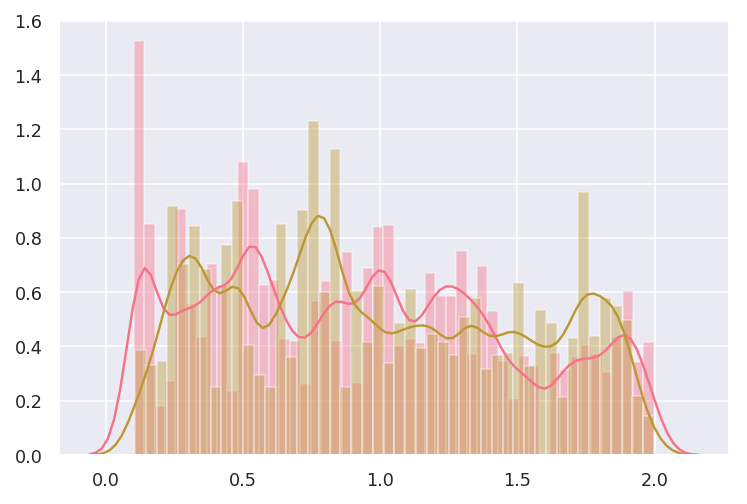

In [14]:
for i in range(n_params):
    sns.distplot(params_orig[:,i])

In [15]:
def ll_func(x, mu, logvar):
    const = logvar + np.log(2*np.pi)
    diff = (x-mu)**2/np.exp(logvar)
    return -0.5*(diff + const)

# Plot functions

In [16]:
''' 
Returns denormalized (actual) means / stddevs for parameters
'''
def get_results(plot_orig=False):

    x, y = real_states_test, real_next_states_test

    sess.run(real_test_init_op, {BATCH_SIZE: len(x)})
    
    # Probability of Y given prior
    logprob = cvae.log_prob(Y)
    logprob = tf.reduce_mean(logprob)
    results = sess.run(logprob, feed_dict={X: x, Y: y})
    #results /= len(x)
    print('Results with prior:', results)

    results = sess.run(cvae_ll, feed_dict={X: x, Y: y})
    print('Results with E[prior]:', results)
    
    feed_dict = {X: np.vstack([real_states_train, real_states_val]), Y: np.vstack([real_next_states_train, real_next_states_val])}
    posterior_samples, posterior_mean, posterior_std, posterior_var = sess.run([posterior.sample(), posterior.mean(),
                                                                                posterior.stddev(), posterior.variance()], feed_dict)

    # Probability of Y given samples from posterior
    loc, scale = posterior_samples.mean(axis=0), posterior_samples.std(axis=0)
    priors = tfp.MultivariateNormalDiag(loc, scale).sample(len(x))
    logprob = decoder_forward(priors, X, d_weights, reuse=True).log_prob(Y)
    logprob = tf.reduce_mean(logprob)
    results = sess.run(logprob, feed_dict={X: x, Y: y})
    #results /= len(x)
    print('Results with phi:', results)

    # Probability of Y given mean of posterior
    posterior_mean = posterior_mean.mean(axis=0)
    posterior_var = posterior_var.mean(axis=0)
    posterior_mean_repeat = tf.reshape(tf.tile(posterior_mean, [tf.shape(X)[0]]), [tf.shape(X)[0], -1])

    logprob = decoder_forward(posterior_mean_repeat, X, d_weights, reuse=True).log_prob(Y)
    logprob = tf.reduce_mean(logprob)
    results = sess.run(logprob, feed_dict={X: x, Y: y})
    #results /= len(x)
    print('Results with phi (expected):', results)

    # Learned params by denormalizing samples from posterior given "real" data
    learned_params = denormalize_params(posterior_samples)
    
    print('****************')
    print('Learned params: ', ', '.join(map(str, learned_params.mean(0))))
    print('Learned std: ', ', '.join(map(str, learned_params.std(0))))
    print('****************')
    
    mse = sess.run(MSE, {X: x, Y: y})
    rolling_mse, current_mse = mse
    print('MSE: ', mse)
    print('RMSE:', np.sqrt(current_mse))
    sess.run(real_init_op, {BATCH_SIZE: batch_size_real})

    plot_posterior(posterior_samples, plot_orig=plot_orig)
    
    return learned_params.mean(0), learned_params.std(0)

In [17]:
def denormalize_params(params):
    return param_scaler.inverse_transform(params)

In [18]:
def get_posterior(posterior, states=real_states_train, next_states=real_next_states_train):
    posterior_sample, posterior_mean, posterior_std = sess.run([posterior.sample(), posterior.mean(), posterior.stddev()],
                                     feed_dict={X: states, Y: next_states})
    return posterior_sample

In [19]:
def plot_posterior(posterior_samples, plot_orig=False, plot_actual=False):
    # De-normalize
    param = denormalize_params(posterior_samples[..., :n_params])
    
    fig = plt.figure(figsize=(6*3,6))
    plt.tight_layout()
    offset = 1
    palette = iter(sns.color_palette('Set2', 8+offset)[offset:])
    nice = ['#ffa9b5', '#f6c800', '#757b33', '#15464e', '#cfebef', '#c3c1f2']
    palette = iter(sns.color_palette(nice))
    
    p_means = np.mean(real_params, axis=0)
    p_scales = np.std(real_params, axis=0)
        
    sns.set_style('dark', {'axes.facecolor': '#fbfbfb', 
                           'font.family': ['DejaVu Sans']})
    for i in range(n_params):
        ax = plt.subplot(1, n_params,i+1)
        real_param = np.mean(real_params[:,i])

        ylim = None
        if plot_orig:
            c = next(palette)
            axd = sns.distplot(params_orig[:,i], norm_hist=True, kde=False, label=r'Prior parameter $\phi$',
                               color=c, ax=ax, hist_kws={'alpha': 0.9})

        if plot_actual:
            axd = sns.kdeplot(real_params_train[:,i], label=r'Distribution of actual real parameter $\psi$', color='r', ax=ax, shade=True)
        mu = p_means[i]
        sigma = p_scales[i]

        xleft = np.min(params_orig[:,i])
        xright = np.max(params_orig[:,i])

        margin = 0.1 * np.ptp(params_orig[:,i])
        c = next(palette)
            
        ax.axvline(mu)
        
        sns.distplot(param[:,i], label='Posterior parameter $\phi$', 
                     kde=False, hist=True, norm_hist=True, color=c, bins=20, hist_kws={'alpha': 0.9, 'lw': 0.5})


        ax.set_xlim(left=xleft - margin, right=xright + margin)
        ax.set_ylim(top=ylim, bottom=0)
        ax.set_xlabel(param_names[i])
        if i == 0:
            ax.set_ylabel('Density')
        ax.legend(prop={'size': 19}, loc='upper left')
    sns.despine()
    plt.show()
    
#plot_posterior(get_posterior(posterior), plot_orig=True)

# CVAE

In [20]:
def softplus_inverse(x):
    return tf.log(tf.expm1(x))

def normalize(inp, activation, reuse, scope, norm='None'):
    if norm == 'batch_norm':
        return tf_layers.batch_norm(inp, activation_fn=activation, reuse=reuse, scope=scope)
    elif norm == 'layer_norm':
        return tf_layers.layer_norm(inp, activation_fn=activation, reuse=reuse, scope=scope)
    elif norm == 'None':
        if activation is not None:
            return activation(inp)
        else:
            return inp

def encoder_weights(n_codings=n_codings, dim_hidden=dim_hidden, stddev=1e-2, scope='encoder_weights'):
    weights = {}
    with tf.variable_scope(scope):
        weights['w1'] = tf.Variable(tf.truncated_normal([n_conditions+n_outputs, dim_hidden[0]], stddev=stddev))
        weights['b1'] = tf.Variable(tf.zeros([dim_hidden[0]]))
        for i in range(1,len(dim_hidden)):
            weights['w'+str(i+1)] = tf.Variable(tf.truncated_normal([dim_hidden[i-1], dim_hidden[i]], stddev=stddev))
            weights['b'+str(i+1)] = tf.Variable(tf.zeros([dim_hidden[i]]))

        tril_dim = n_codings * (n_codings + 1) // 2
        weights['w'+str(len(dim_hidden)+1)] = tf.Variable(tf.truncated_normal([dim_hidden[-1], n_codings + tril_dim], stddev=stddev))
        weights['b'+str(len(dim_hidden)+1)] = tf.Variable(tf.zeros([n_codings + tril_dim]))
    return weights

def encoder_forward(X, Y, weights, dropout_rate, reuse=False, activation=tf.nn.relu, dim_hidden=dim_hidden, scope='encoder_weights'):
    with tf.variable_scope(scope):
        droppedY = tf.layers.dropout(Y, rate=dropout_rate)
        inp = tf.concat([X, droppedY], axis=1)
        hidden = normalize(tf.matmul(inp, weights['w1']) + weights['b1'], 
                           activation=activation, reuse=reuse, 
                           scope=('norm_' + str(0)))
        for i in range(1,len(dim_hidden)):
            hidden = normalize(tf.matmul(hidden, weights['w'+str(i+1)]) + weights['b'+str(i+1)], 
                               norm=norm, activation=activation, reuse=reuse, 
                               scope=('norm_' + str(i+1)))

        out = tf.matmul(hidden, weights['w'+str(len(dim_hidden)+1)]) + weights['b'+str(len(dim_hidden)+1)]
        mu = out[...,  :n_codings]
        logstd = tf.nn.softplus(out[..., n_codings:] + softplus_inverse(1.0))
        
        #out = tfp.MultivariateNormalDiag(loc=mu, scale_diag=logstd)
        out = tfp.MultivariateNormalTriL(
            loc=mu,
            scale_tril=tfp.fill_triangular(logstd))
        return out
    
def make_prior(mixture_components, code_size, scope='prior_weights'):        
    with tf.variable_scope(scope):
        if 1 < mixture_components:
            loc = tf.compat.v1.get_variable(name="loc", shape=[mixture_components, code_size])
            tril_dim = code_size * (code_size + 1) // 2
            raw_scale = tf.compat.v1.get_variable(name="raw_scale_diag", shape=[mixture_components, tril_dim])
            mixture_logits = tf.compat.v1.get_variable(name="mixture_logits", shape=[mixture_components])
            mixture = tfp.Categorical(logits=mixture_logits)
            out = tfp.MixtureSameFamily(
                components_distribution=tfp.MultivariateNormalTriL(
                    loc=loc,
                    scale_tril=tfp.fill_triangular(raw_scale)),
                mixture_distribution=mixture,
                name="prior")
        else:
            out = tfp.MultivariateNormalDiag(loc=tf.zeros([code_size]),
                                         scale_identity_multiplier=1.0)
        return out
        
def decoder_weights(n_codings=n_codings, dim_hidden=dim_hidden,
                    scope='decoder_weights', stddev=1e-2):
    weights = {}
    with tf.variable_scope(scope):
        with tf.variable_scope('freeze'):
            weights[scope+'w1'] = tf.Variable(tf.truncated_normal([n_codings+n_conditions, 
                                                                   dim_hidden[0]], stddev=stddev))
            weights[scope+'b1'] = tf.Variable(tf.zeros([dim_hidden[0]]))
        for i in range(1,len(dim_hidden)):
            weights[scope+'w'+str(i+1)] = tf.Variable(tf.truncated_normal([dim_hidden[i-1], 
                                                                           dim_hidden[i]], stddev=stddev))
            weights[scope+'b'+str(i+1)] = tf.Variable(tf.zeros([dim_hidden[i]]))
            
        tril_dim = n_outputs * (n_outputs + 1) // 2
        weights[scope+'w'+str(len(dim_hidden)+1)] = tf.Variable(tf.truncated_normal([dim_hidden[-1], n_outputs+tril_dim], stddev=stddev))
        weights[scope+'b'+str(len(dim_hidden)+1)] = tf.Variable(tf.zeros([n_outputs+tril_dim]))
    return weights

def decoder_forward(prior, condition, weights, reuse=False, activation=tf.nn.relu, 
                    dim_hidden=dim_hidden, scope='decoder_weights'):
    with tf.variable_scope(scope):
        inp = tf.concat([prior, condition], axis=-1)
        hidden = normalize(tf.matmul(inp, weights[scope+'w1']) + weights[scope+'b1'], activation=activation,
                           reuse=reuse, scope=('norm_' + str(0)))
        for i in range(1, len(dim_hidden)):
            hidden = normalize(tf.matmul(hidden, weights[scope+'w'+str(i+1)]) + weights[scope+'b'+str(i+1)], 
                               norm=norm, activation=activation, reuse=reuse, scope=('norm_' + str(i+1)))
        out = tf.matmul(hidden, weights[scope+'w'+str(len(dim_hidden)+1)]) + weights[scope+'b'+str(len(dim_hidden)+1)]
        loc = out[...,:n_outputs]
        std = tf.nn.softplus(out[...,n_outputs:] + softplus_inverse(1.0))
        #out = tfp.MultivariateNormalDiag(loc, std)
        #out = tfp.Independent(out)
        out = tfp.MultivariateNormalTriL(
            loc=loc,
            scale_tril=tfp.fill_triangular(std))
        out = tfp.Independent(out)
        return out

# Training

In [21]:
DROPOUT = tf.placeholder_with_default(0.0, shape=())

e_weights = encoder_weights()
posterior = encoder_forward(X, Y, weights=e_weights, dropout_rate=DROPOUT)

code = posterior.sample()

d_weights = decoder_weights()
logits = decoder_forward(code, X, d_weights)

prior = make_prior(mixture_components, n_codings)

predecoder = decoder_forward(Z, X, d_weights, reuse=True)

# posterior_mean = tf.reduce_mean(posterior.mean(), axis=0)
# posterior_mean = tf.reshape(tf.tile(posterior_mean, [tf.shape(X)[0]]), [tf.shape(X)[0], -1])
cvae = decoder_forward(prior.sample(tf.shape(X)[0]), X, d_weights, reuse=True)
cvae_samples = cvae.sample()

pmean = tf.reshape(tf.tile(prior.mean(), [tf.shape(X)[0]]), [tf.shape(X)[0], -1])
cvae_eval = decoder_forward(pmean, X, d_weights, reuse=True)
cvae_ll = tf.reduce_mean(cvae_eval.log_prob(Y))
                           
likelihood = logits.log_prob(value=Y)
if mixture_components == 1:
    divergence = tfp.kl_divergence(posterior, prior)
else:
    divergence = posterior.log_prob(code) - prior.log_prob(code)
print('likelihood shape: ', likelihood)
print('divergence shape: ', divergence)

beta = 1.
divergence *= beta
elbo = tf.reduce_mean(likelihood - divergence)
loss = -elbo


alpha = 1.0
loss_gsnn = -tf.reduce_mean(cvae.log_prob(Y))
print('loss shape: ', loss)
print('loss gsnn shape: ', loss_gsnn)
loss = alpha*loss + (1-alpha)*loss_gsnn

MSE = tf.metrics.mean_squared_error(labels=Y, predictions=cvae_samples)

likelihood shape:  Tensor("Independentdecoder_weights_1/MultivariateNormalTriL/log_prob/Sum:0", shape=(?,), dtype=float32)
divergence shape:  Tensor("sub:0", shape=(?,), dtype=float32)
loss shape:  Tensor("Neg:0", shape=(), dtype=float32)
loss gsnn shape:  Tensor("Neg_1:0", shape=(), dtype=float32)


# Pre-trained decoder variables

In [22]:
decoder_loss = -tf.reduce_mean(predecoder.log_prob(Y))
tf.summary.scalar('decoder_loss', decoder_loss)

decoder_global_step = tf.Variable(0, trainable=False, name='decoder-step')
decoder_vars = tf.trainable_variables('decoder_weights')
decoder_steps = int(n_epochs_decoder*n_batches_sim)
decoder_learning_rate = tf.train.cosine_decay(1e-4, decoder_global_step, decoder_steps)
decoder_op = tf.train.AdamOptimizer(decoder_learning_rate).minimize(
    decoder_loss, var_list=decoder_vars, global_step=decoder_global_step)

In [23]:
encoder_vars = tf.trainable_variables('encoder_weights|prior_weights')

encoder_steps = int(n_epochs_encoder*n_batches_real)
encoder_global_step = tf.Variable(0, trainable=False, name='encoder-step')
encoder_learning_rate = tf.train.cosine_decay(1e-4, encoder_global_step, encoder_steps)
encoder_optimizer = tf.train.AdamOptimizer(encoder_learning_rate).minimize(
    loss, var_list=encoder_vars, global_step=encoder_global_step)

''''''
real_cvae_frozen_vars = tf.trainable_variables(scope='(?!.+freeze).+')
real_cvae_frozen_steps = int(n_epochs_cvae_real*n_batches_real)
real_cvae_frozen_global_step = tf.Variable(0, trainable=False, name='real-cvae-frozen-encoder-step')
real_cvae_frozen_learning_rate = tf.train.cosine_decay(1e-4, real_cvae_frozen_global_step, real_cvae_frozen_steps)
real_cvae_frozen_optimizer = tf.train.AdamOptimizer(real_cvae_frozen_learning_rate).minimize(
    loss, var_list=real_cvae_frozen_vars, global_step=real_cvae_frozen_global_step)

real_cvae_steps = int(n_epochs_cvae_real*n_batches_real)
real_cvae_global_step = tf.Variable(0, trainable=False, name='real-encoder-step')
real_cvae_learning_rate = tf.train.cosine_decay(1e-4, real_cvae_global_step, real_cvae_steps)
real_cvae_optimizer = tf.train.AdamOptimizer(real_cvae_learning_rate).minimize(
    loss, global_step=real_cvae_global_step)

# Pre-train decoder

In [24]:
def train_decoder(decoder_op, decoder_loss, n_epochs, n_batches, n_trials, samples2plot, save_fn):
    global_step = []
    losses = []
    loss_test = []
    plot_step = 500
    
    patience_cnt = 0
    patience = 300 # 5 epochs
    
    samples = predecoder.sample()
    
    for step in range(n_epochs*n_batches):
        
        _, summary = sess.run([decoder_op, merged])
        train_writer.add_summary(summary, step)

        if step % n_batches == 0: # one epoch
            sess.run(sim_test_init_op, {BATCH_SIZE: batch_size_sim})
            dl_test, summary = sess.run([decoder_loss, merged])
            test_writer.add_summary(summary, step)
            sess.run(sim_init_op, {BATCH_SIZE: batch_size_sim})
            loss_test.append(dl_test)
        
            if len(loss_test) > 1 and np.min(loss_test[:-1]) - loss_test[-1] > 0.01:
                save_fn()
                patience_cnt = 0
            else:
                patience_cnt += 1
            
            stop = patience_cnt > patience

            if stop or len(loss_test) > 2:
                print('Step: {}, loss: {:.4f}'.format(step, loss_test[-1]))
                plt.figure(figsize=(12,6))
                ax = plt.subplot(111)
                ax.plot(loss_test, label='Loss (val)')

                plt.legend()
                plt.show()

            if stop:
                print('Stopping early...')
                break

# CVAE

In [25]:
def train_cvae(optimizer, loss, n_epochs, n_batches, n_trials, samples2plot=None, save_fn=None, plot_step=2):
    global_step = []
    losses, likelihoods, elbos, kls = [], [], [], []
    val_lhs = []
        
    patience_cnt = 0
    patience = 25
    
    lh = cvae.log_prob(Y)
    
    for epoch in range(n_epochs):
        batch_losses = []
        for b in range(n_batches):
            _, batch_loss, batch_lhs, batch_elbos, batch_kls = sess.run(
                [optimizer, loss, likelihood, elbo, divergence], feed_dict={DROPOUT: dropout_rate})
            assert not np.isnan(batch_loss), 'loss is nan'
            batch_losses.append(batch_loss)

        global_step.append(epoch)
        losses.append(np.mean(batch_losses))
        likelihoods.append(np.mean(batch_lhs))
        elbos.append(np.mean(batch_elbos))
        kls.append(np.mean(batch_kls))
        
        sess.run(real_val_init_op, {BATCH_SIZE: batch_size_real})
        val_lh_batch = []
        for b in range(n_batches_real_val): 
            val_lh_batch.append(sess.run(lh))
        val_lhs.append(np.mean(val_lh_batch))
        sess.run(real_init_op, {BATCH_SIZE: batch_size_real})

        if epoch == 0 or np.max(val_lhs[:-1]) - val_lhs[-1] < 0.01:
            patience_cnt = 0
            if save_fn:
                save_fn()
        else:
            patience_cnt += 1

        stop = False and patience_cnt > patience

        if stop or (epoch % plot_step == 0 and epoch > 0):

            ax = plt.subplot(121)
            ax.plot(global_step, losses)

            ax = plt.subplot(122)
            ax.plot(val_lhs, label='Log likelihood (val)')

            ax.legend()
            plt.show()
        
            get_results()
        if stop:
            print('Stopping early....')
            break

# Train on a variety of parameters (sim data)

In [26]:
sess = tf.Session(config=config)
sess.run([tf.global_variables_initializer(), tf.local_variables_initializer(), sim_init_op], {BATCH_SIZE: batch_size_sim})
train_writer = tf.summary.FileWriter('logs/train/{}'.format(datetime.now()))
test_writer = tf.summary.FileWriter('logs/test/{}'.format(datetime.now()))
merged = tf.summary.merge_all()

Step: 314, loss: 2.0039


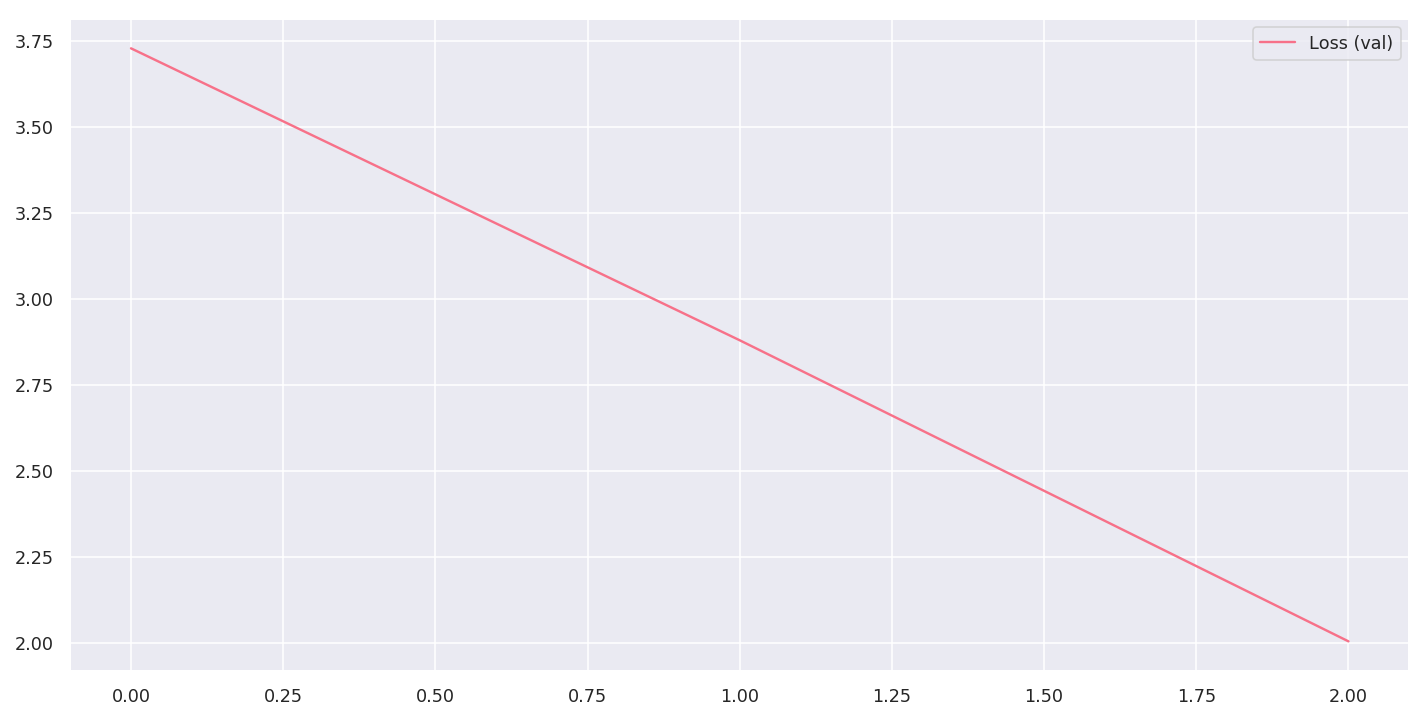

Step: 471, loss: 1.0097


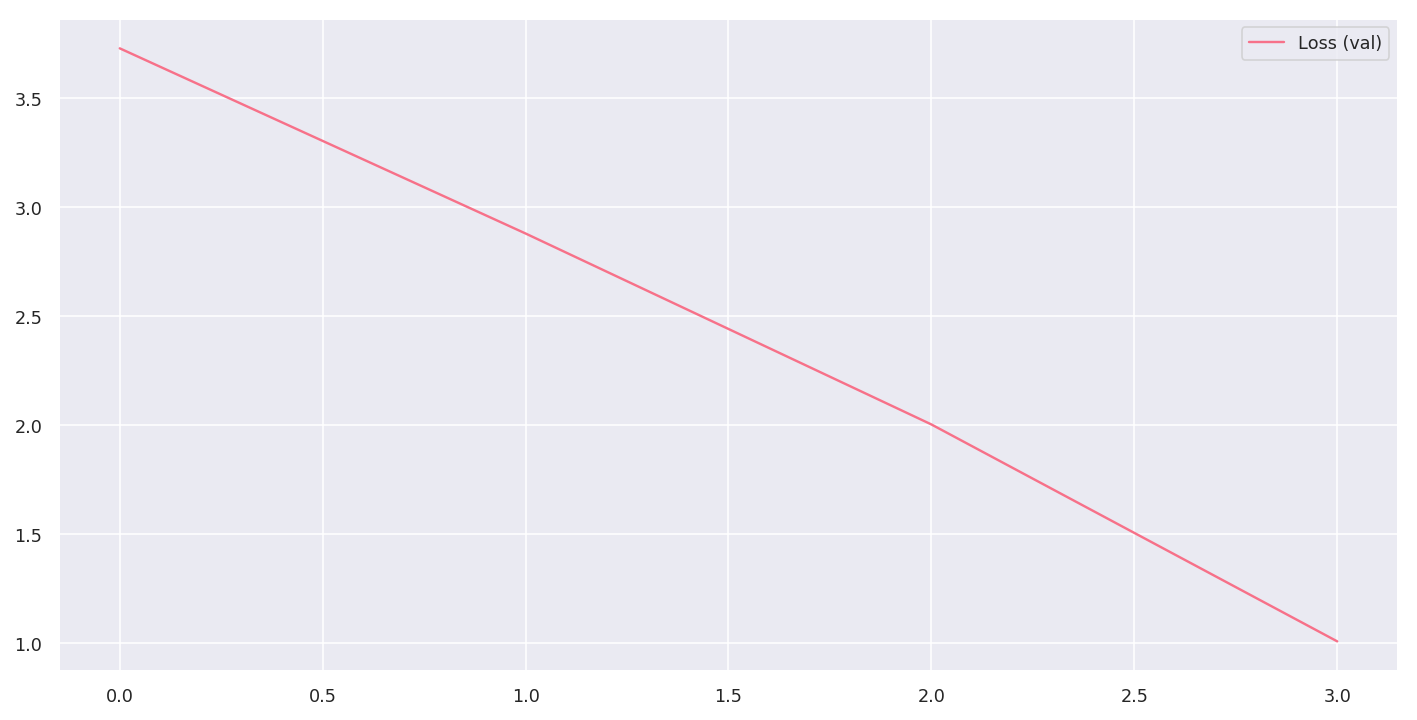

Step: 628, loss: -0.0943


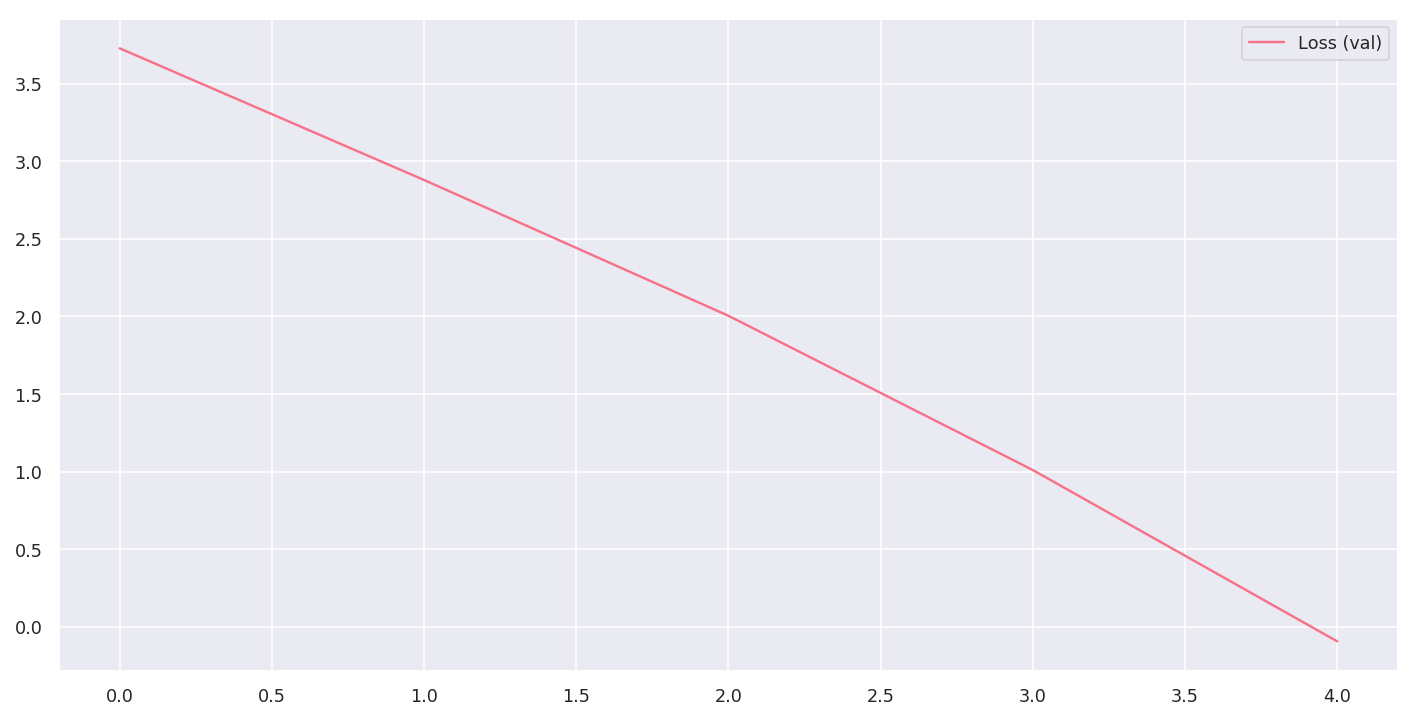

Step: 785, loss: -1.2096


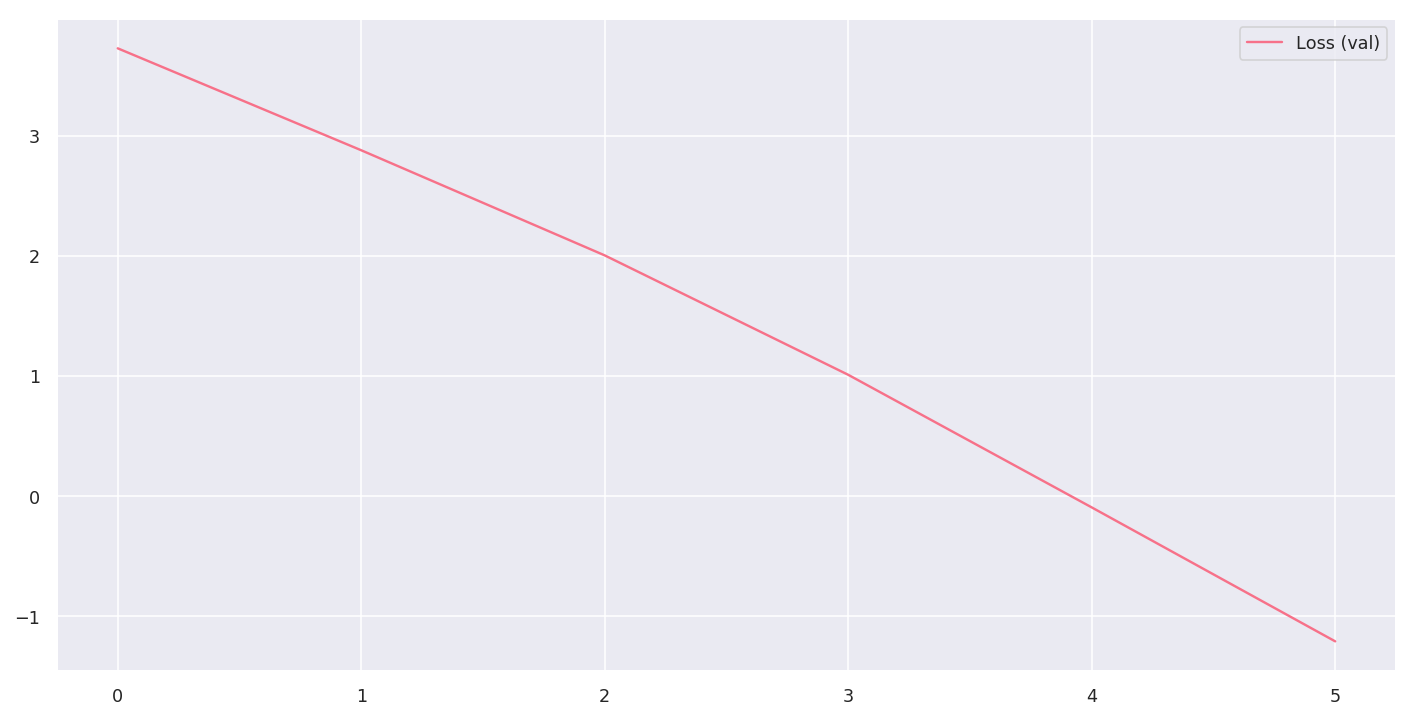

Step: 942, loss: -2.2650


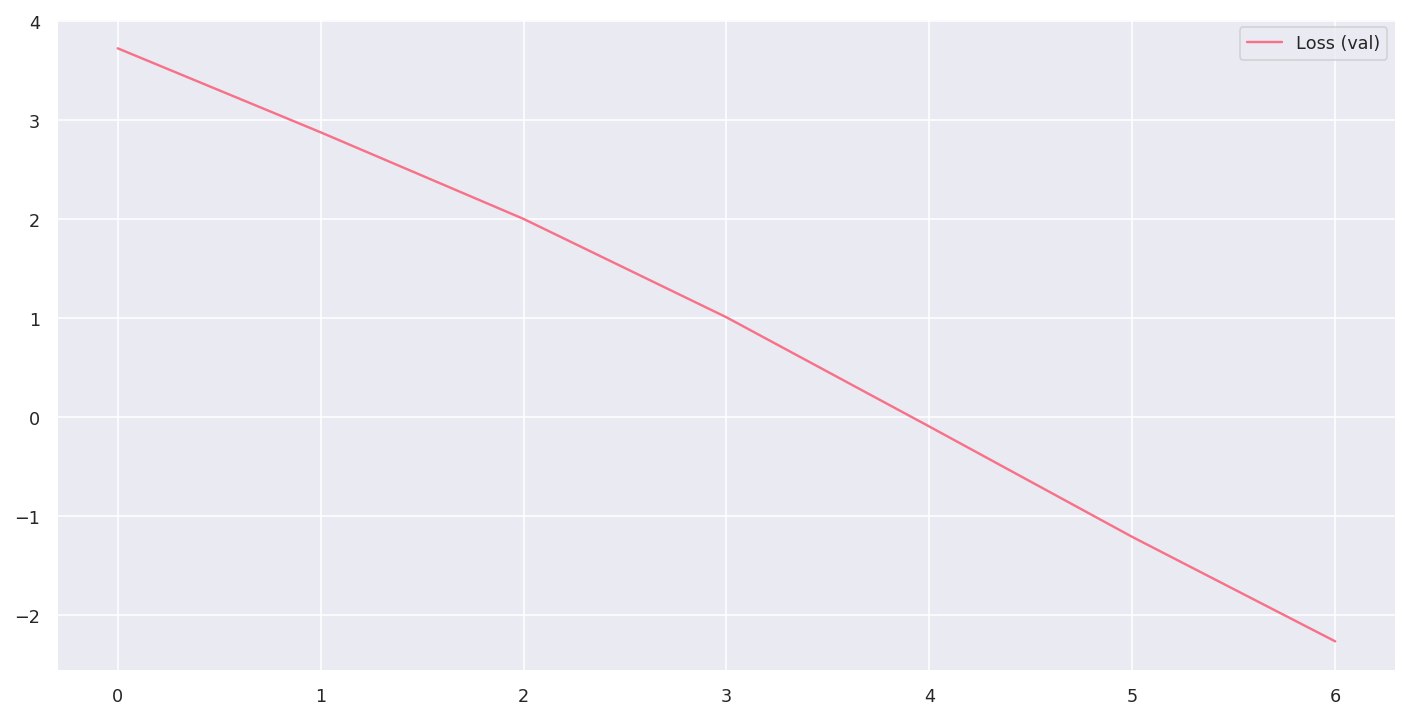

Step: 1099, loss: -3.1268


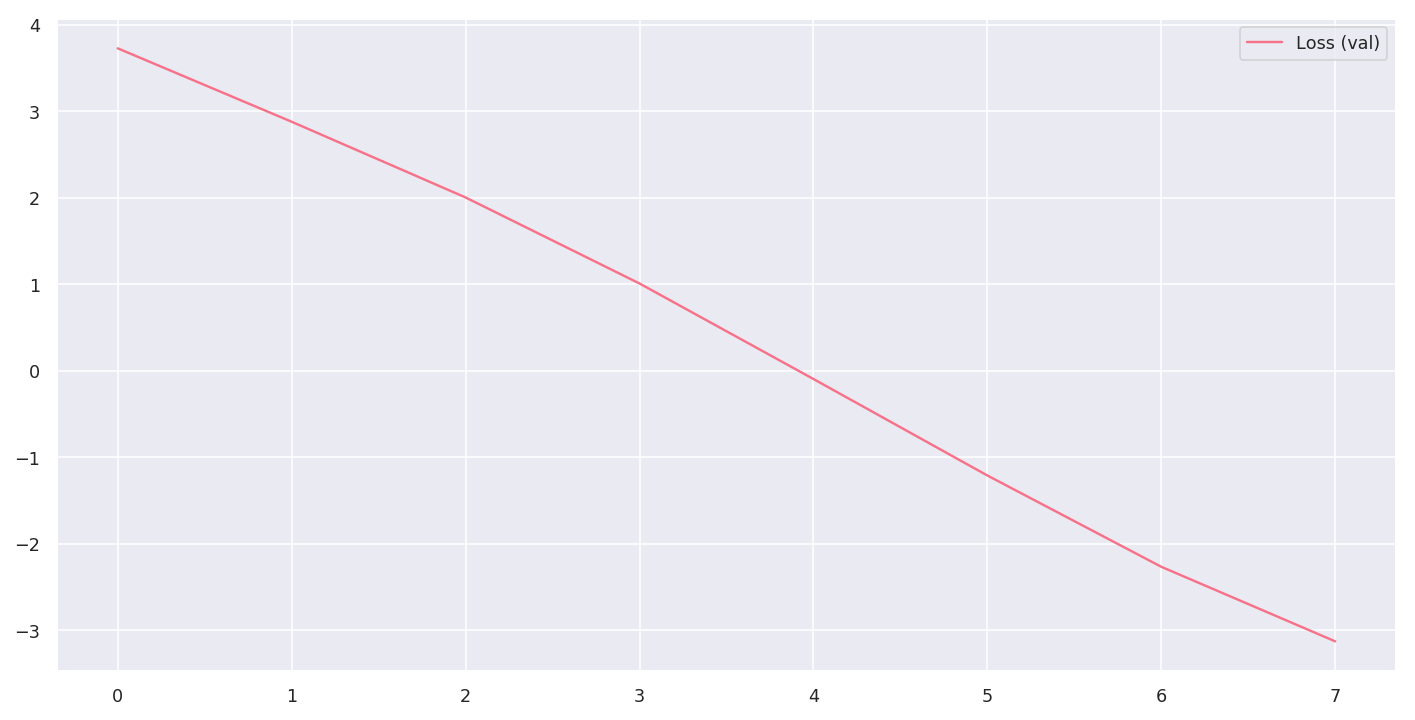

Step: 1256, loss: -3.9011


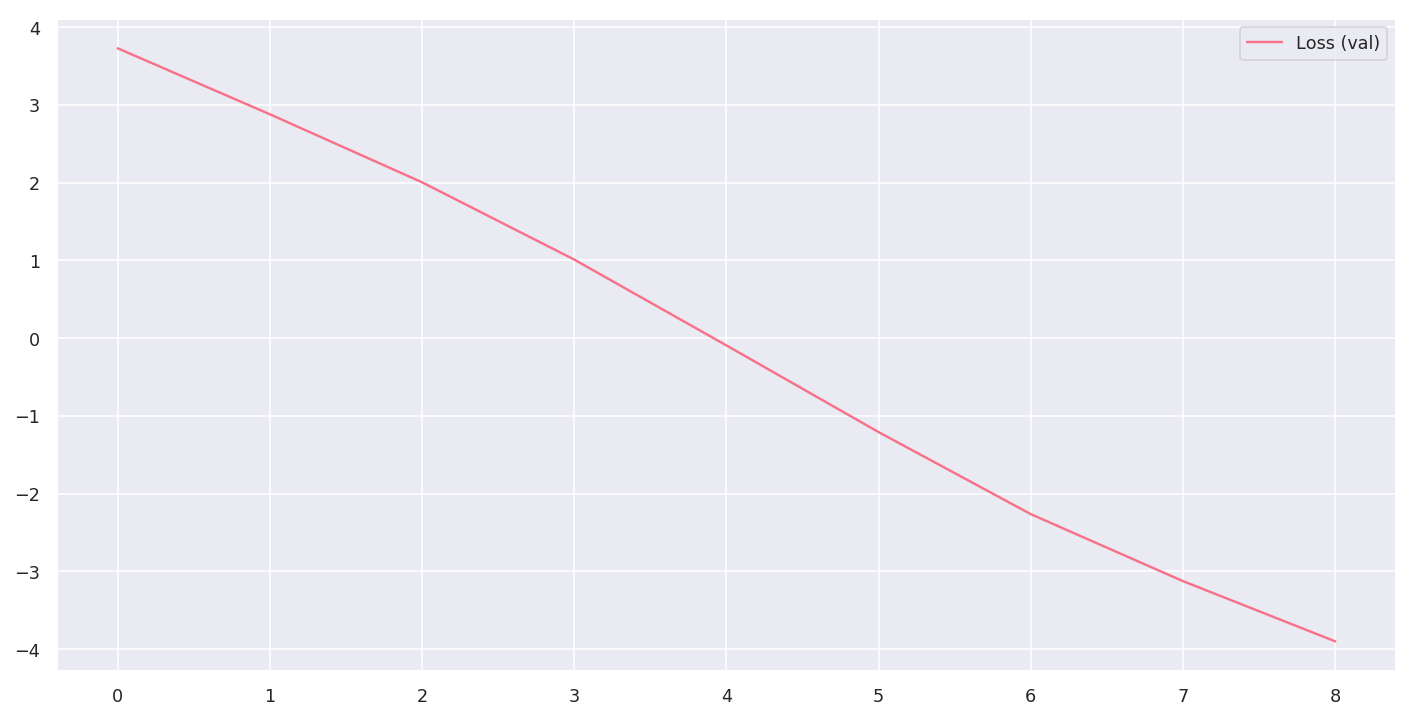

Step: 1413, loss: -2.7630


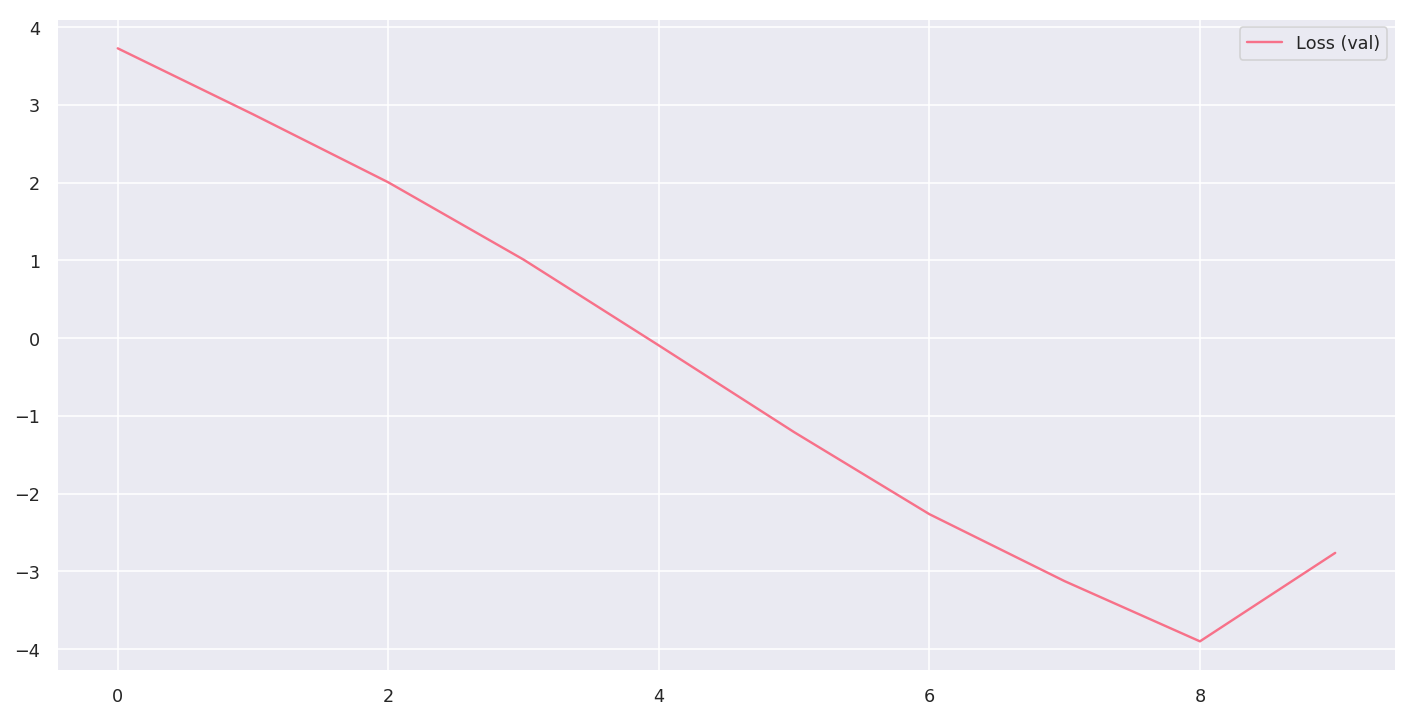

Step: 1570, loss: -3.8083


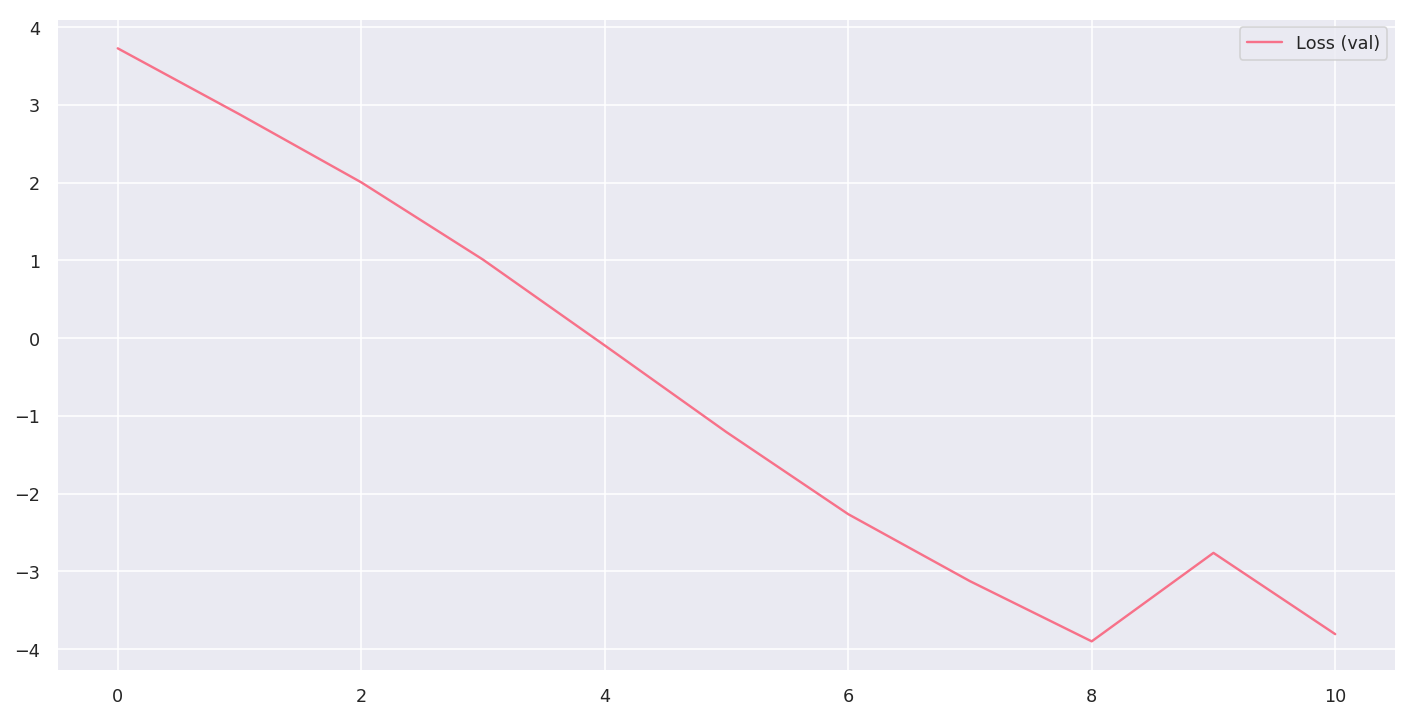

Step: 1727, loss: -5.1487


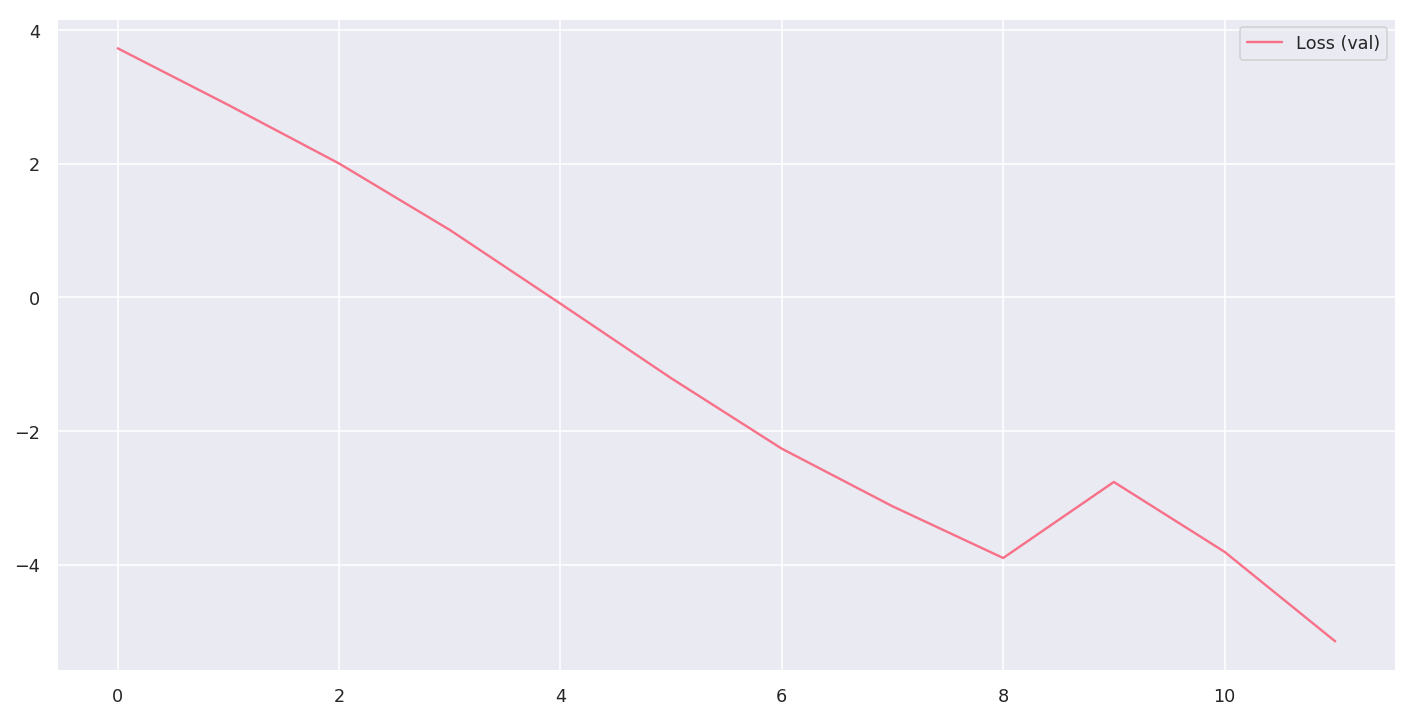

Step: 1884, loss: -5.2628


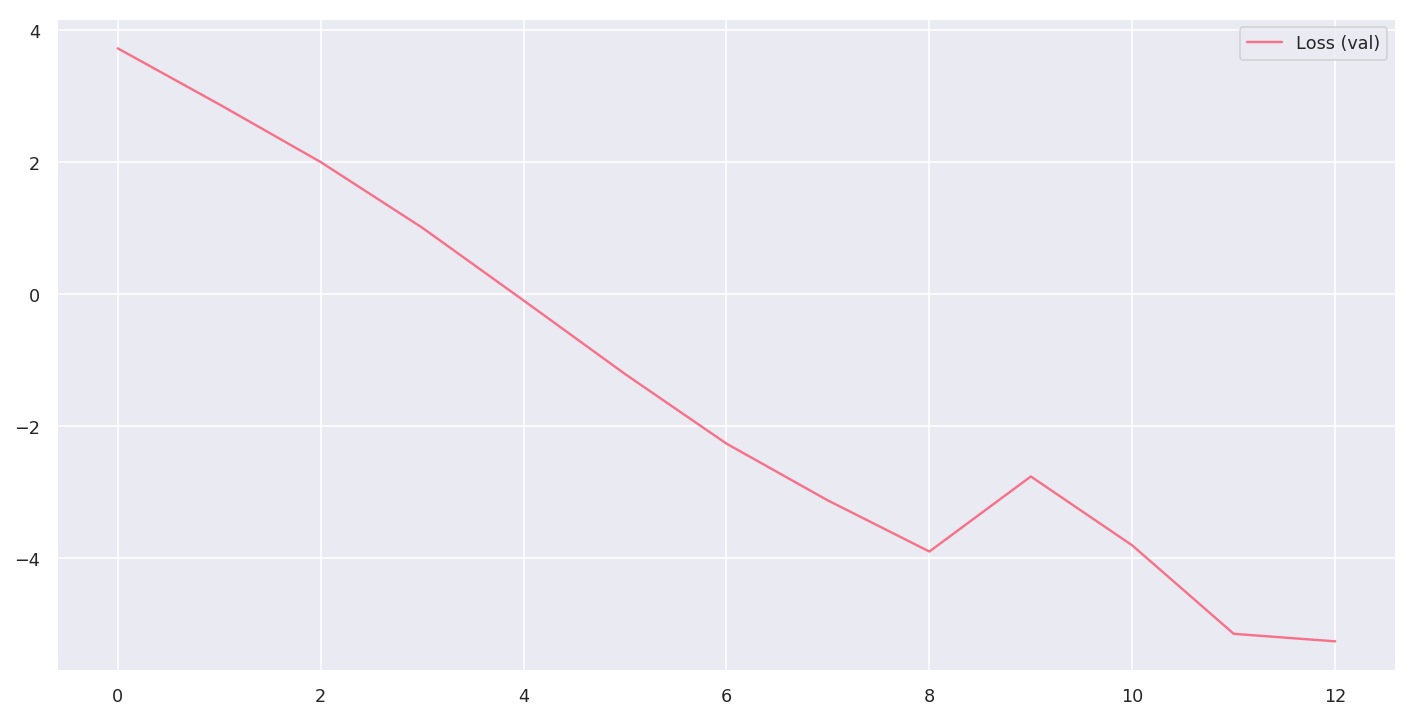

Step: 2041, loss: -5.7366


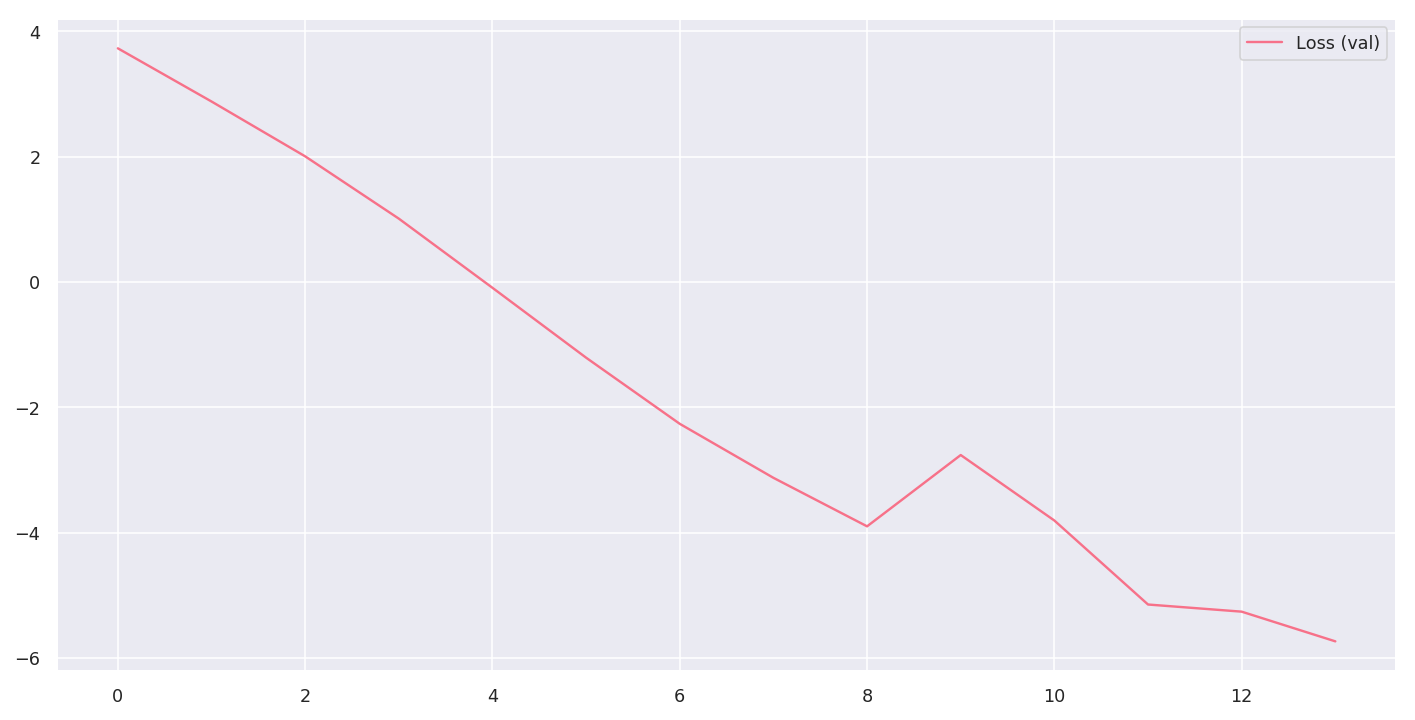

Step: 2198, loss: -5.8654


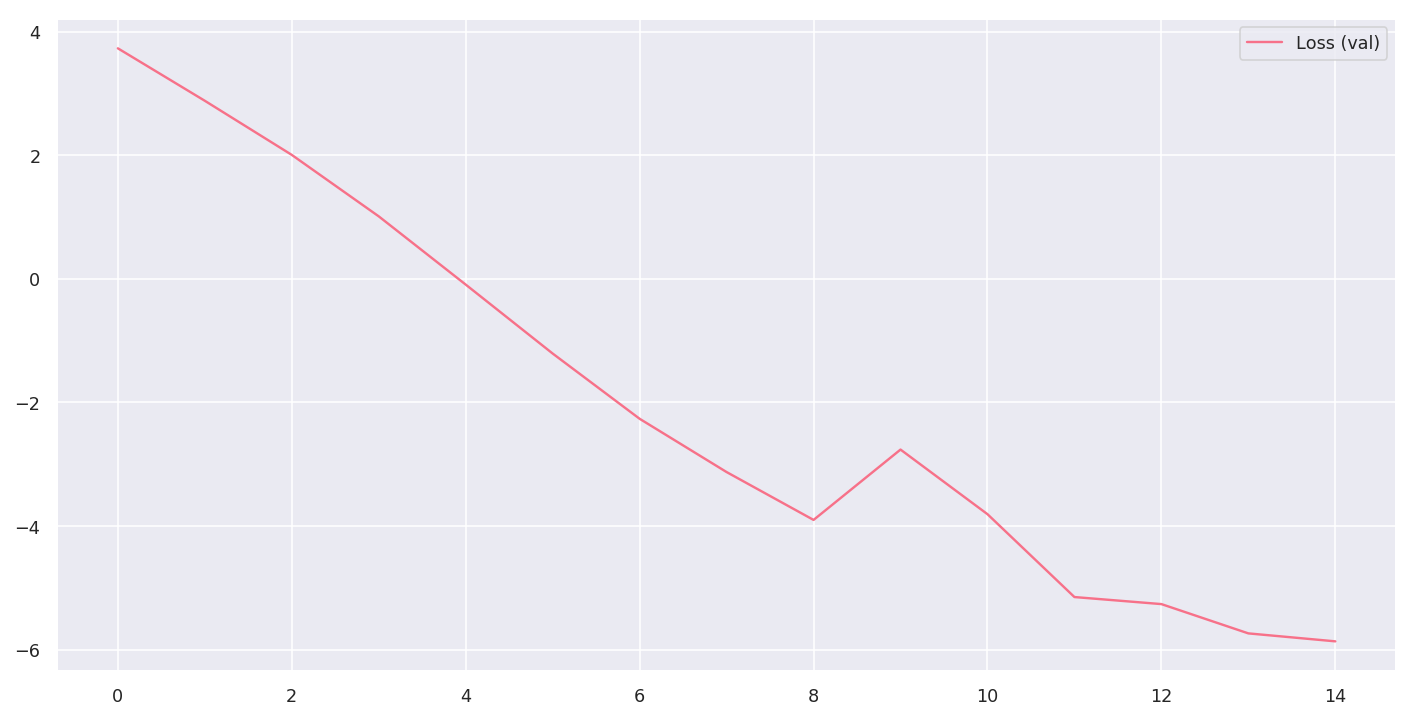

Step: 2355, loss: -6.0331


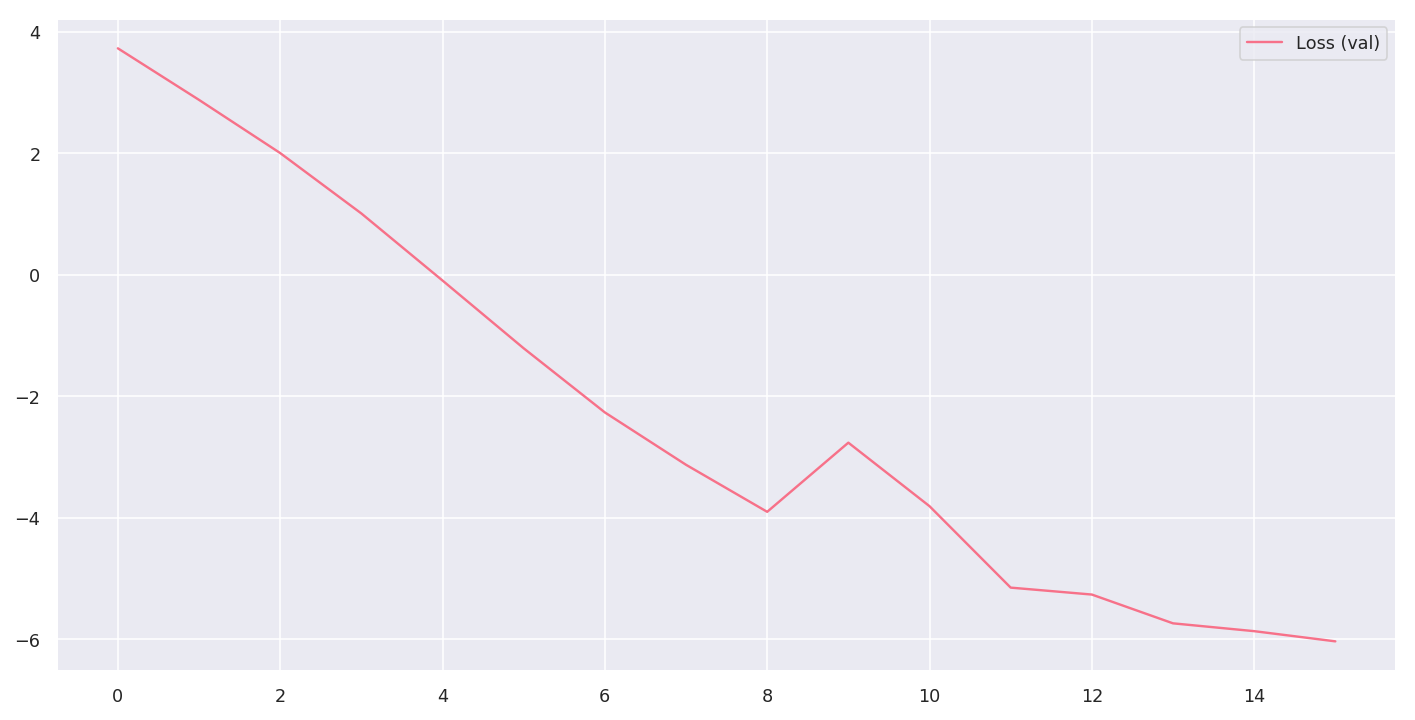

Step: 2512, loss: -6.2530


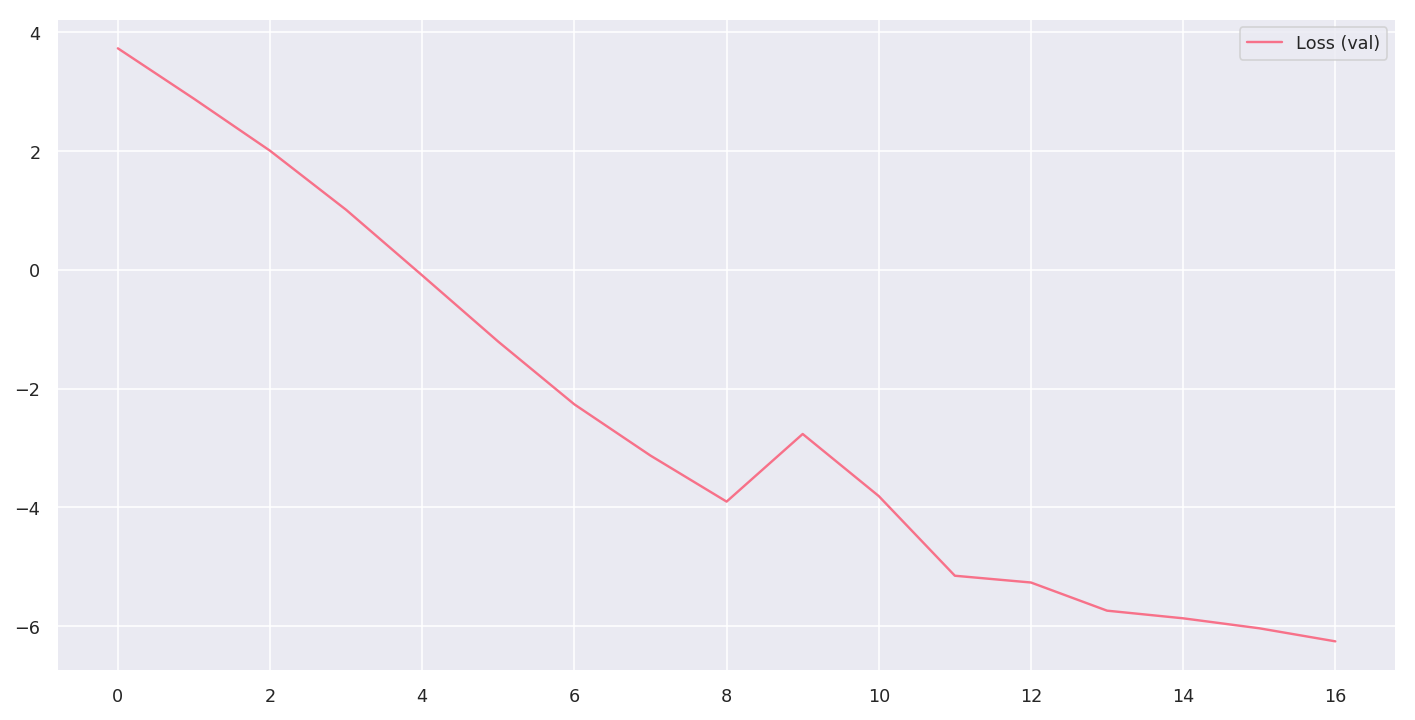

Step: 2669, loss: -6.0706


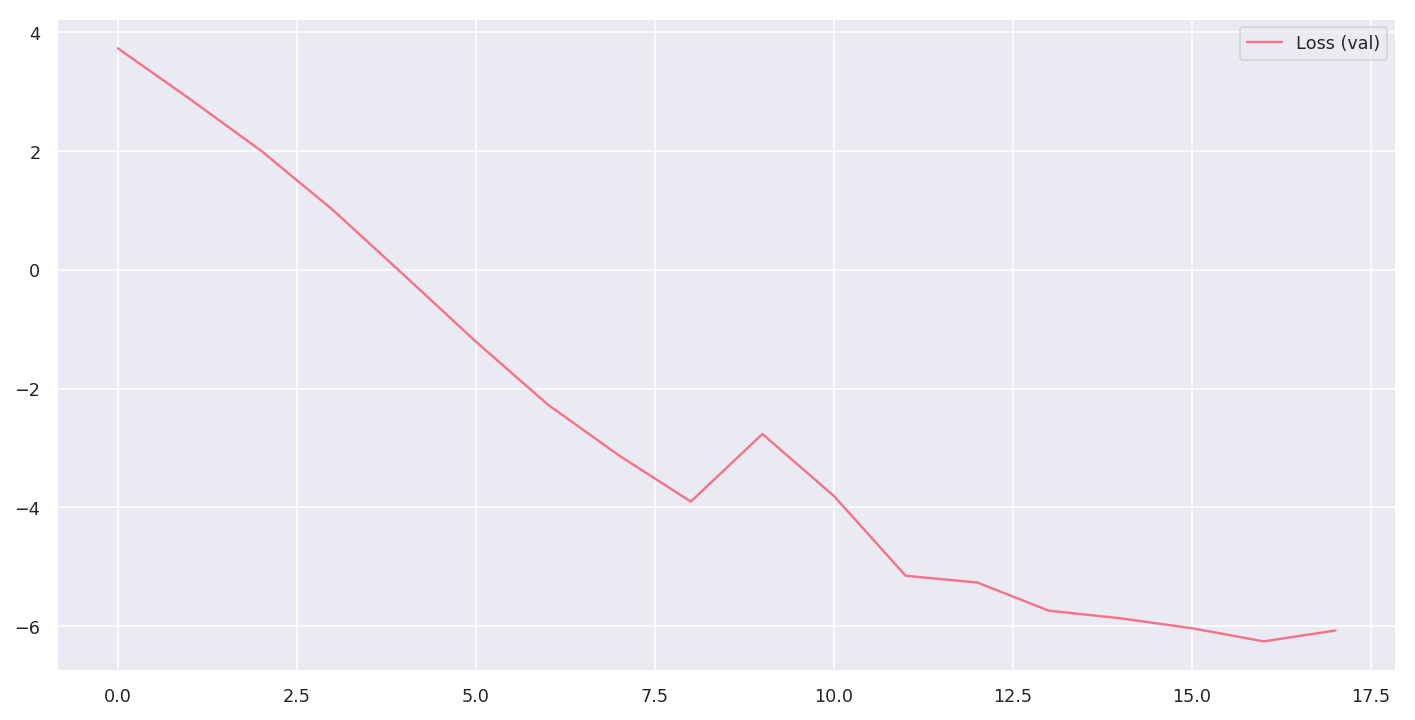

Step: 2826, loss: -5.9660


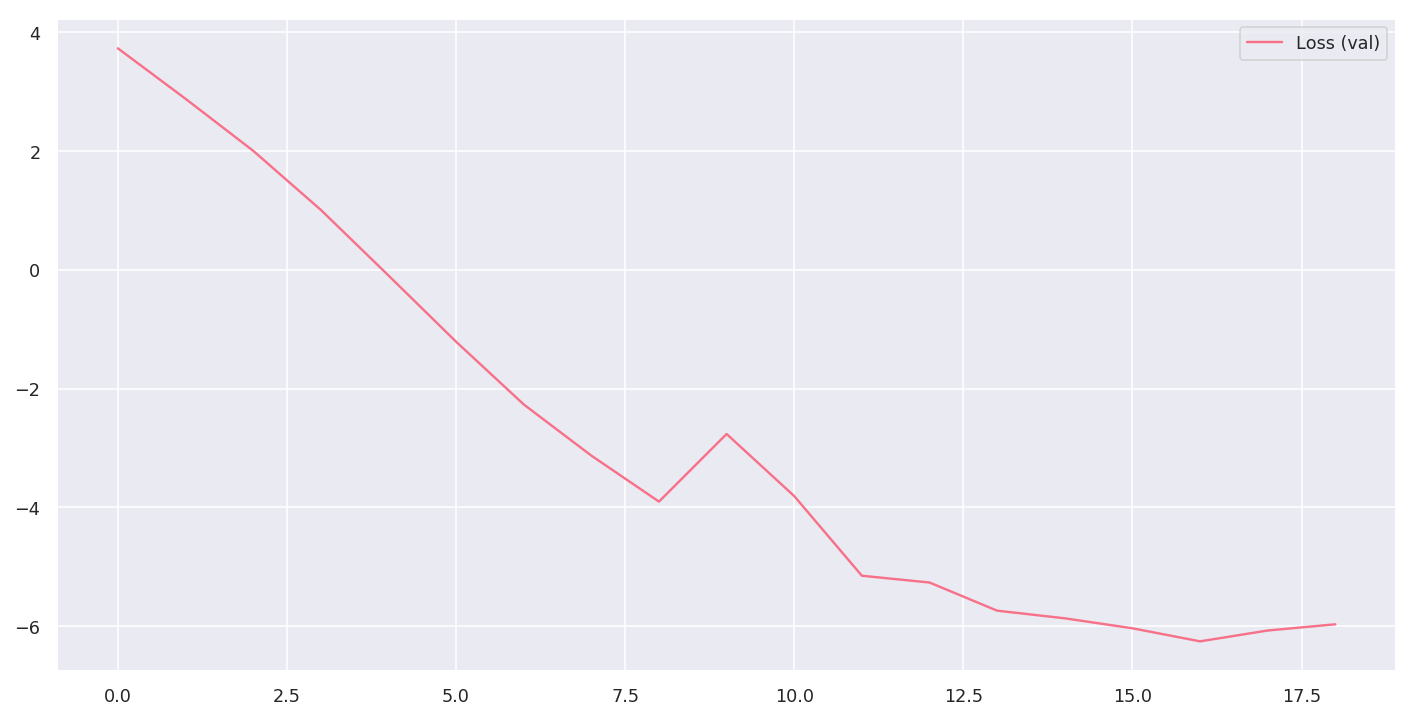

Step: 2983, loss: -5.6919


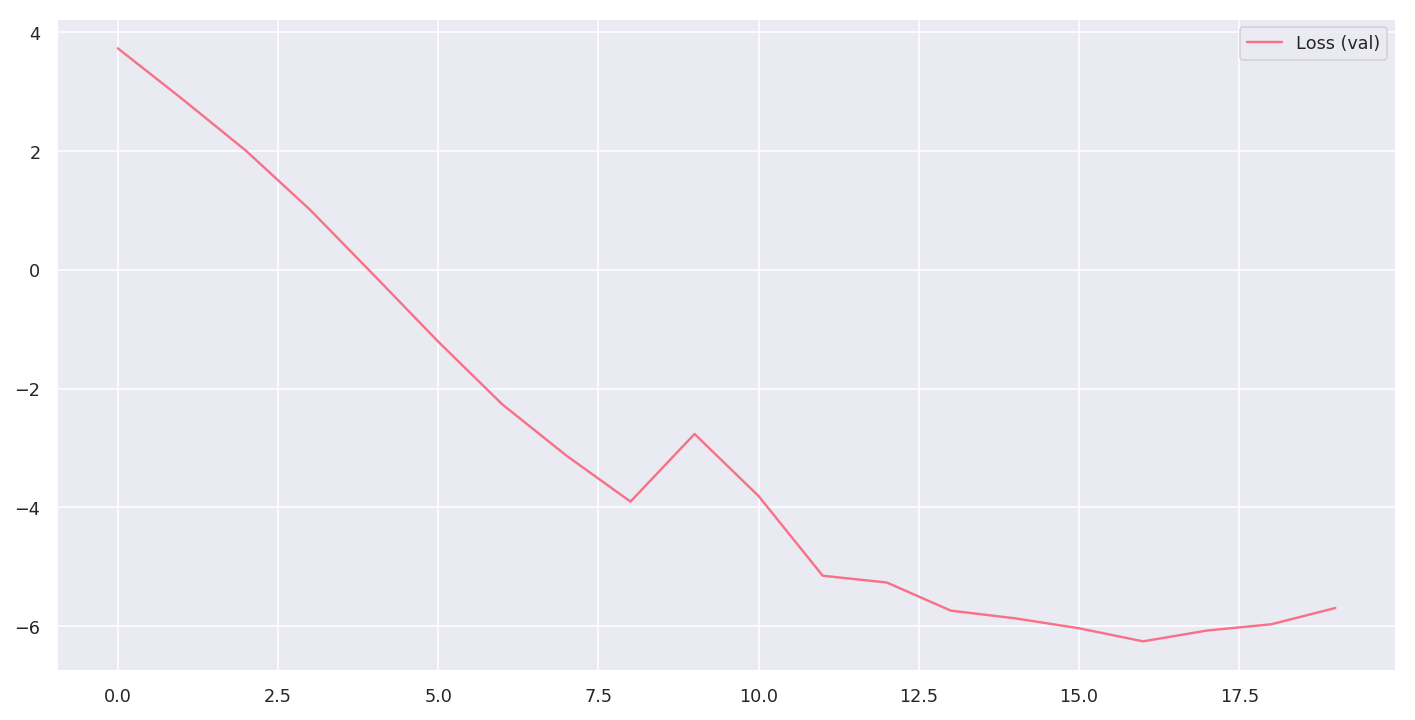

Step: 3140, loss: -6.7395


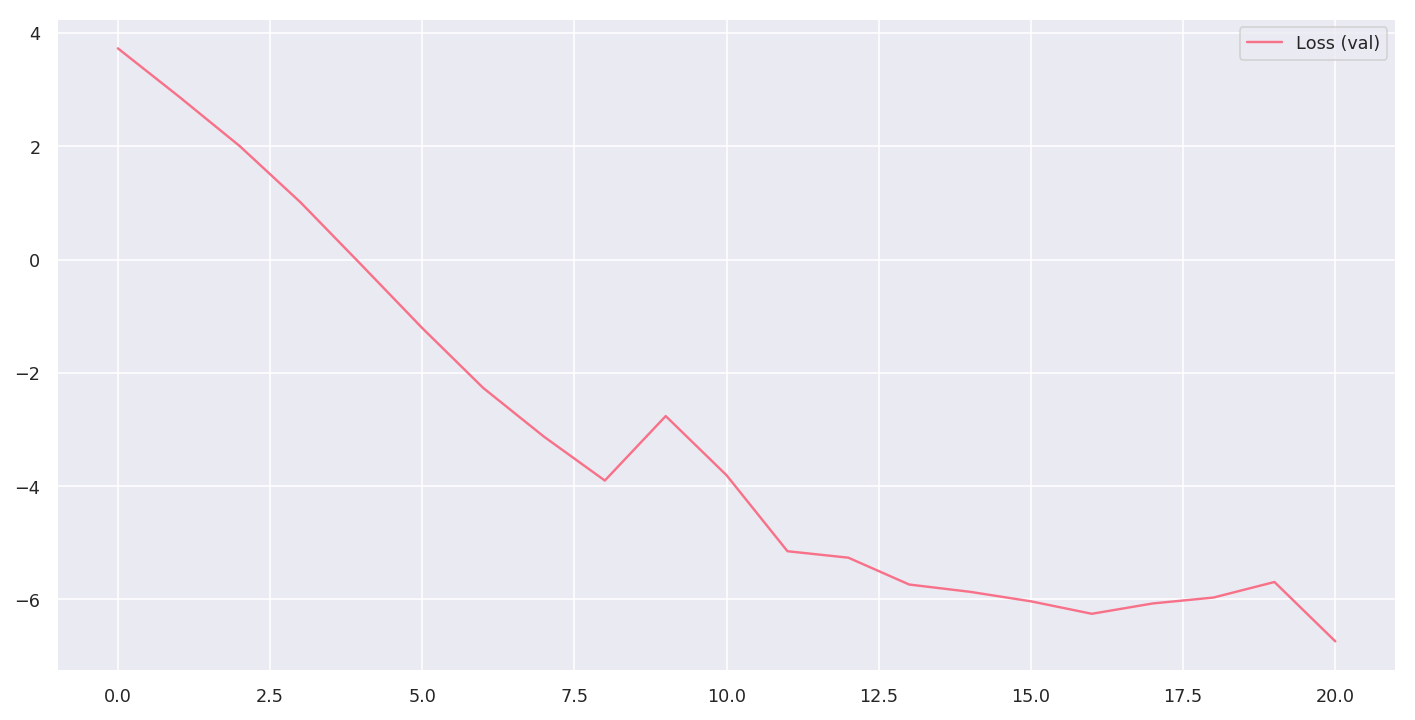

Step: 3297, loss: -6.3475


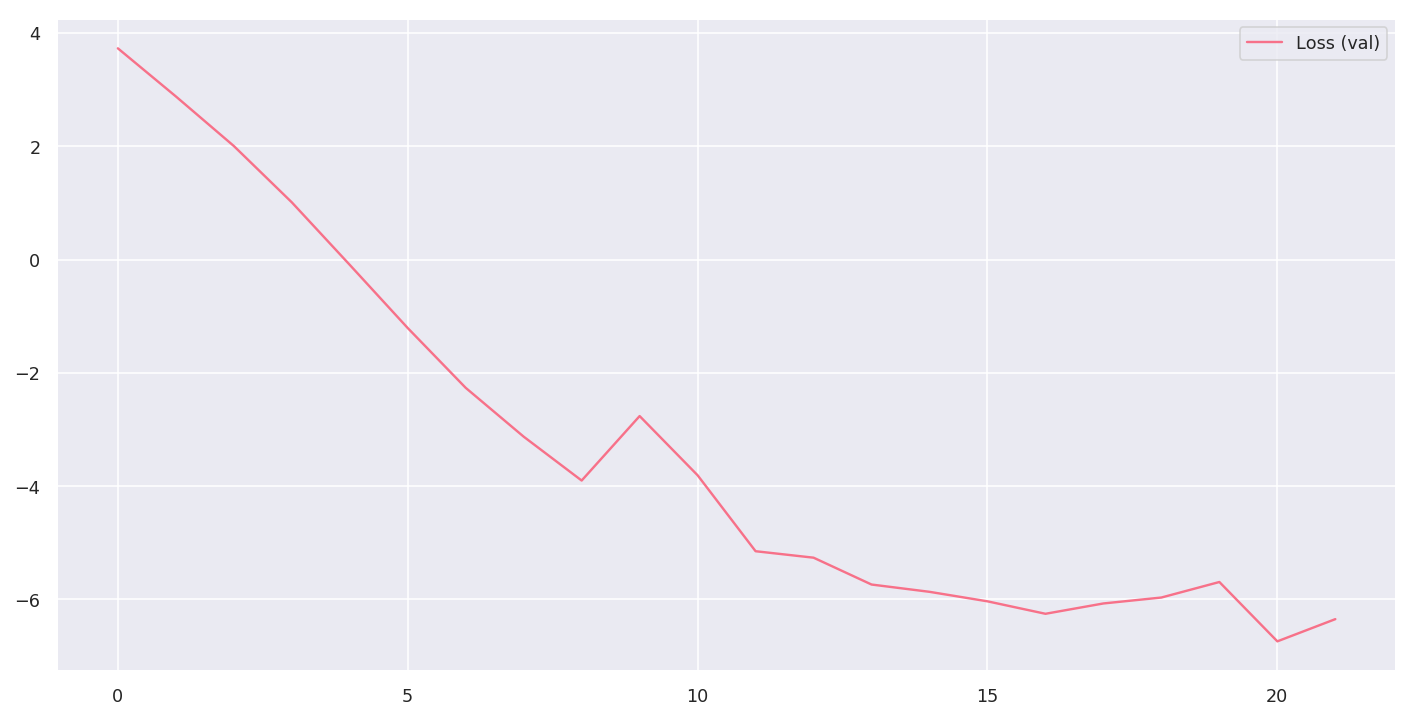

Step: 3454, loss: -6.8448


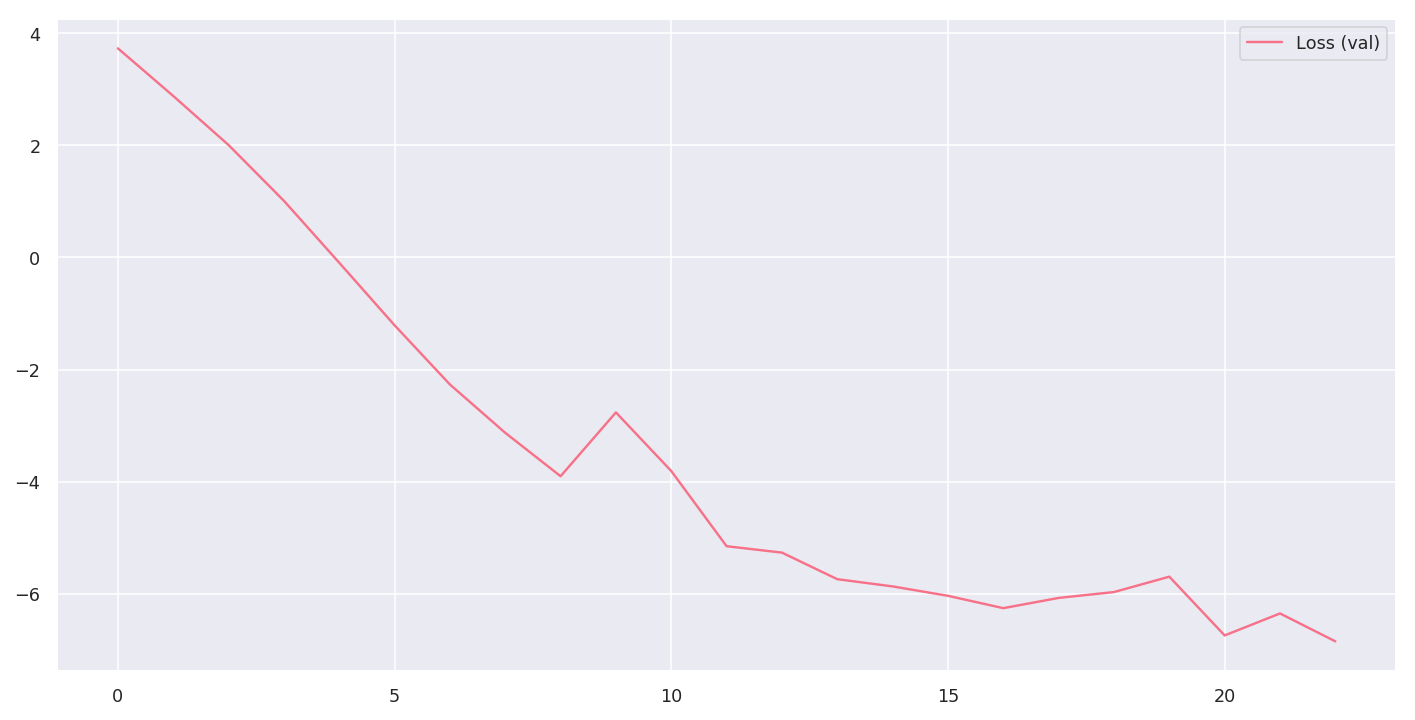

Step: 3611, loss: -6.4607


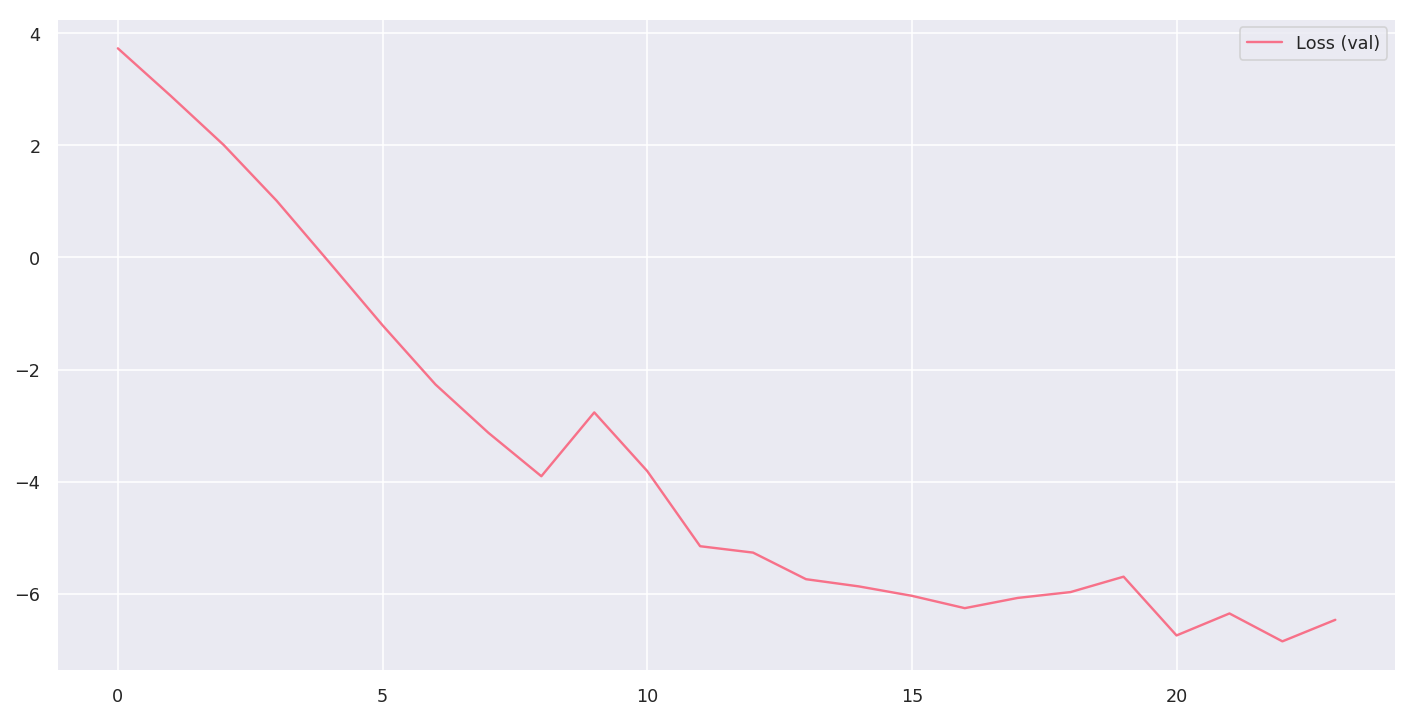

Step: 3768, loss: -7.0635


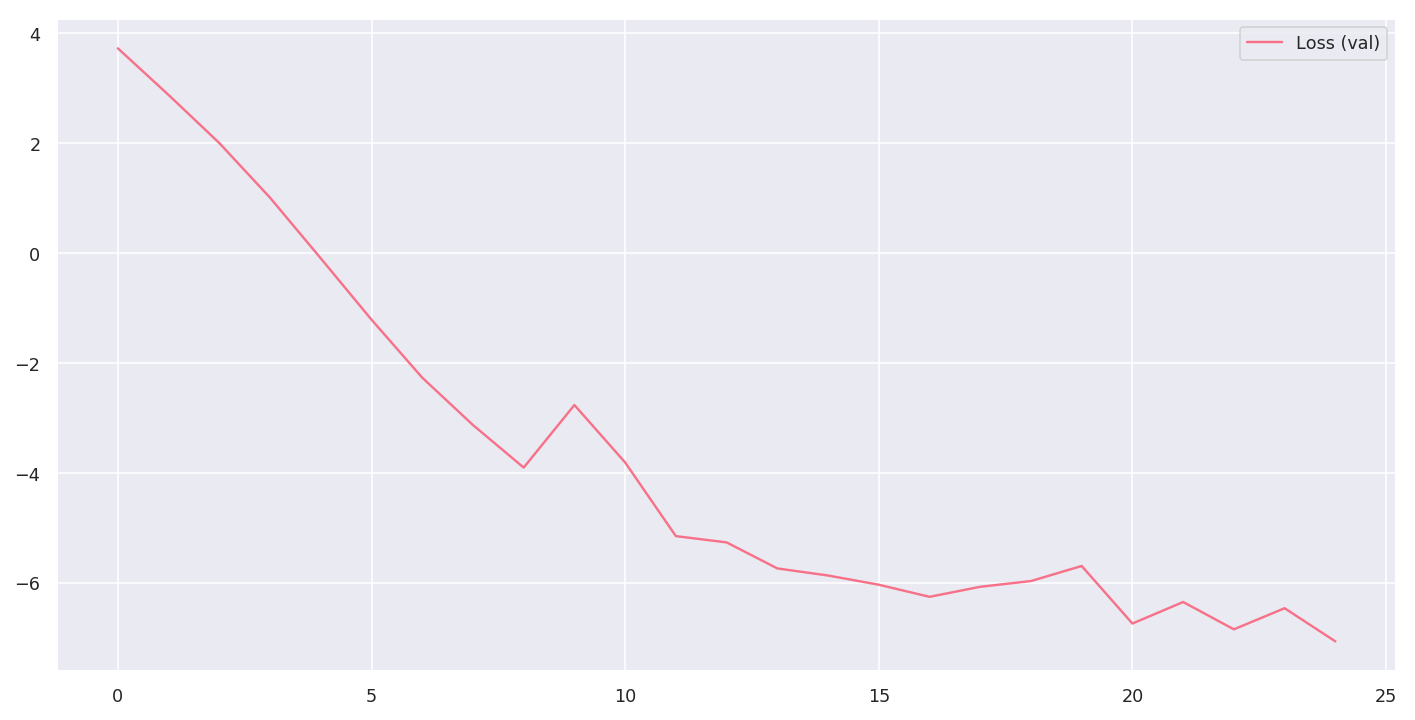

Step: 3925, loss: -7.1608


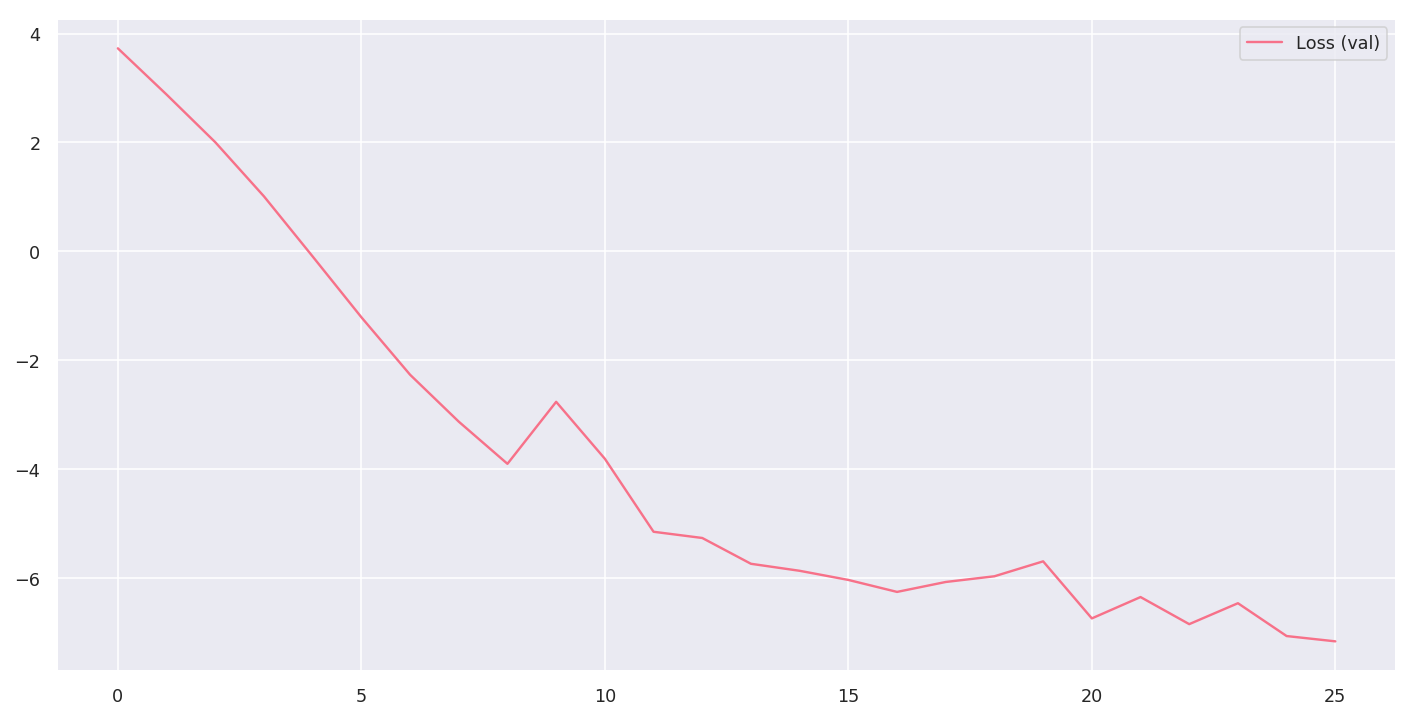

Step: 4082, loss: -7.1789


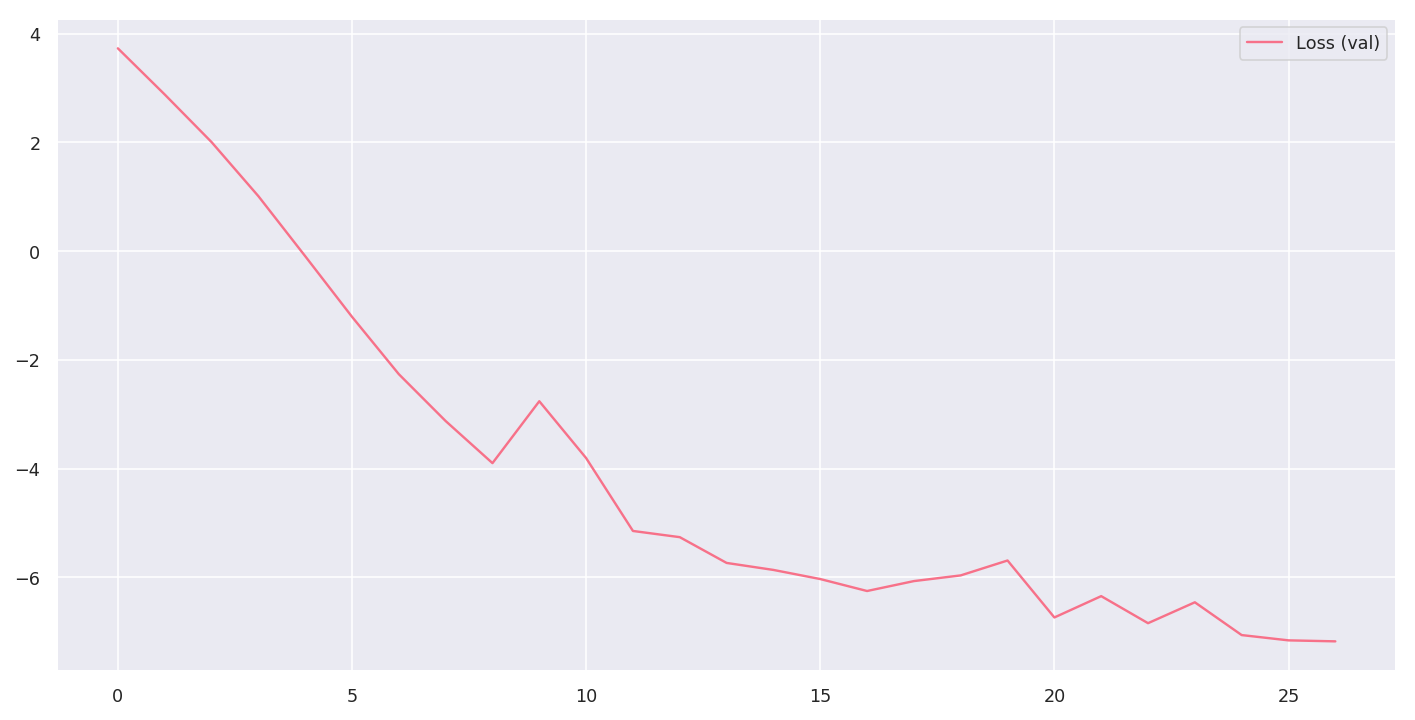

Step: 4239, loss: -7.0316


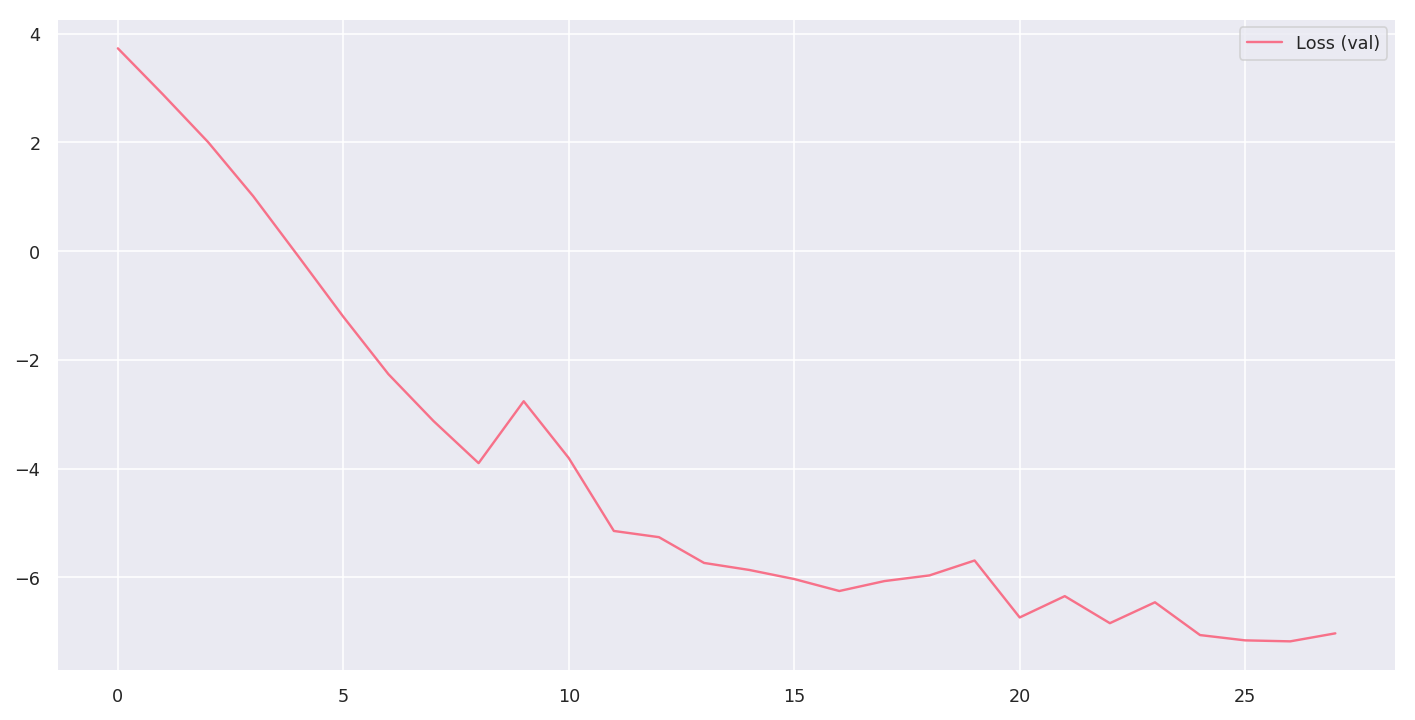

Step: 4396, loss: -7.0747


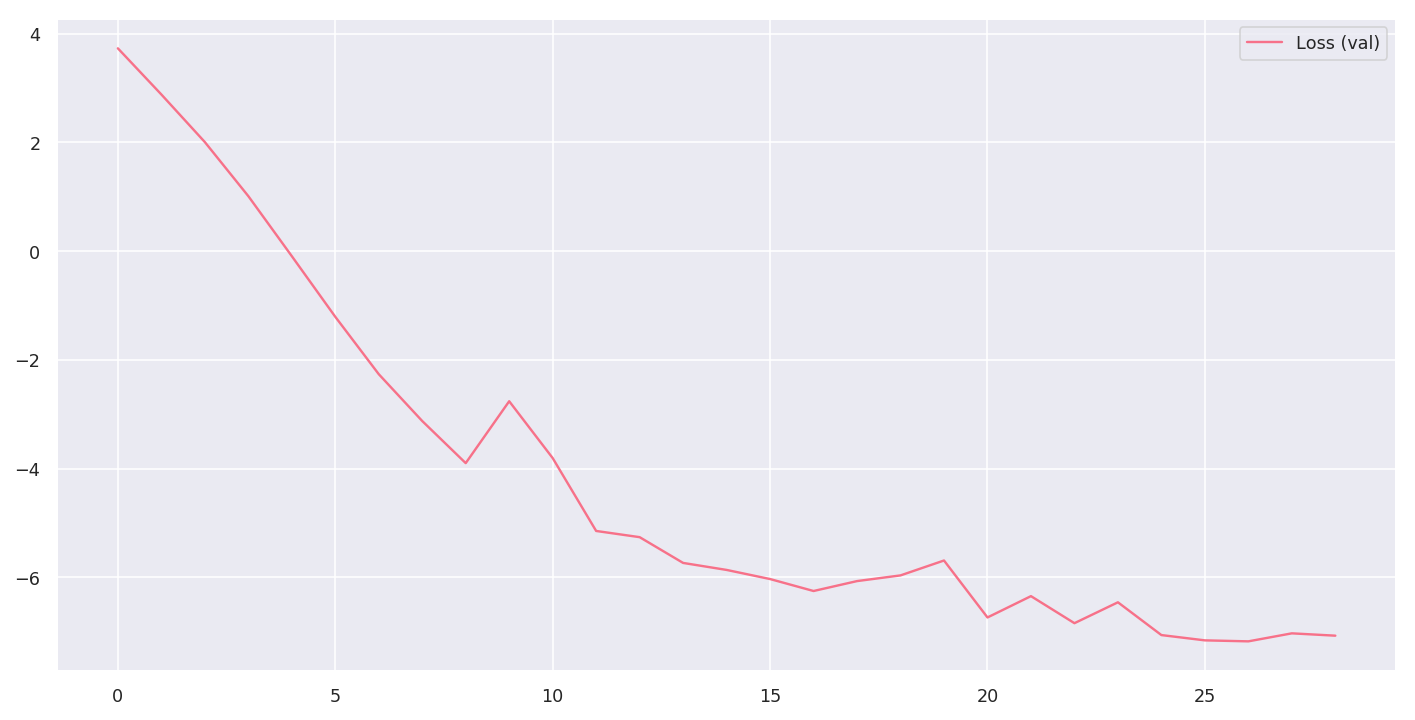

Step: 4553, loss: -7.0798


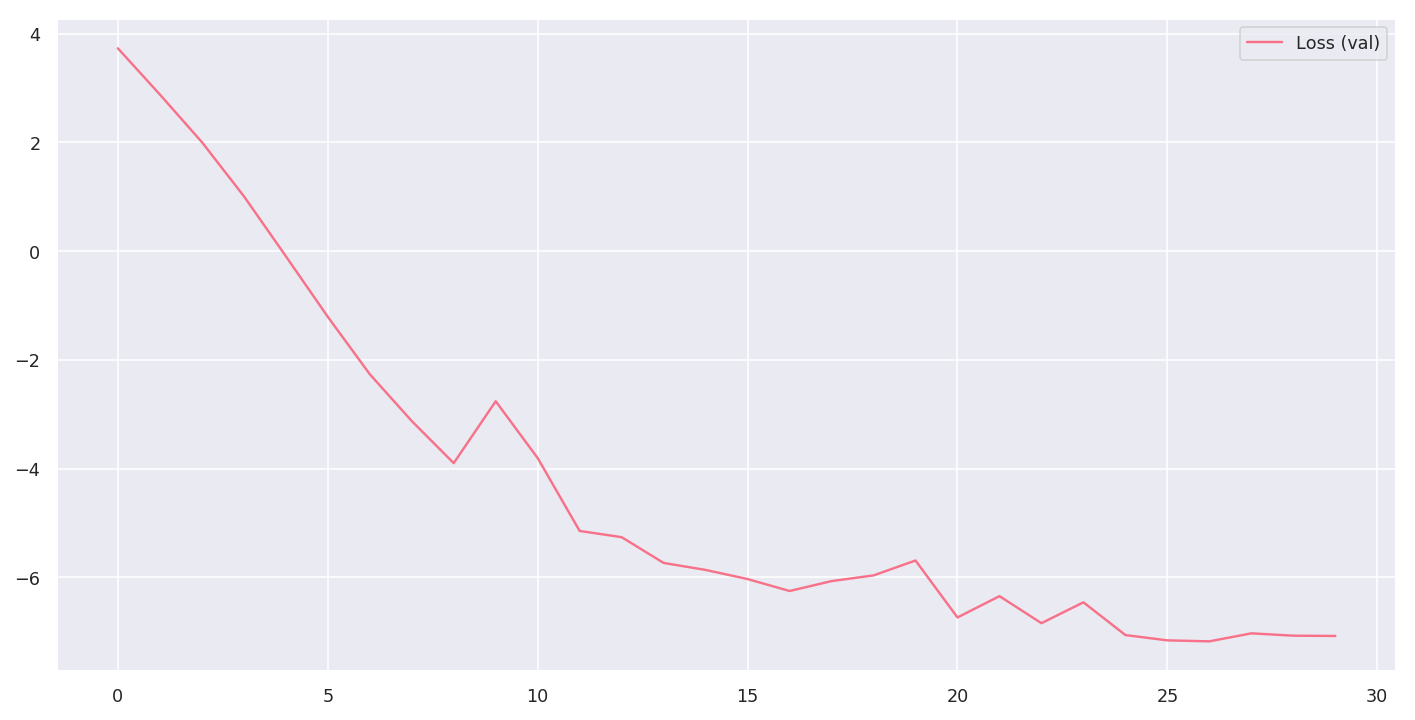

Step: 4710, loss: -7.5452


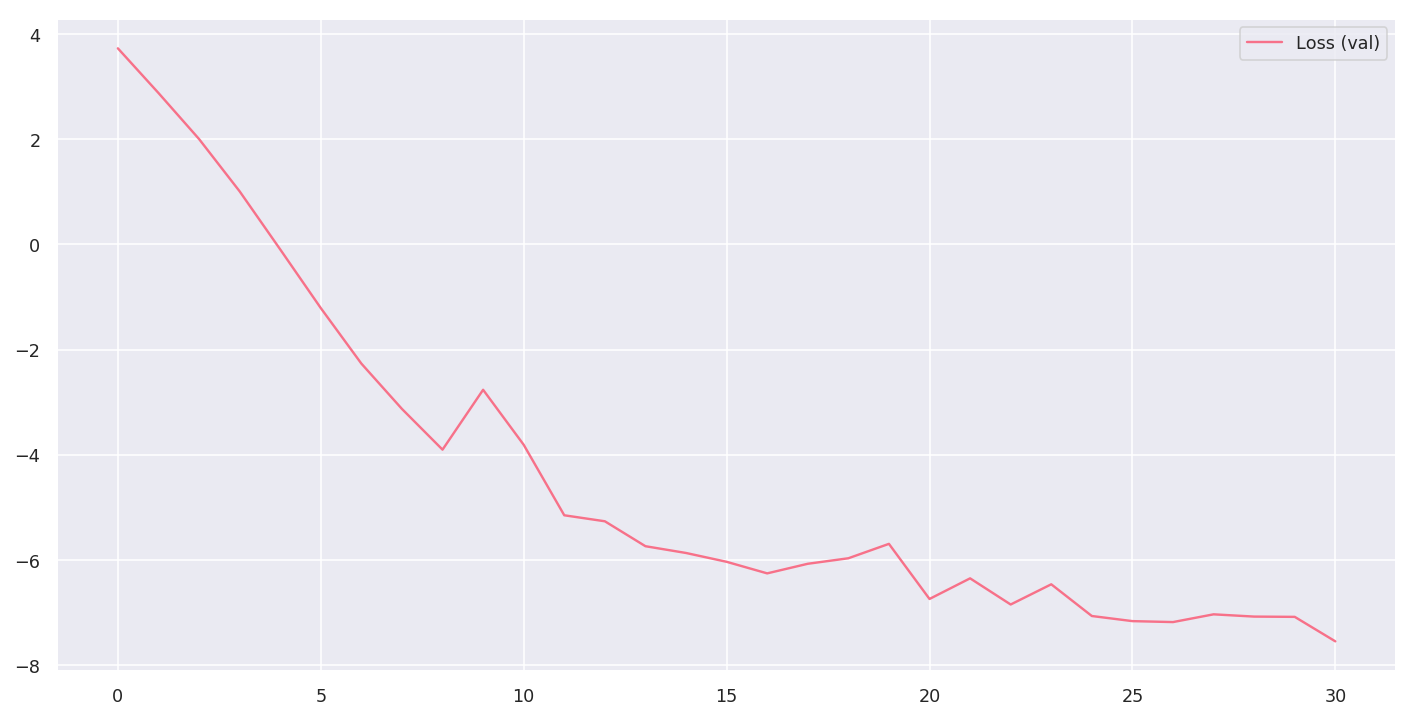

Step: 4867, loss: -7.4298


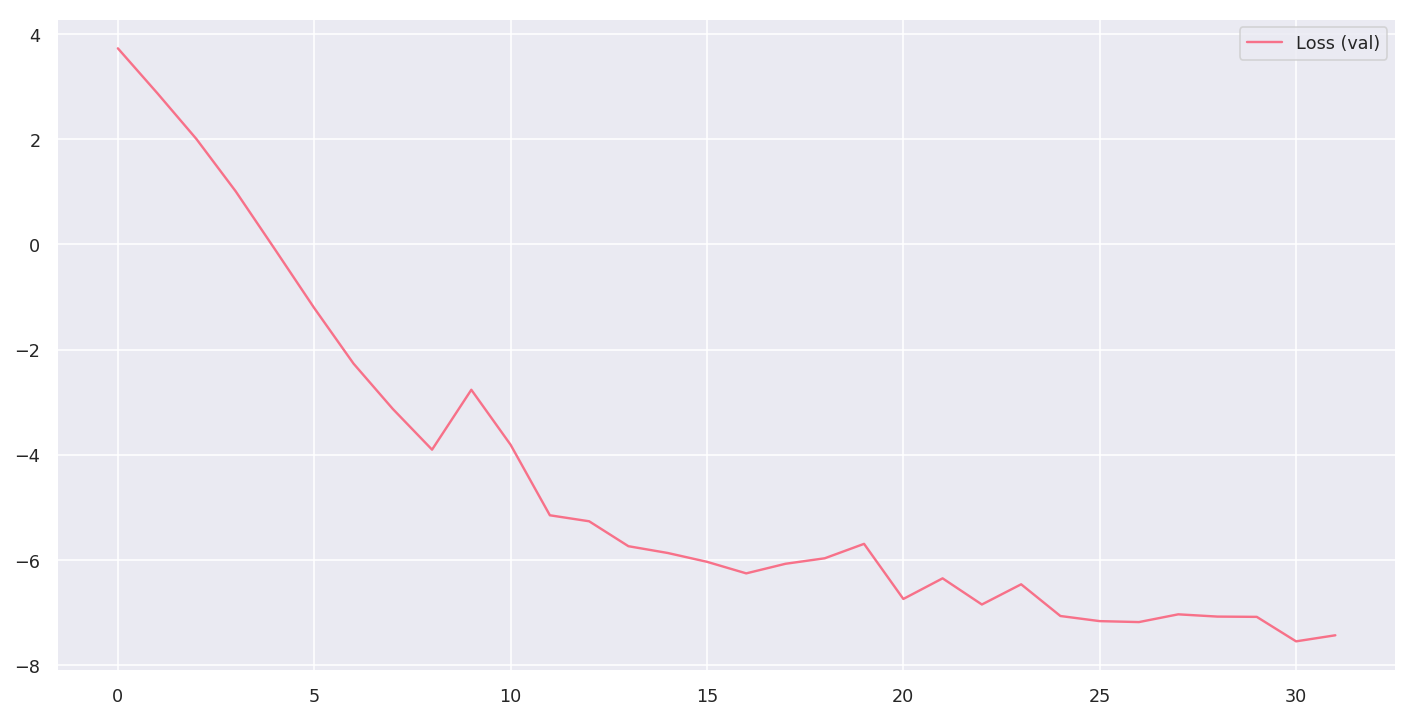

Step: 5024, loss: -7.5886


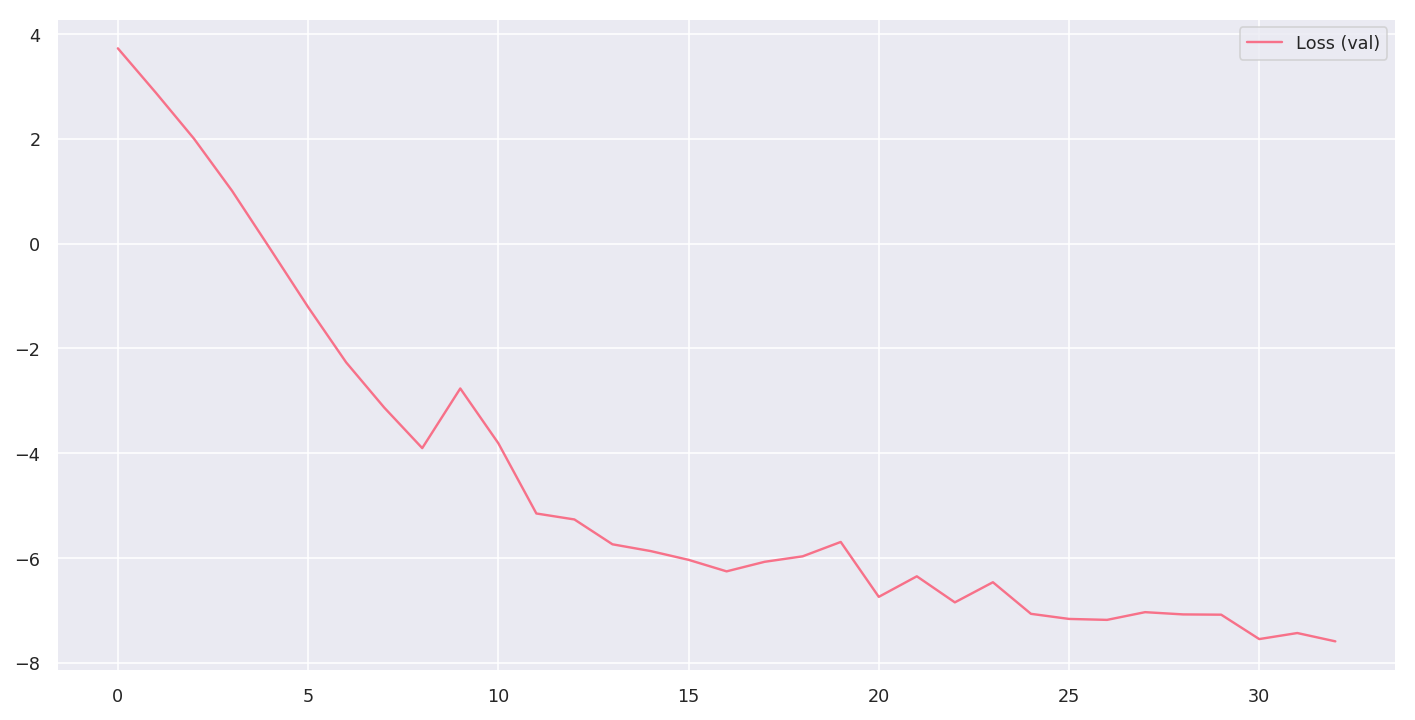

Step: 5181, loss: -7.5914


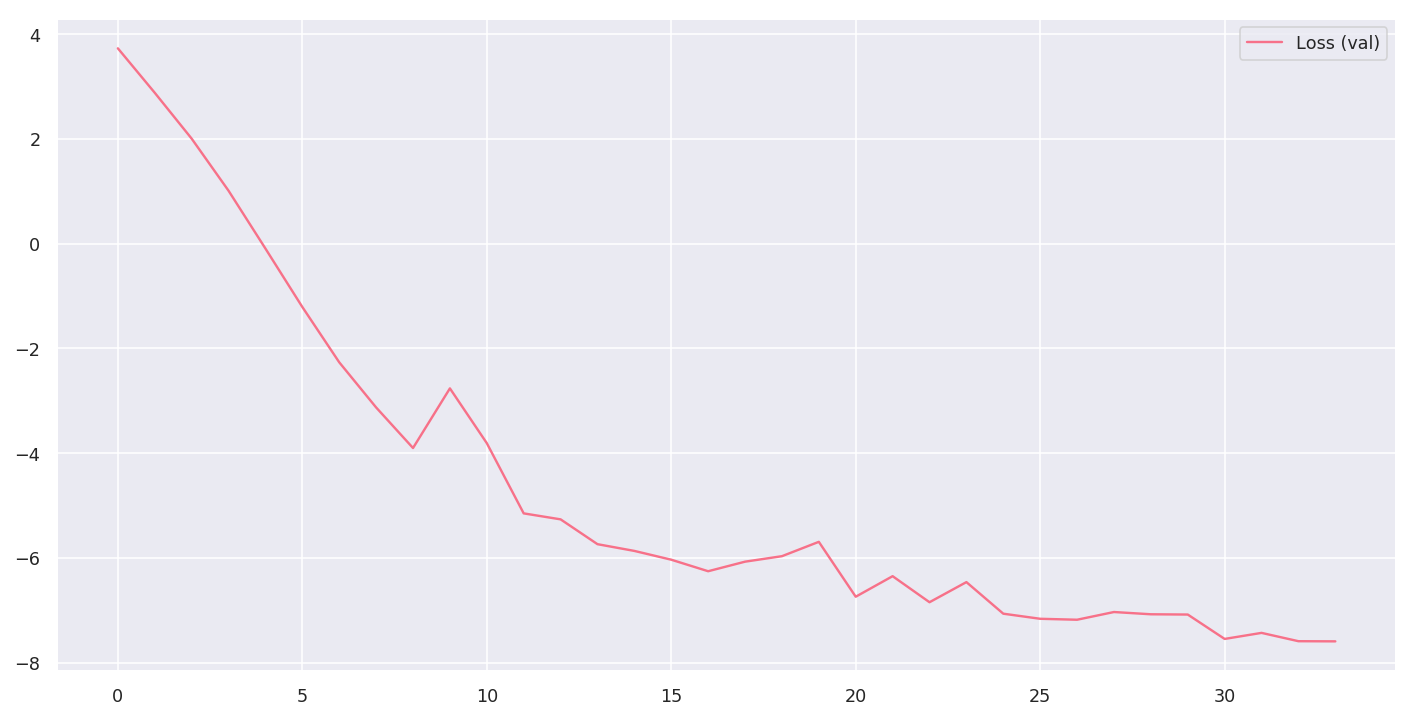

Step: 5338, loss: -7.3237


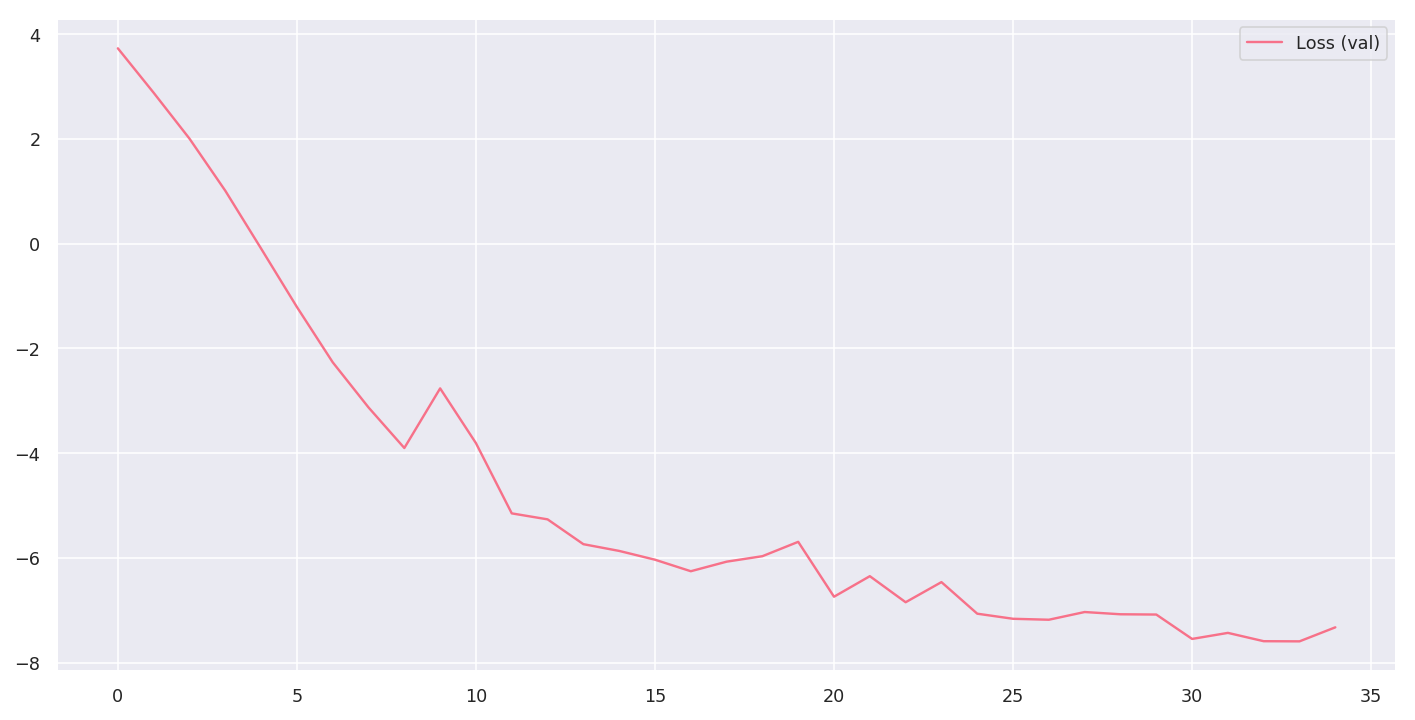

Step: 5495, loss: -7.7826


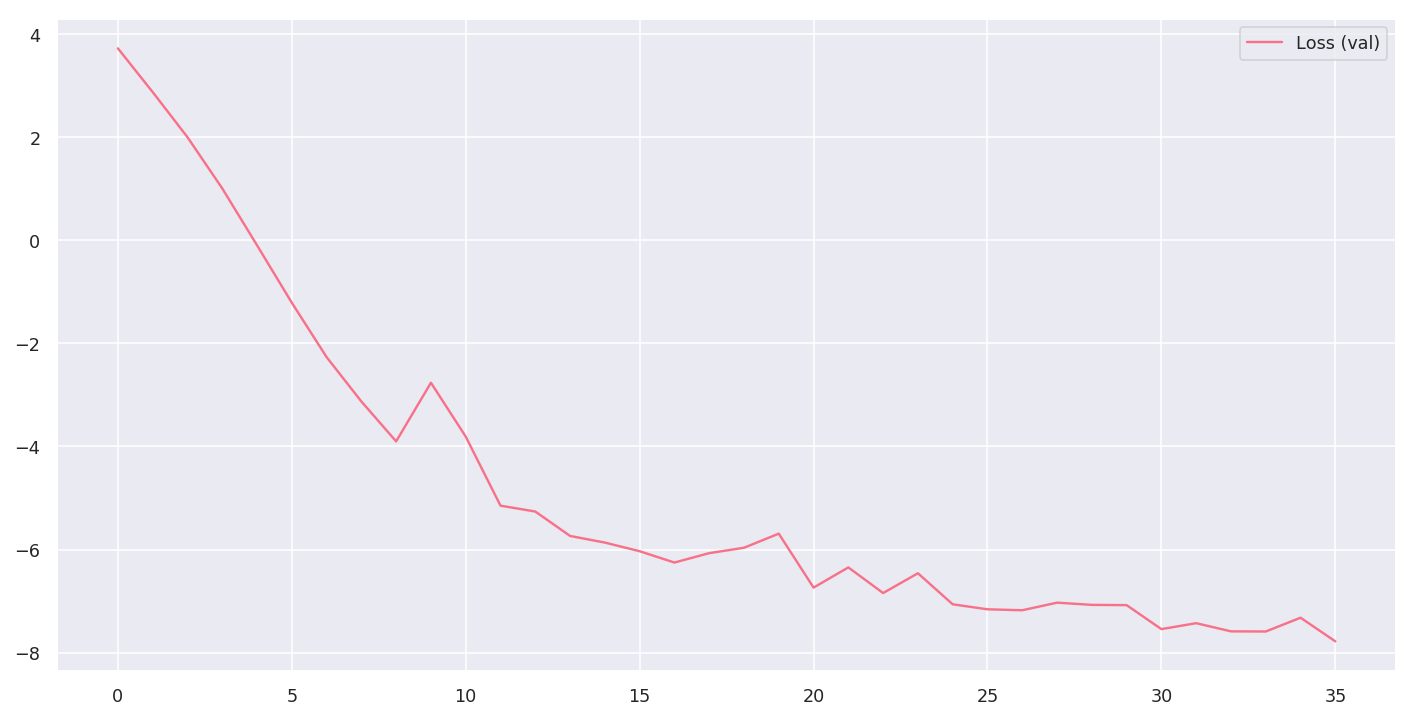

Step: 5652, loss: -7.5975


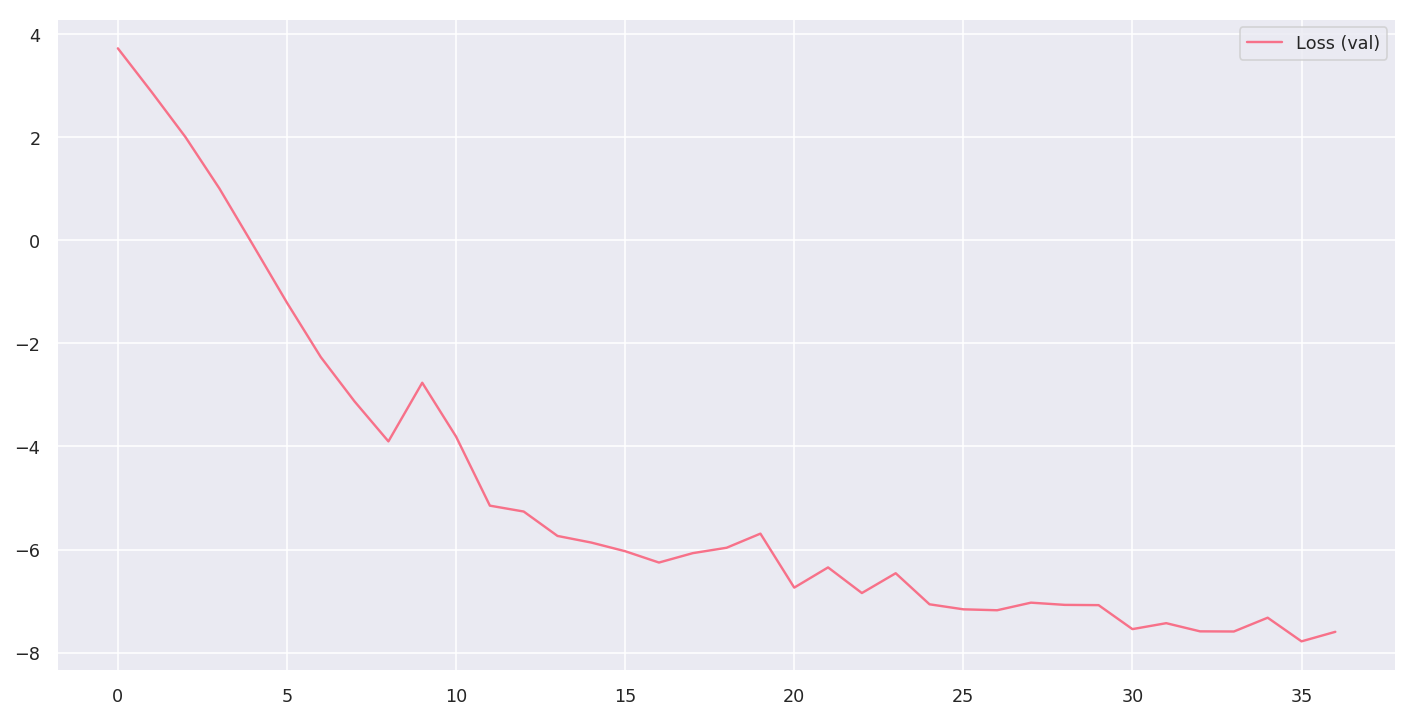

Step: 5809, loss: -7.8310


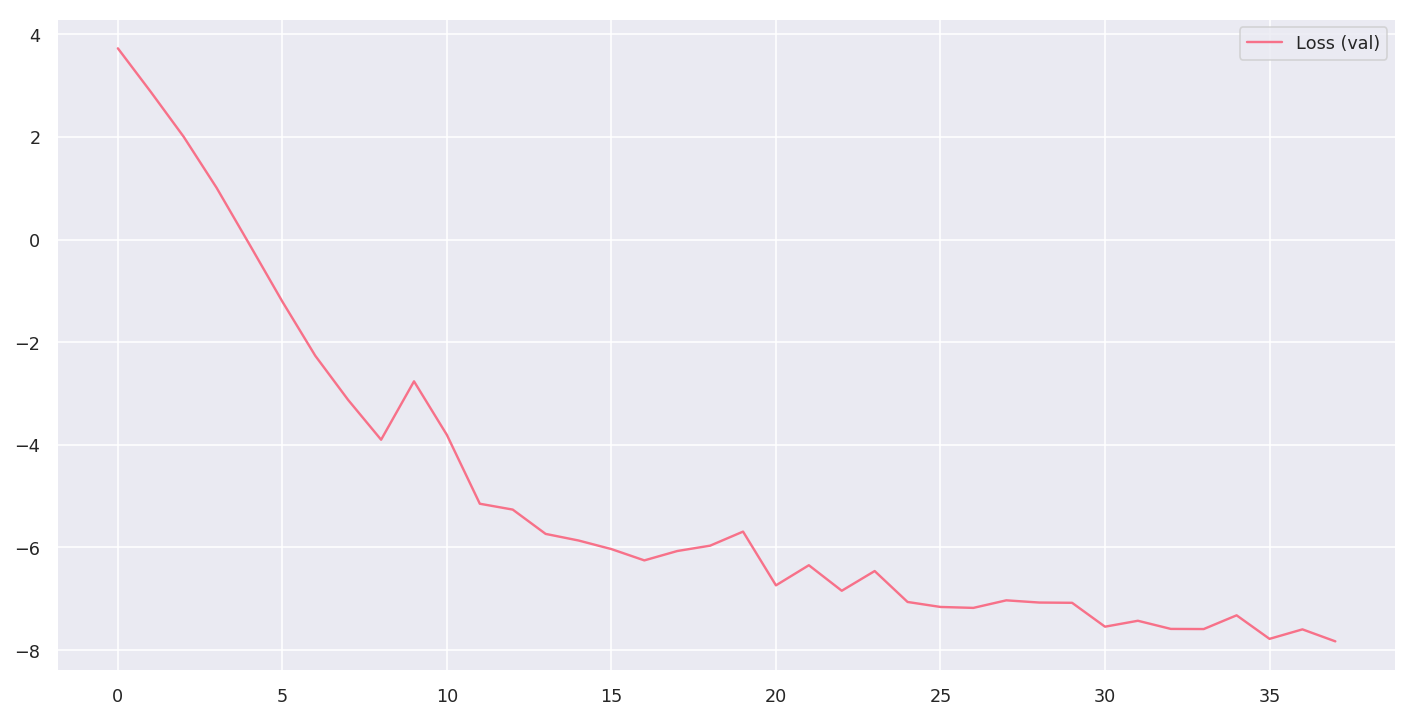

Step: 5966, loss: -7.9061


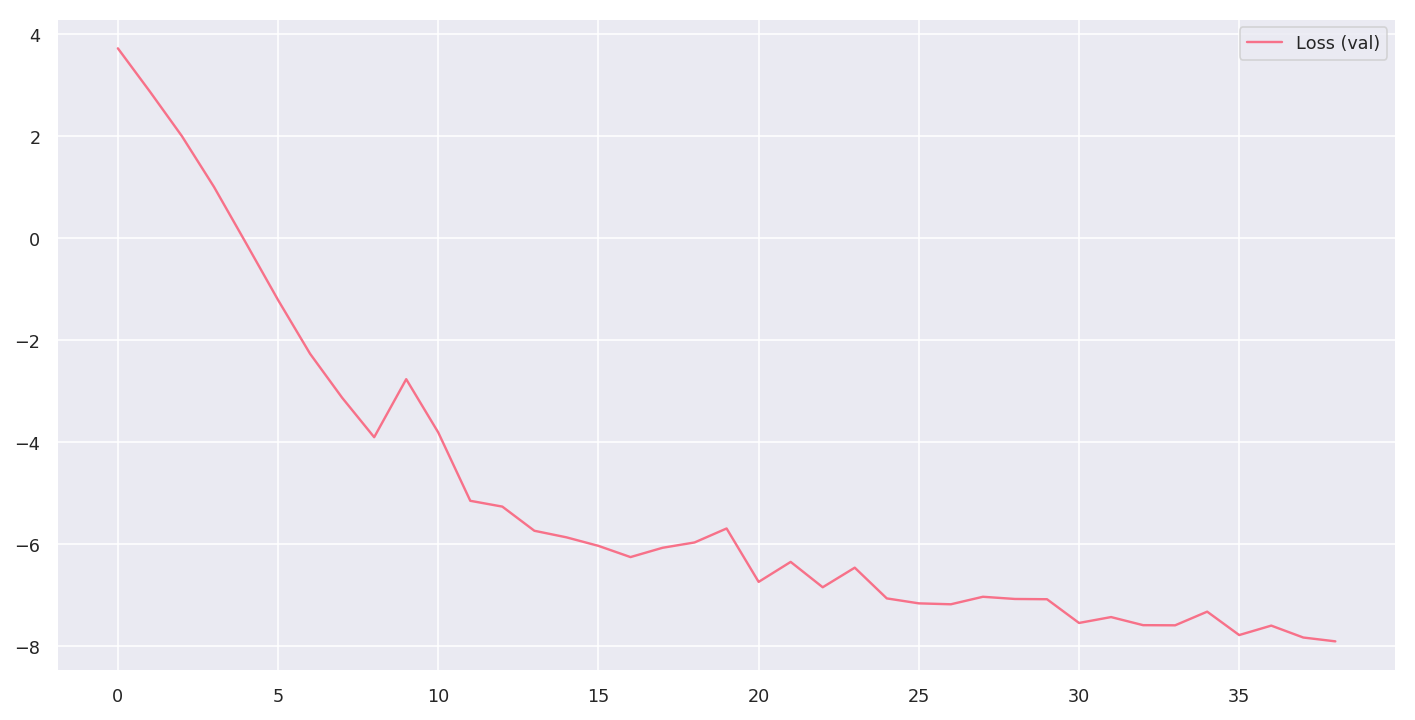

Step: 6123, loss: -8.0203


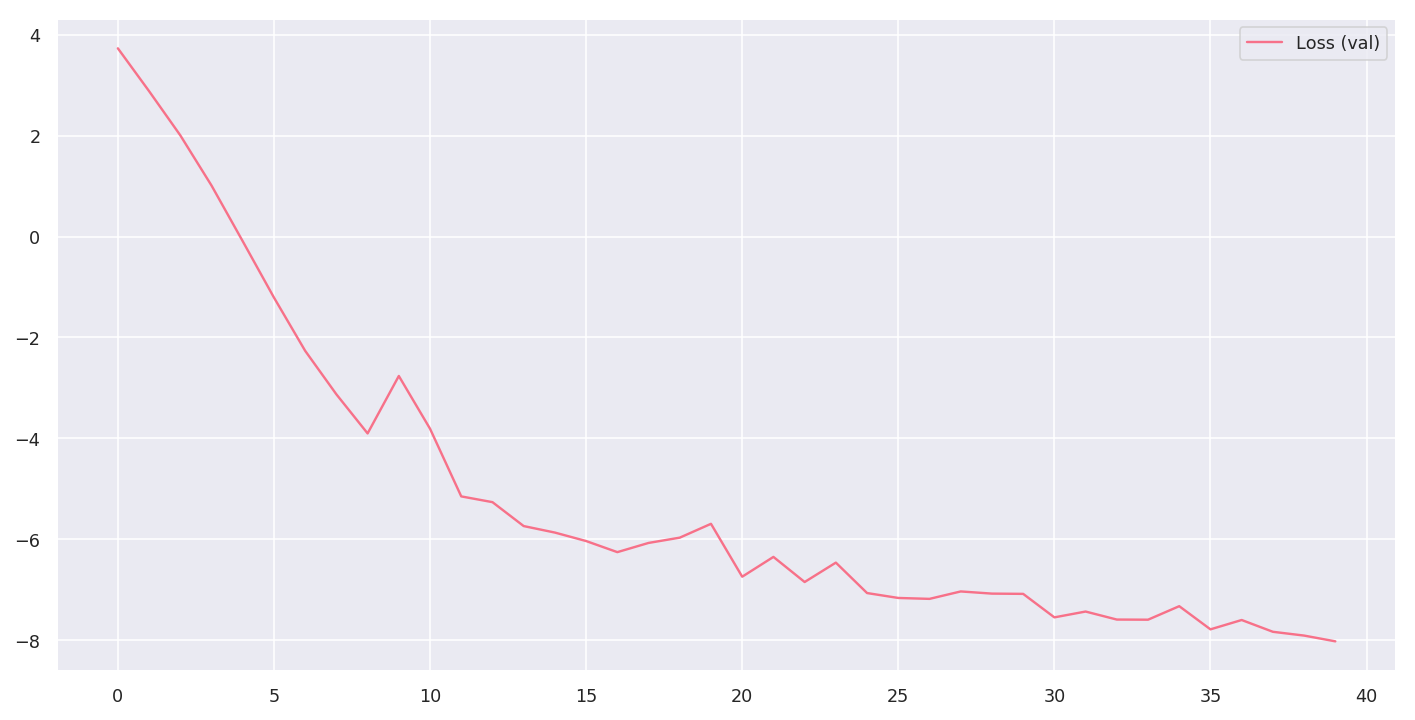

Step: 6280, loss: -8.0835


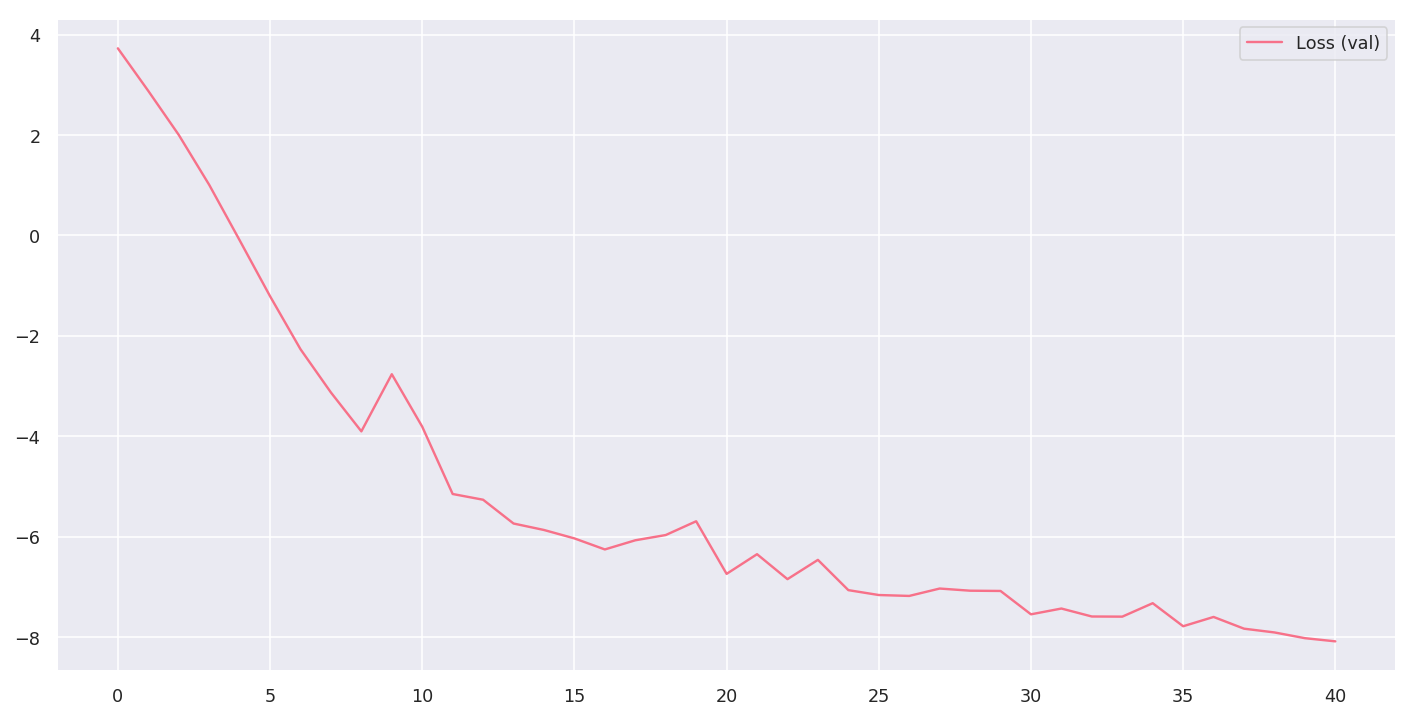

Step: 6437, loss: -7.9762


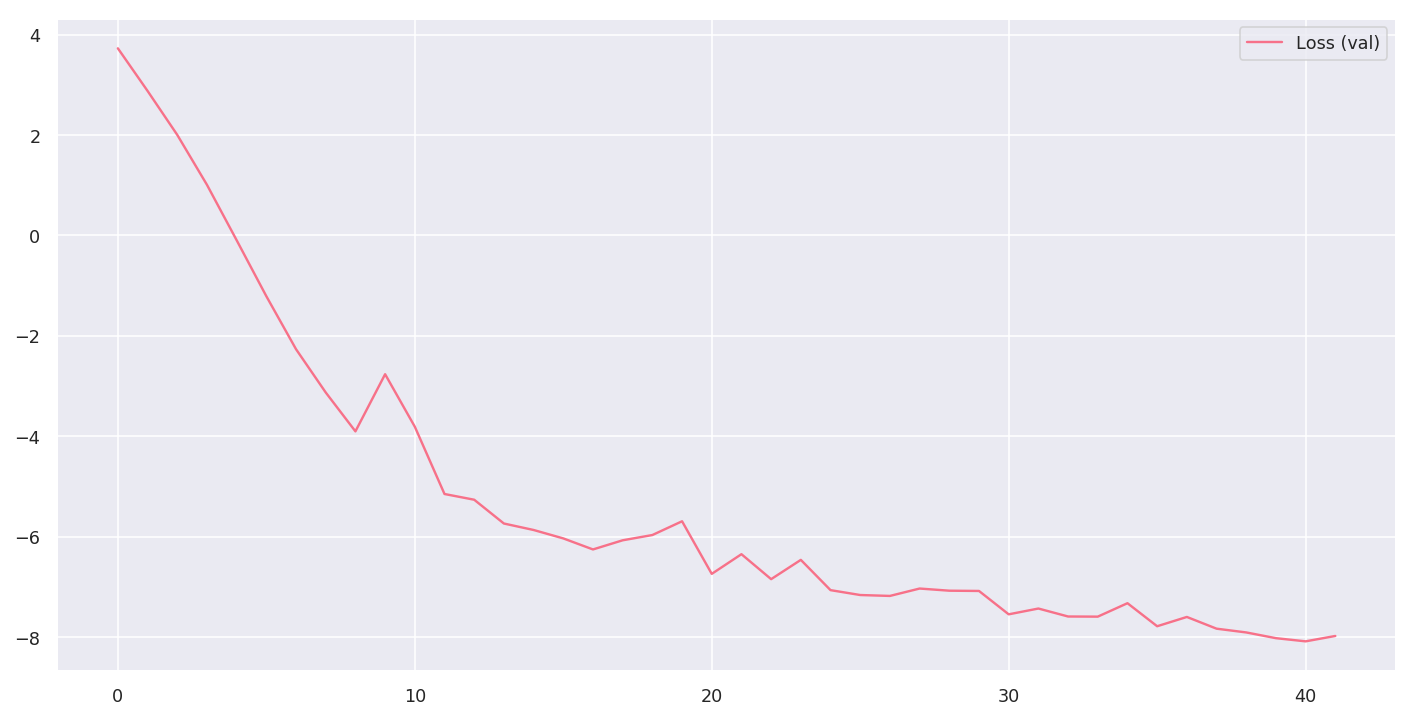

Step: 6594, loss: -8.3278


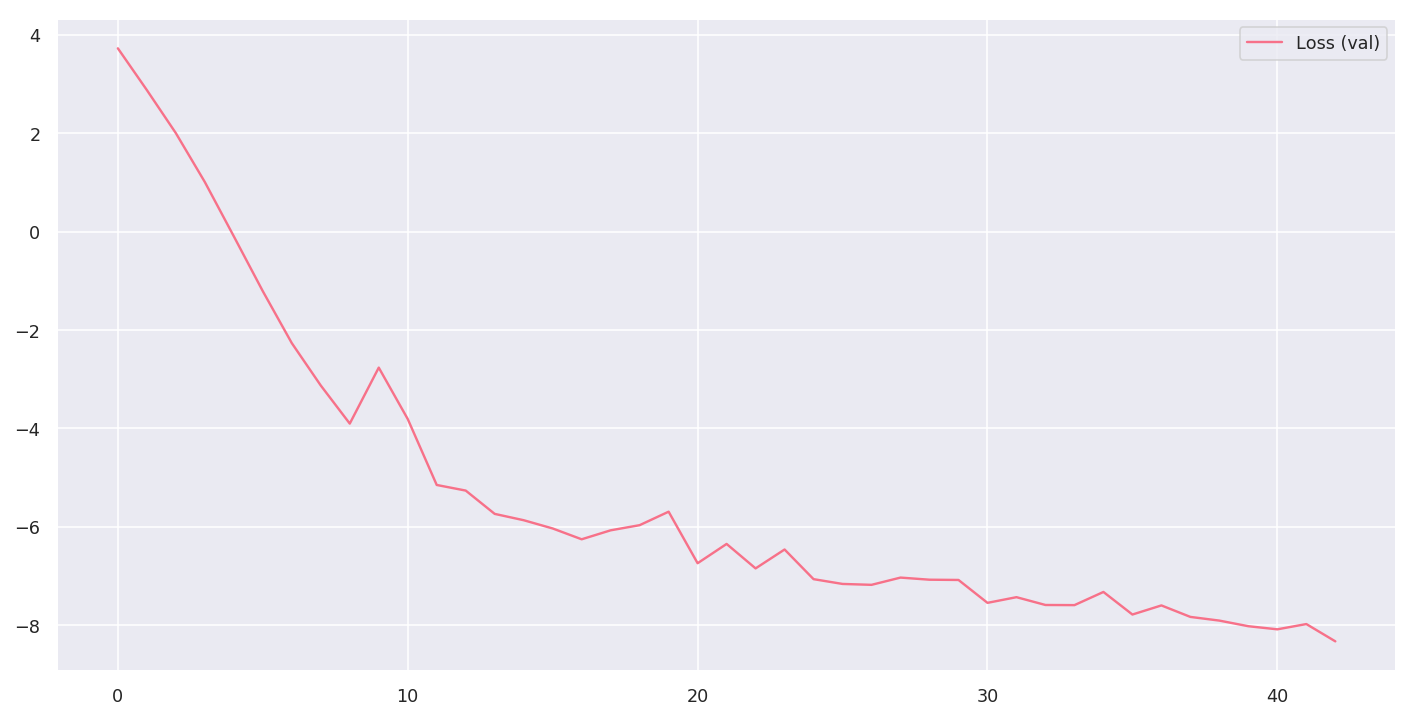

Step: 6751, loss: -8.2860


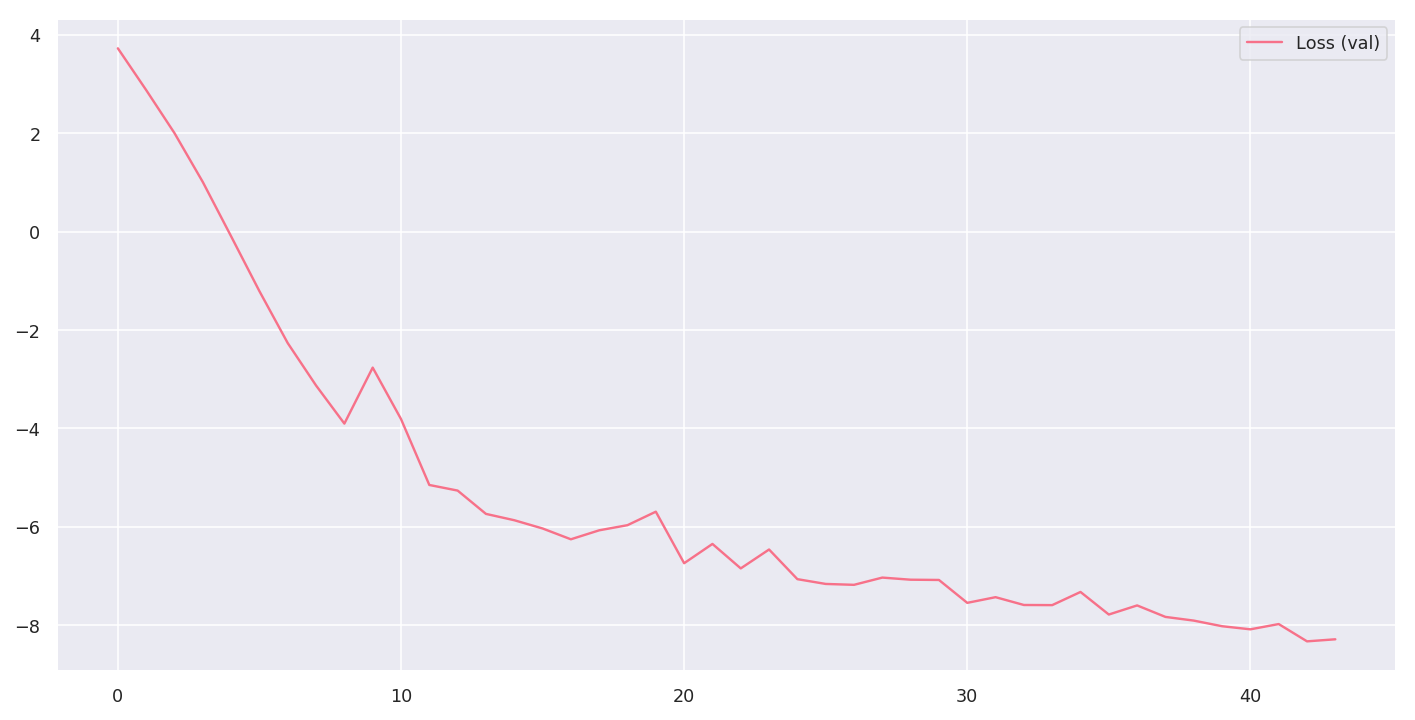

Step: 6908, loss: -2.8449


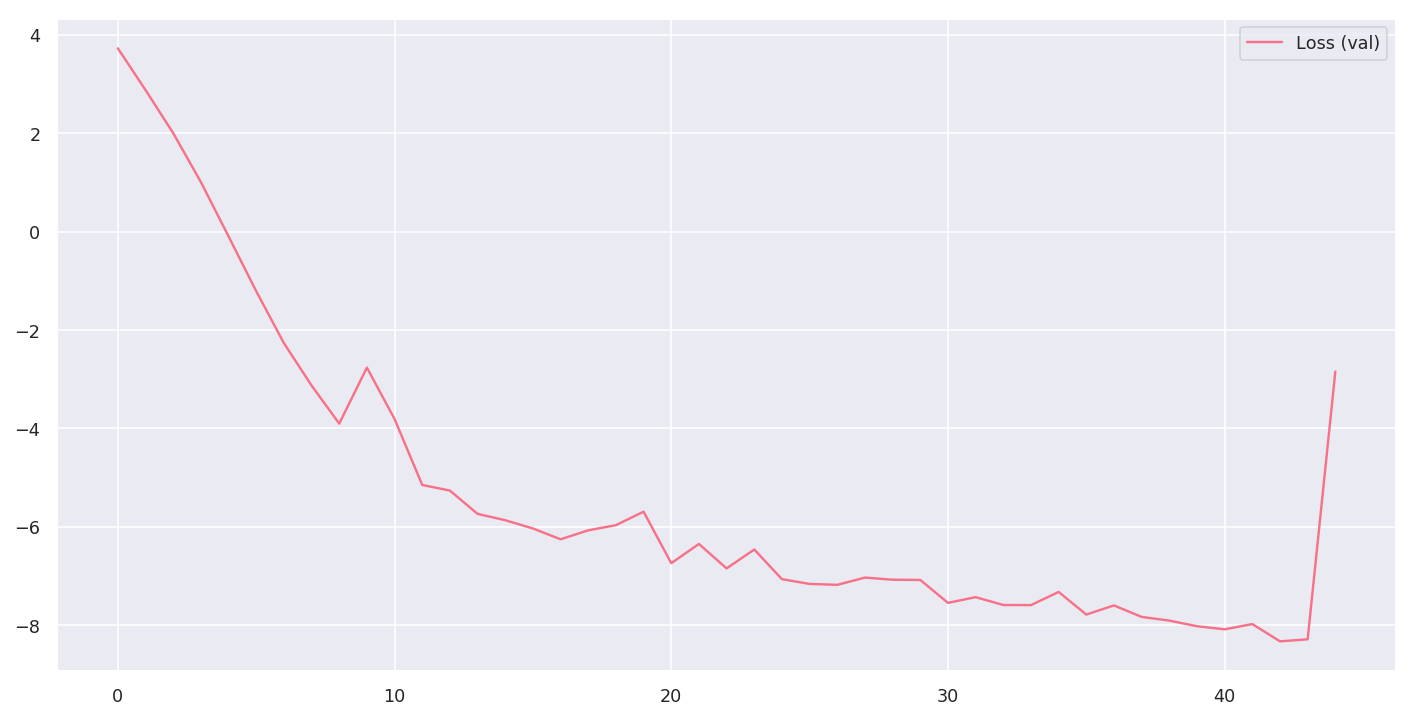

Step: 7065, loss: -8.3611


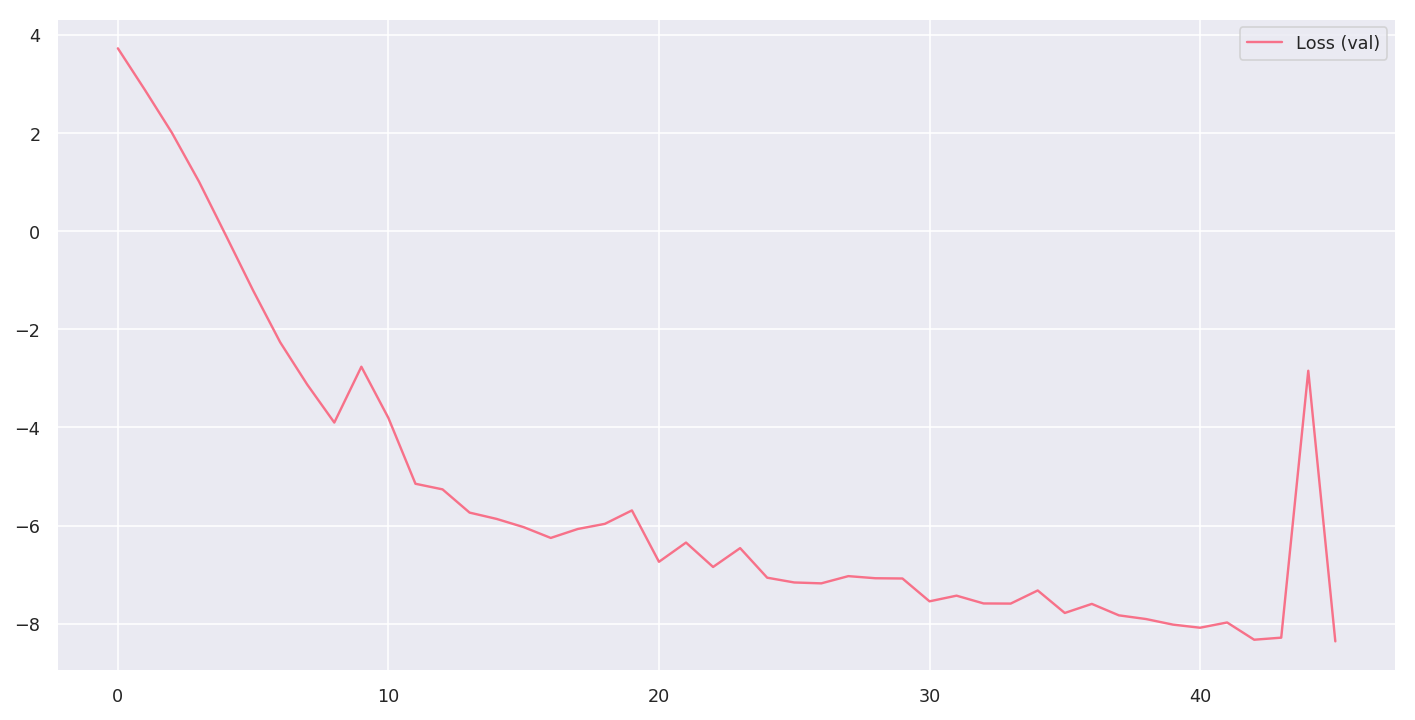

Step: 7222, loss: -8.4482


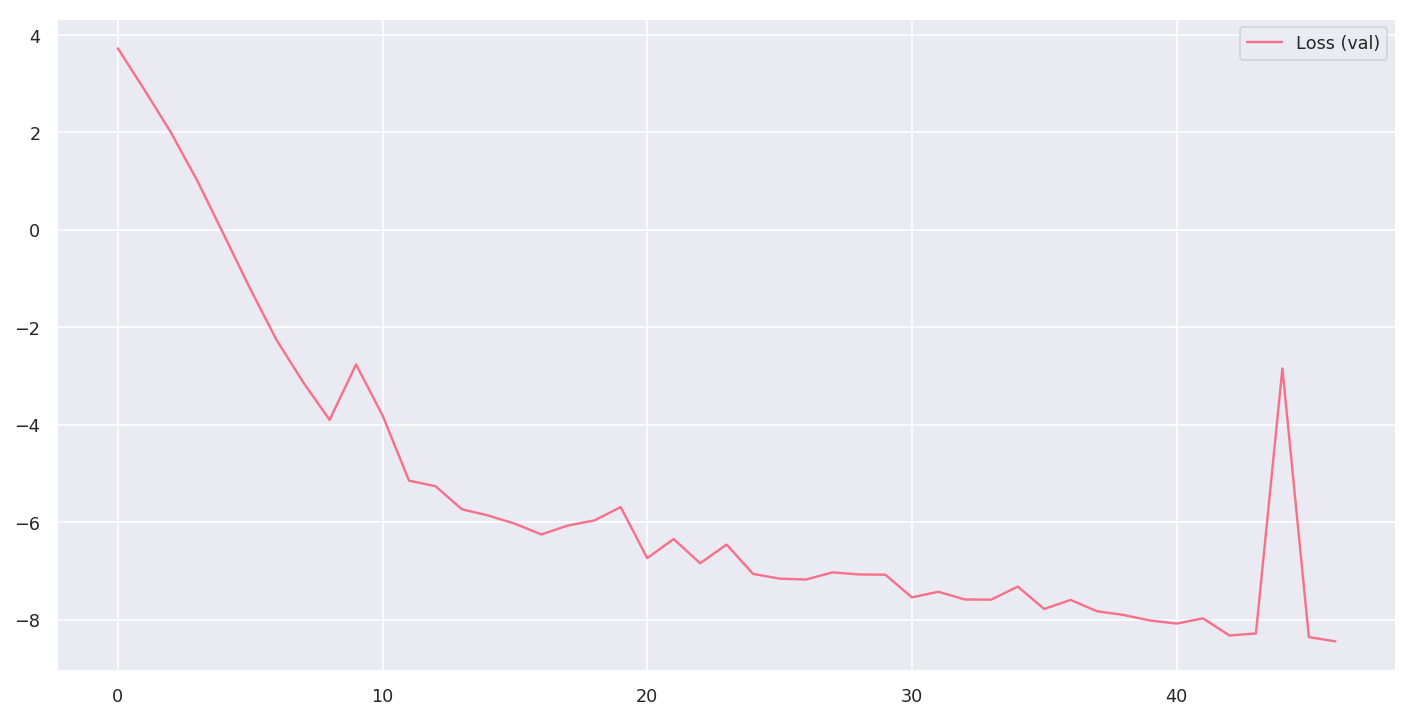

Step: 7379, loss: -8.2093


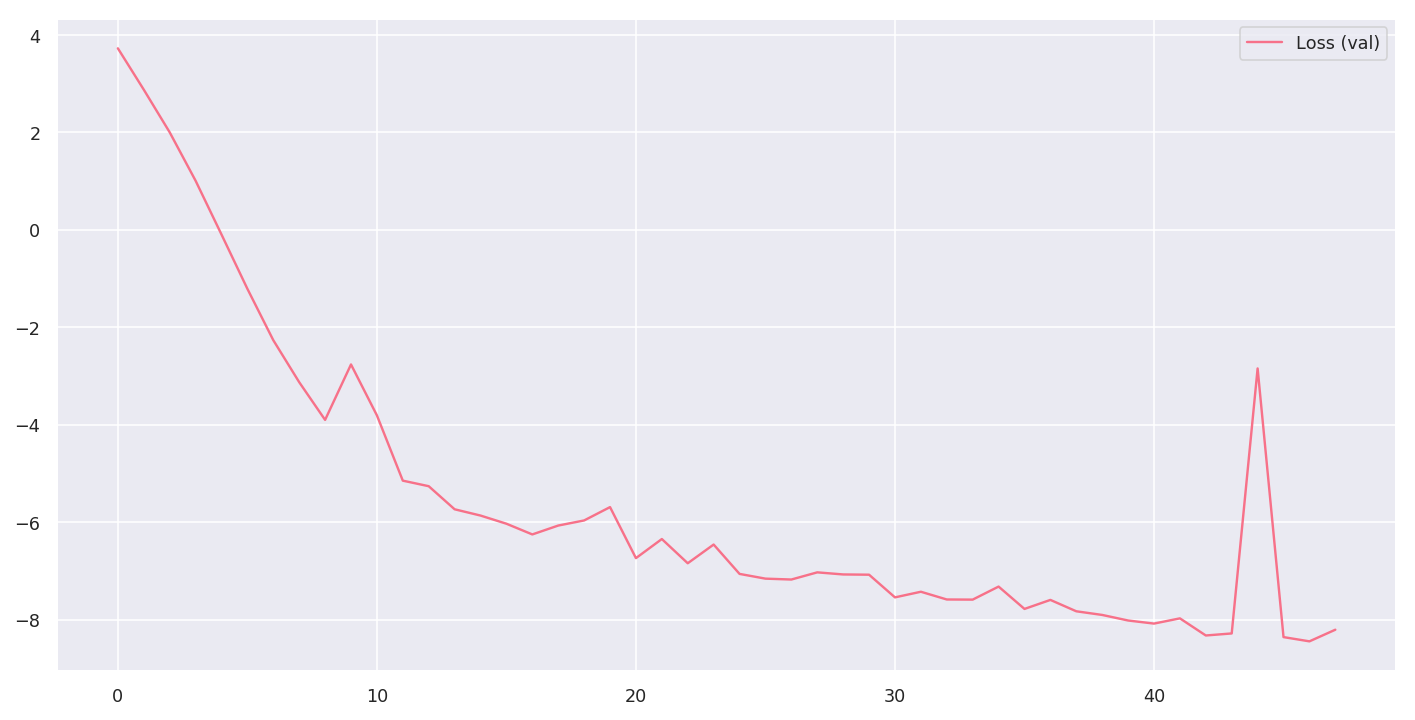

Step: 7536, loss: -8.4809


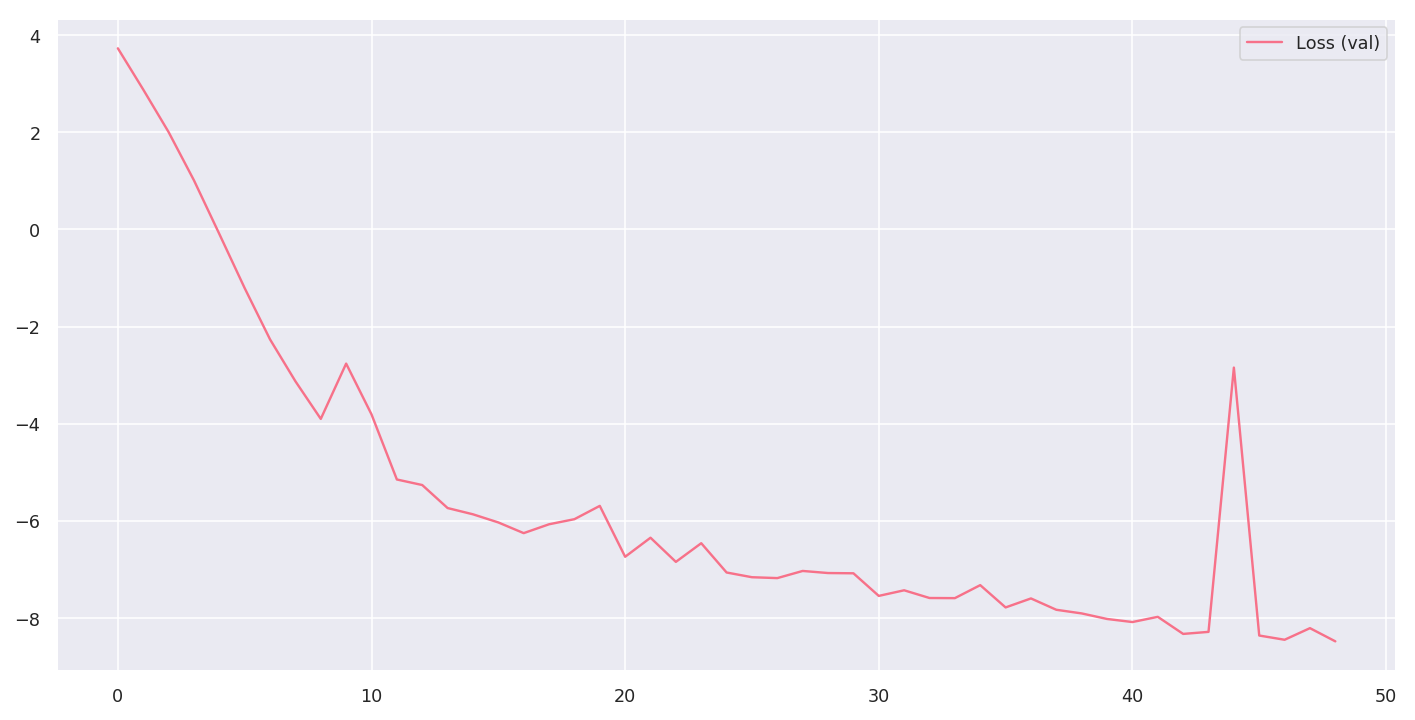

Step: 7693, loss: -8.6884


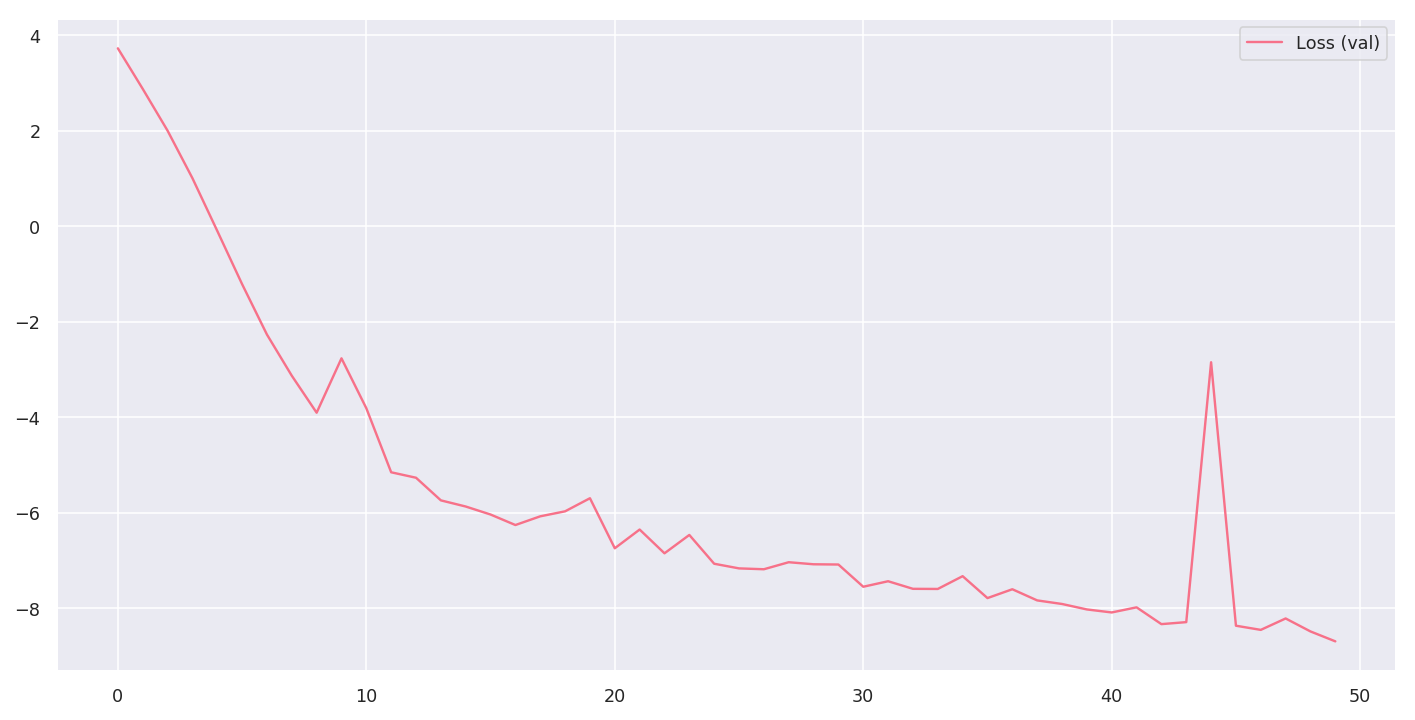

Step: 7850, loss: -8.7233


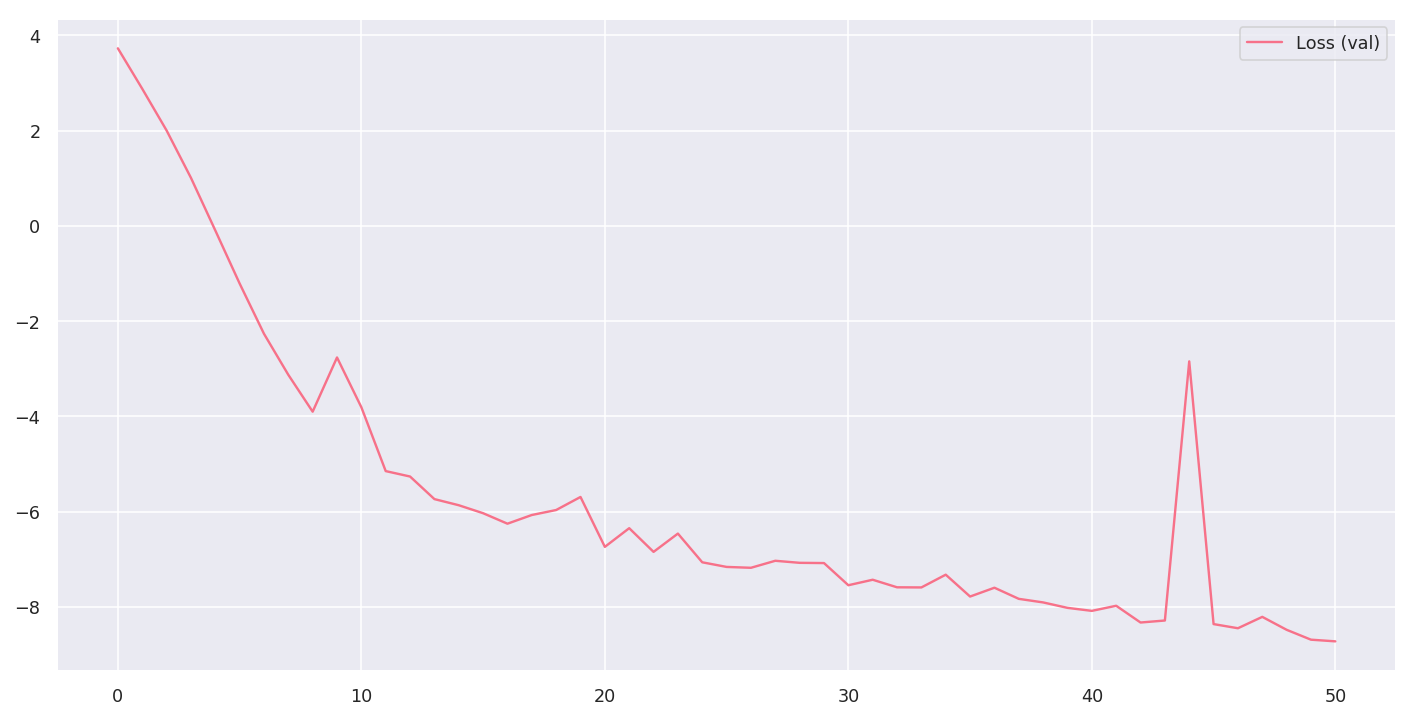

Step: 8007, loss: -8.5063


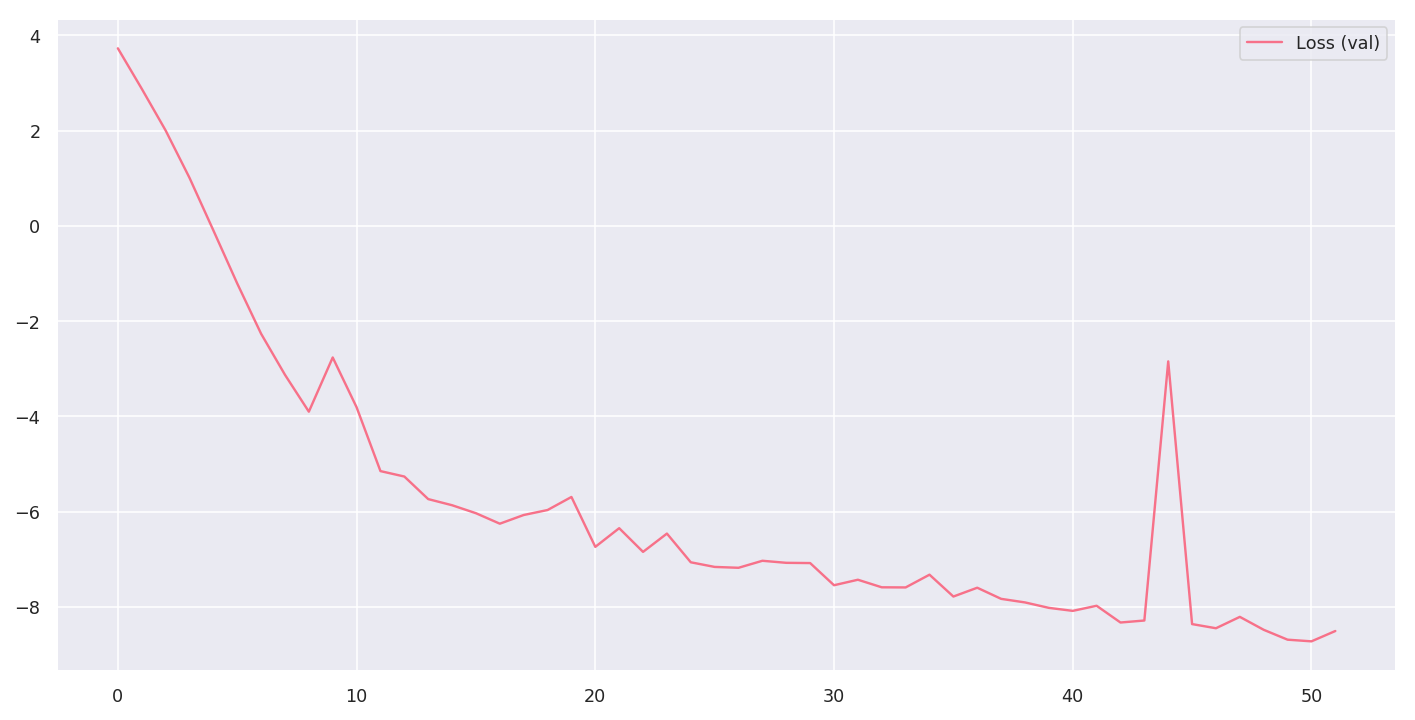

Step: 8164, loss: -8.7328


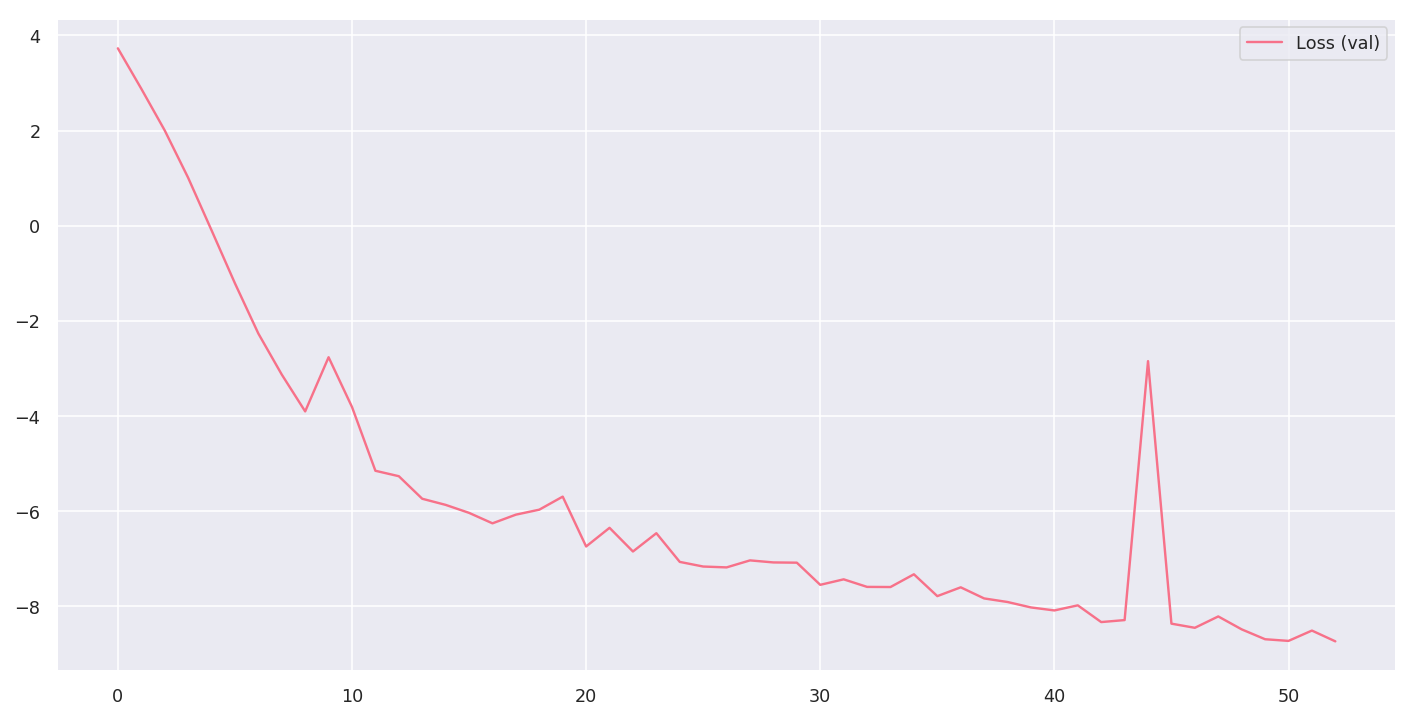

Step: 8321, loss: -8.3922


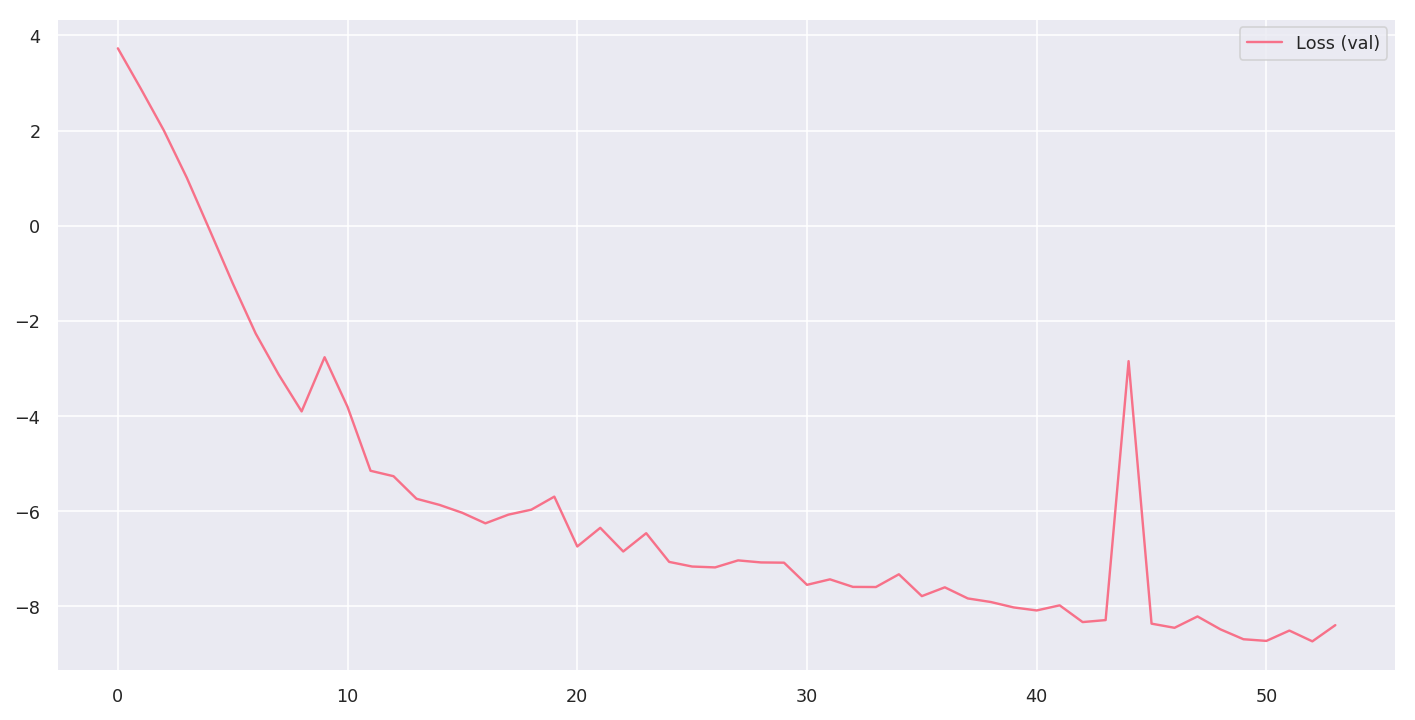

Step: 8478, loss: -8.8369


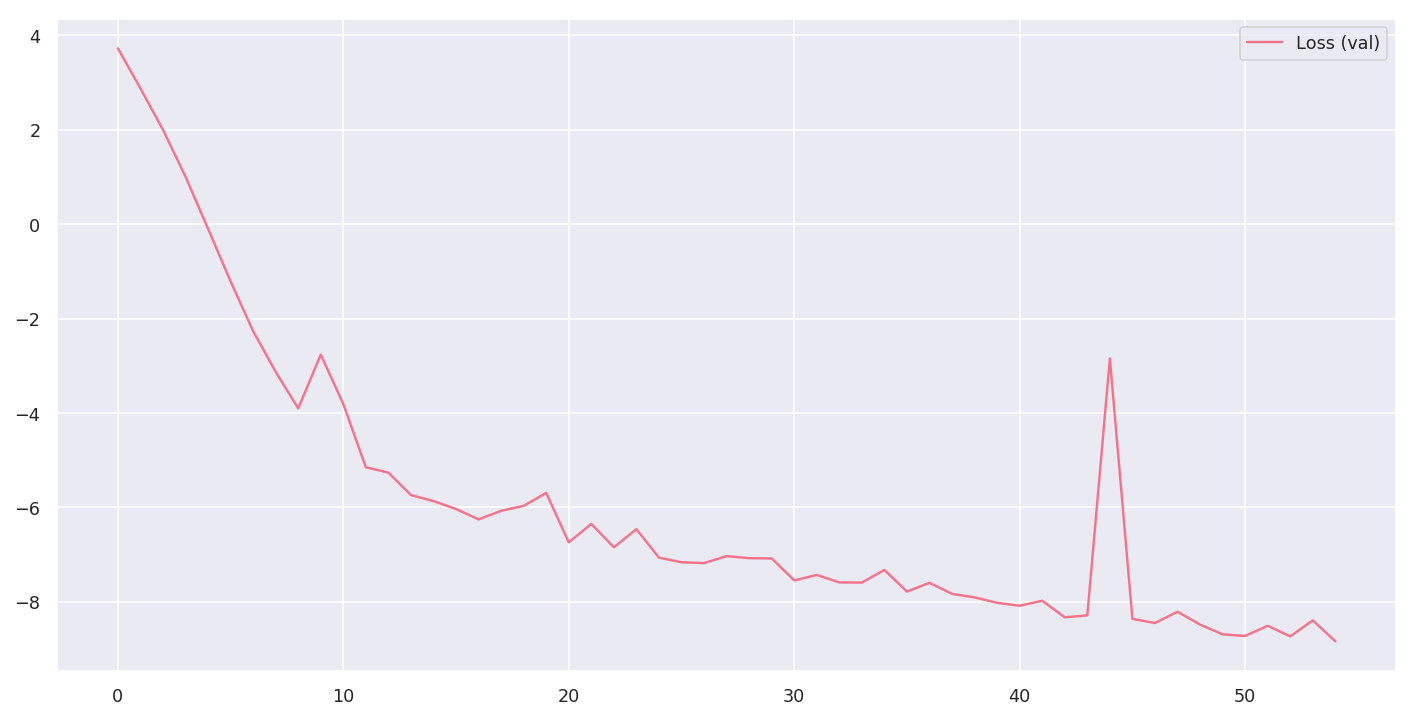

Step: 8635, loss: -8.8827


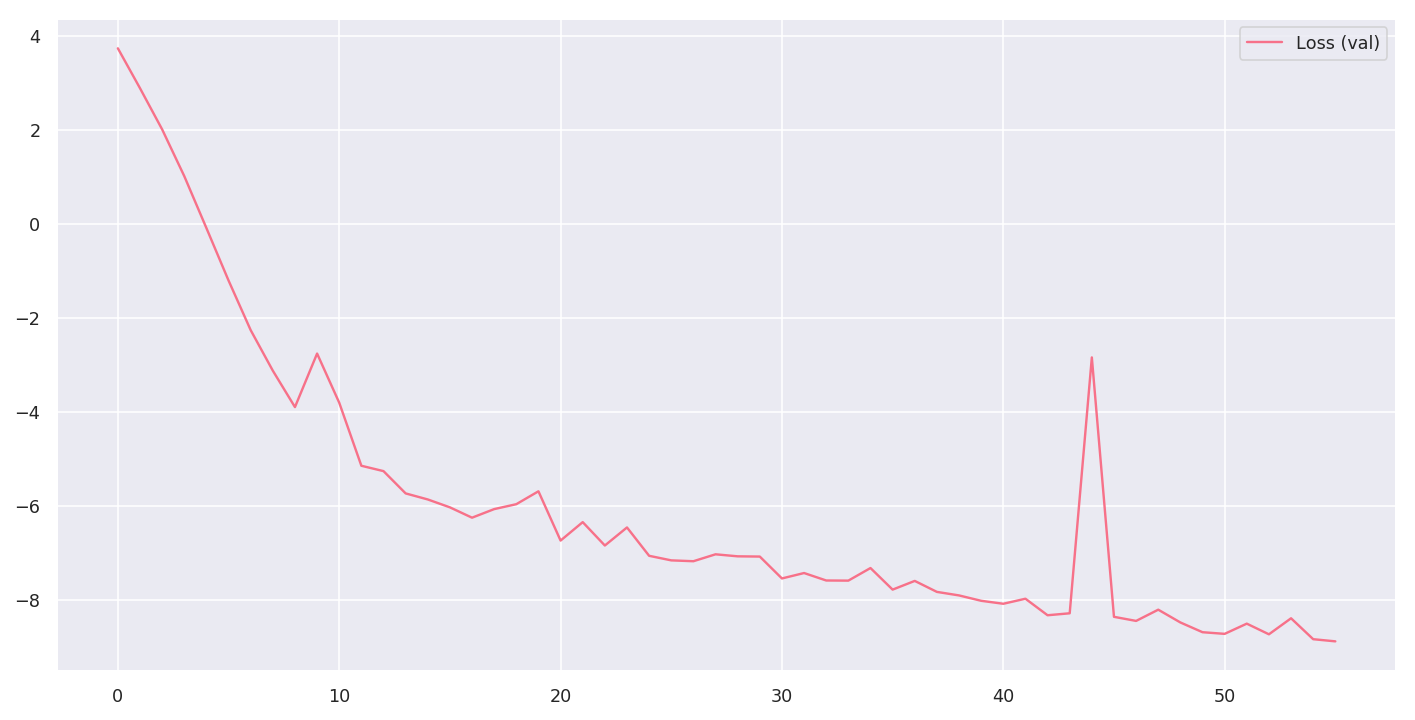

Step: 8792, loss: -9.0105


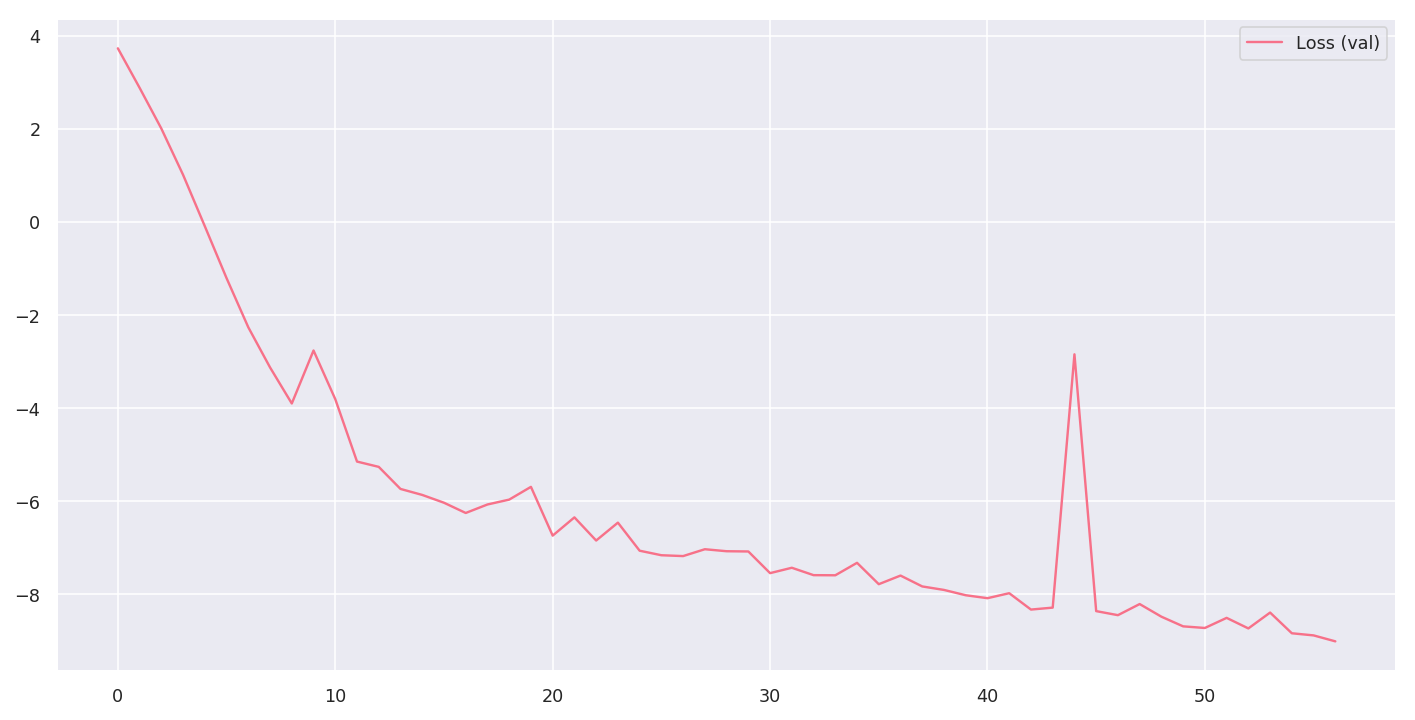

Step: 8949, loss: -8.8963


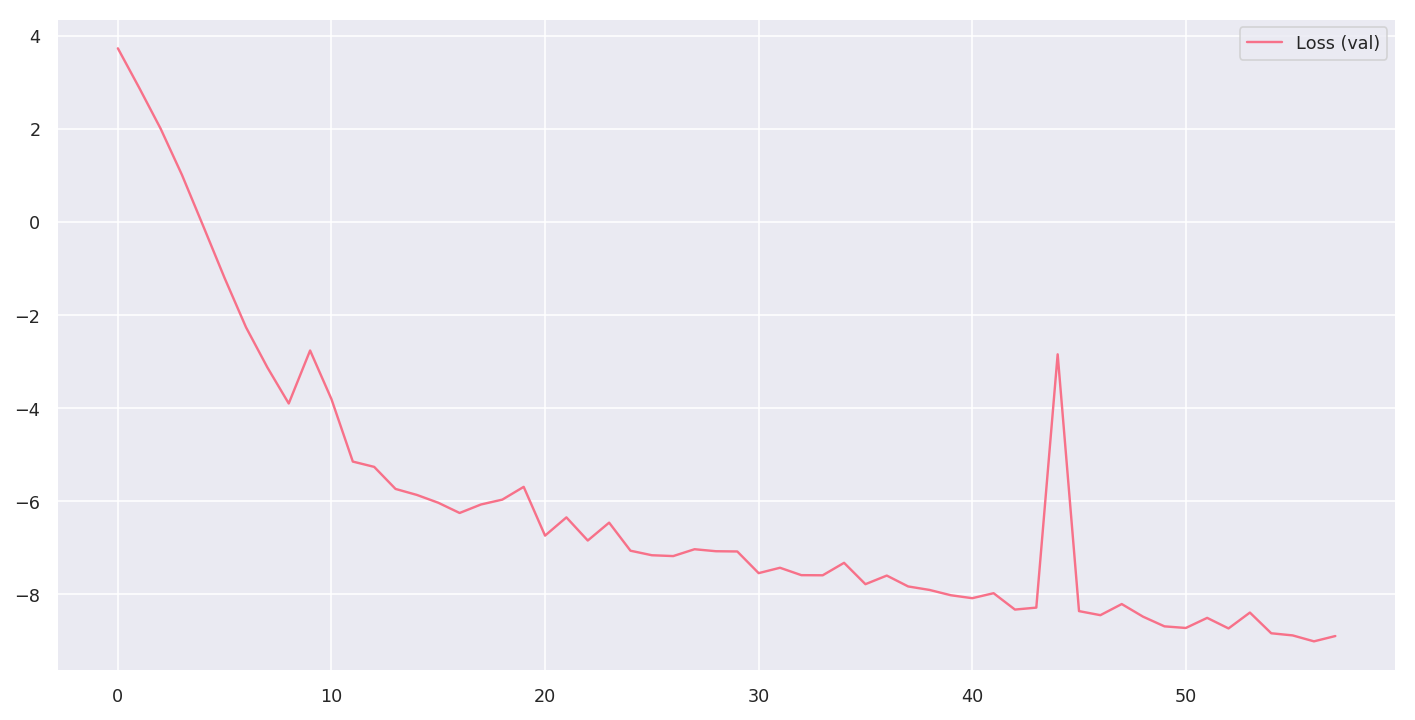

Step: 9106, loss: -9.0947


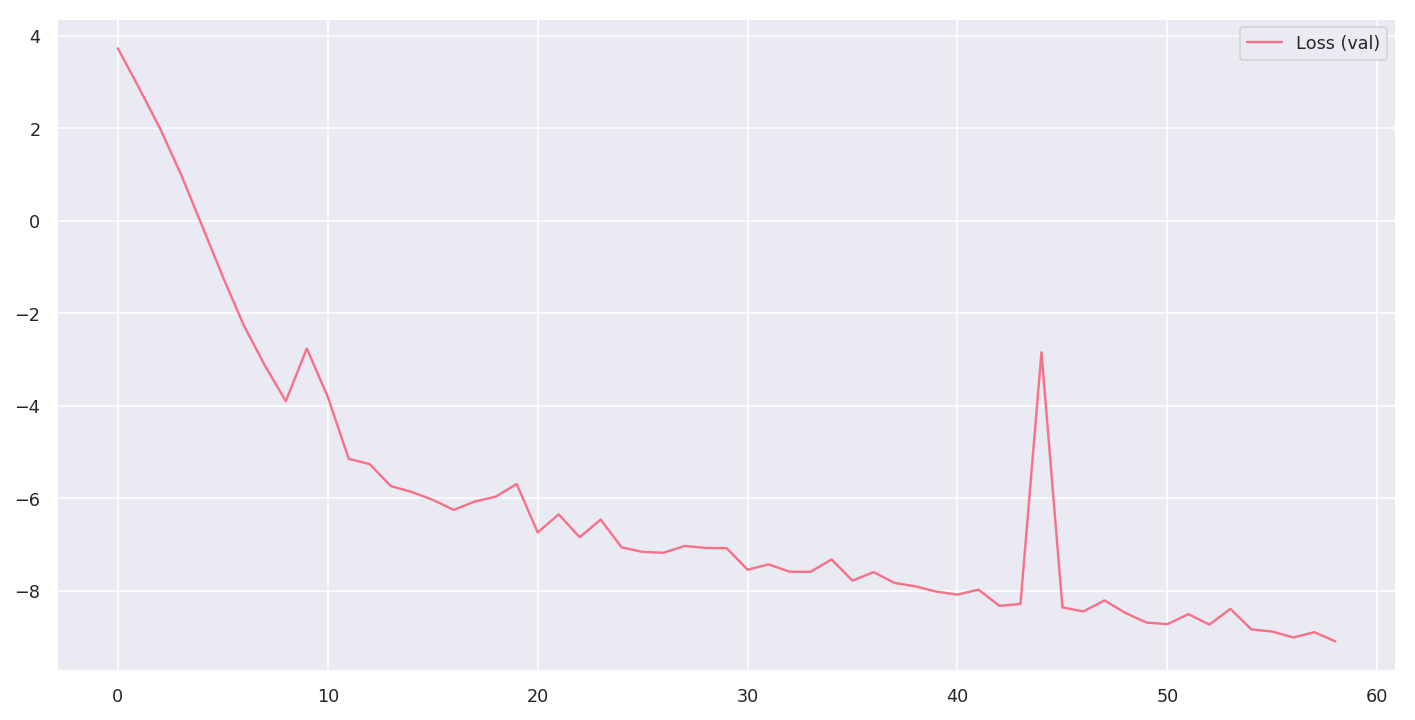

Step: 9263, loss: -9.1036


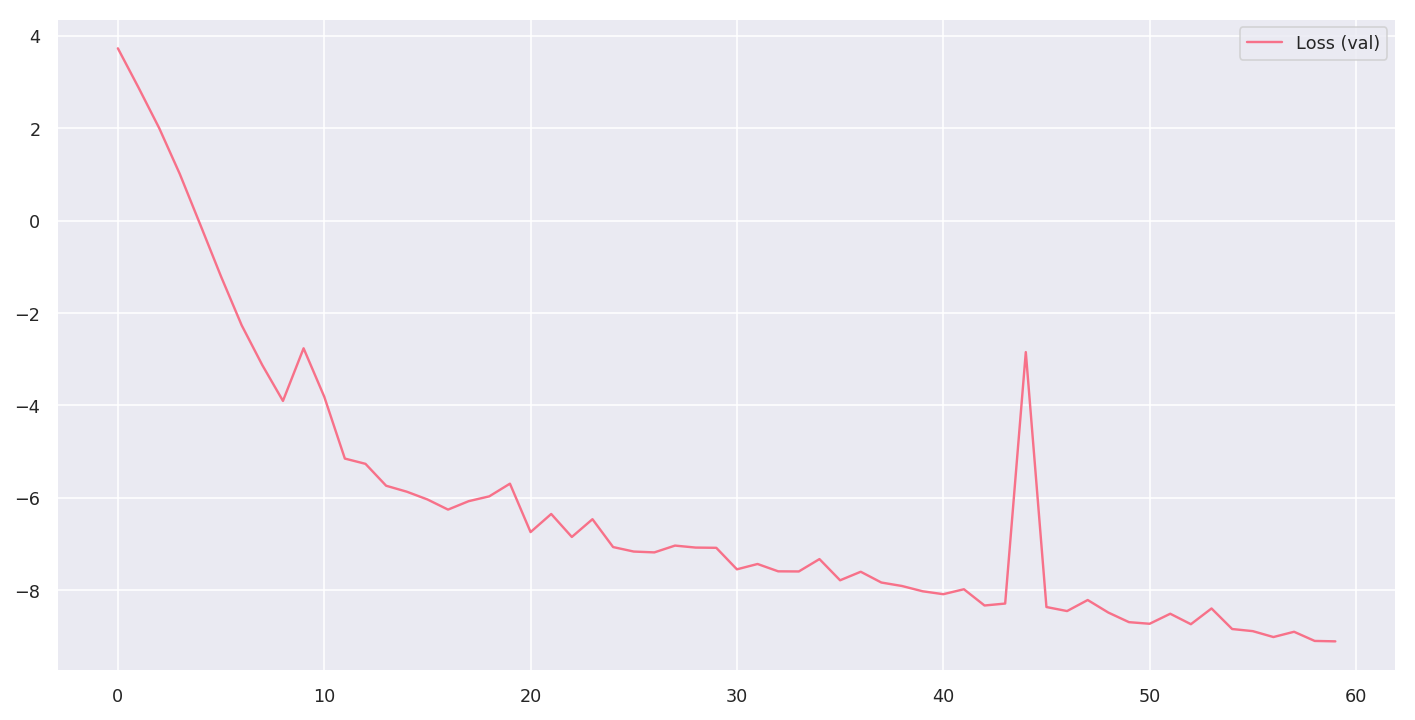

Step: 9420, loss: -9.0896


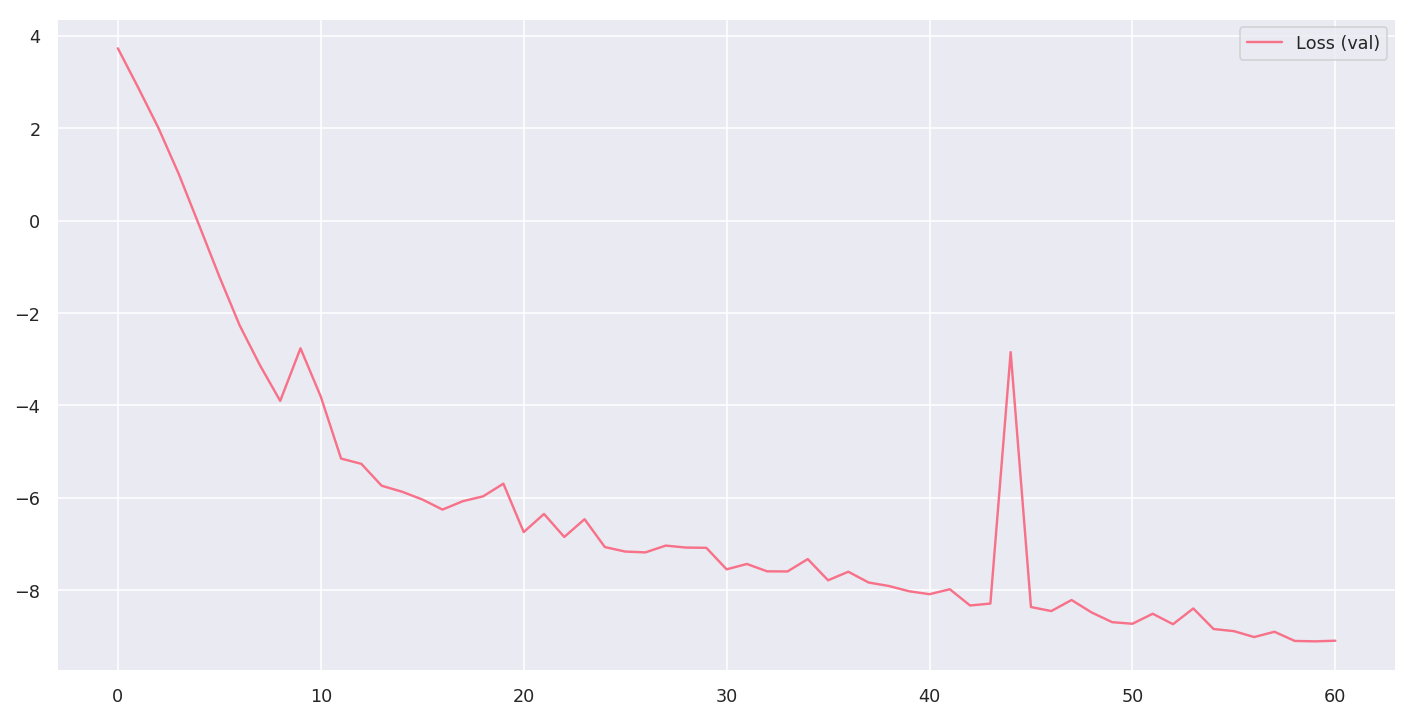

Step: 9577, loss: -9.1682


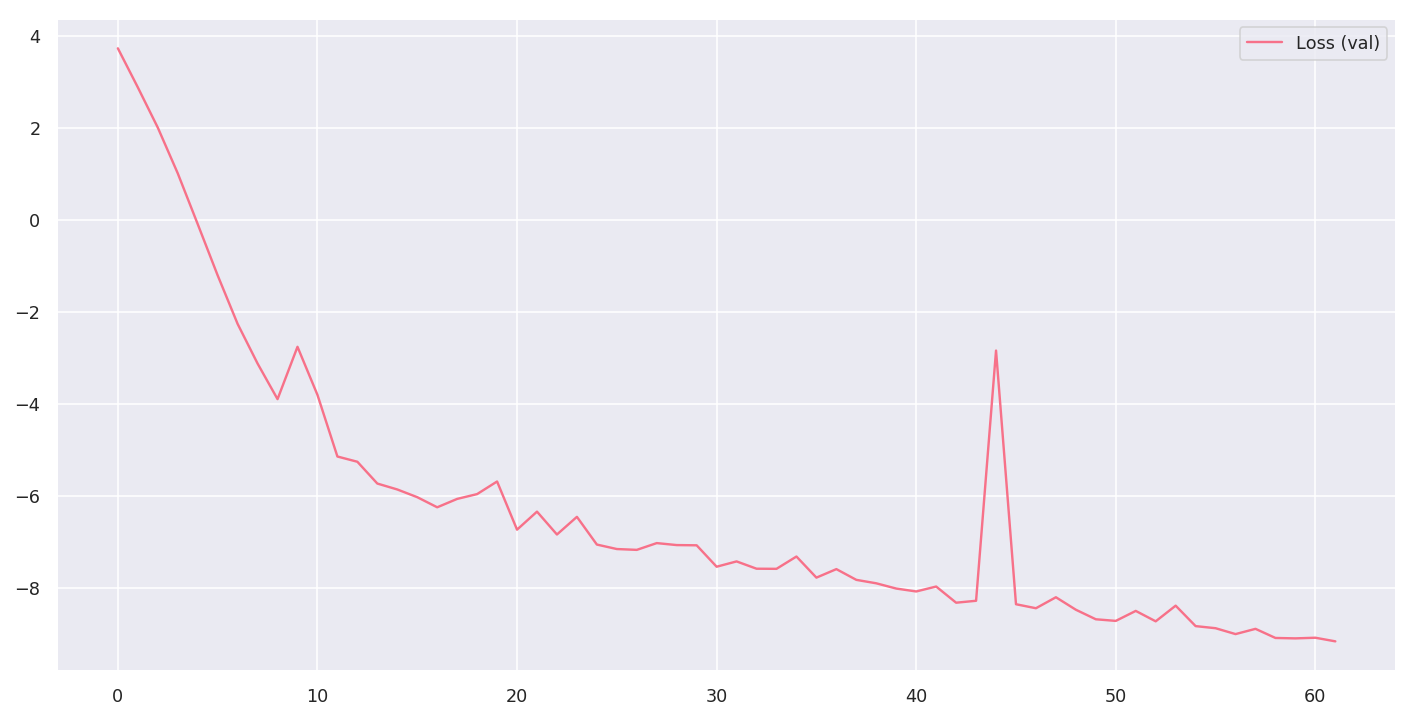

Step: 9734, loss: -9.2298


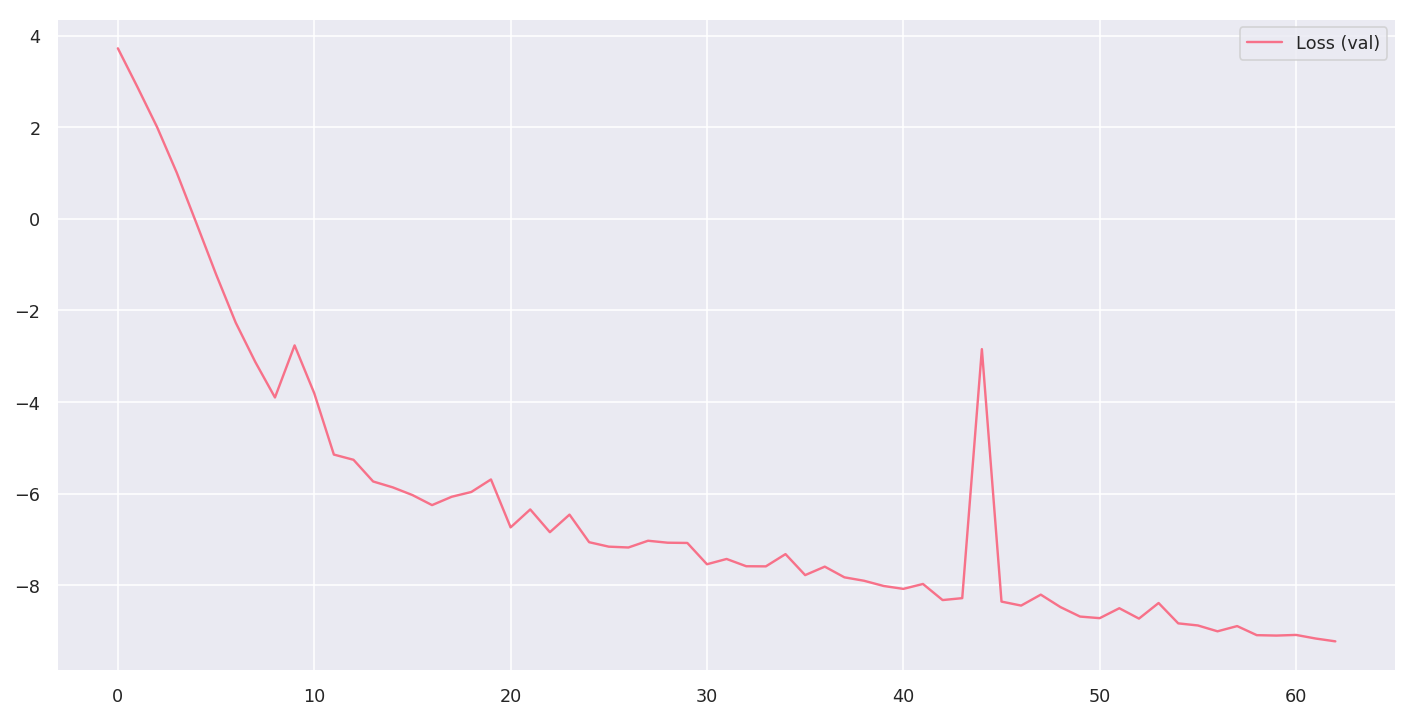

Step: 9891, loss: -9.1894


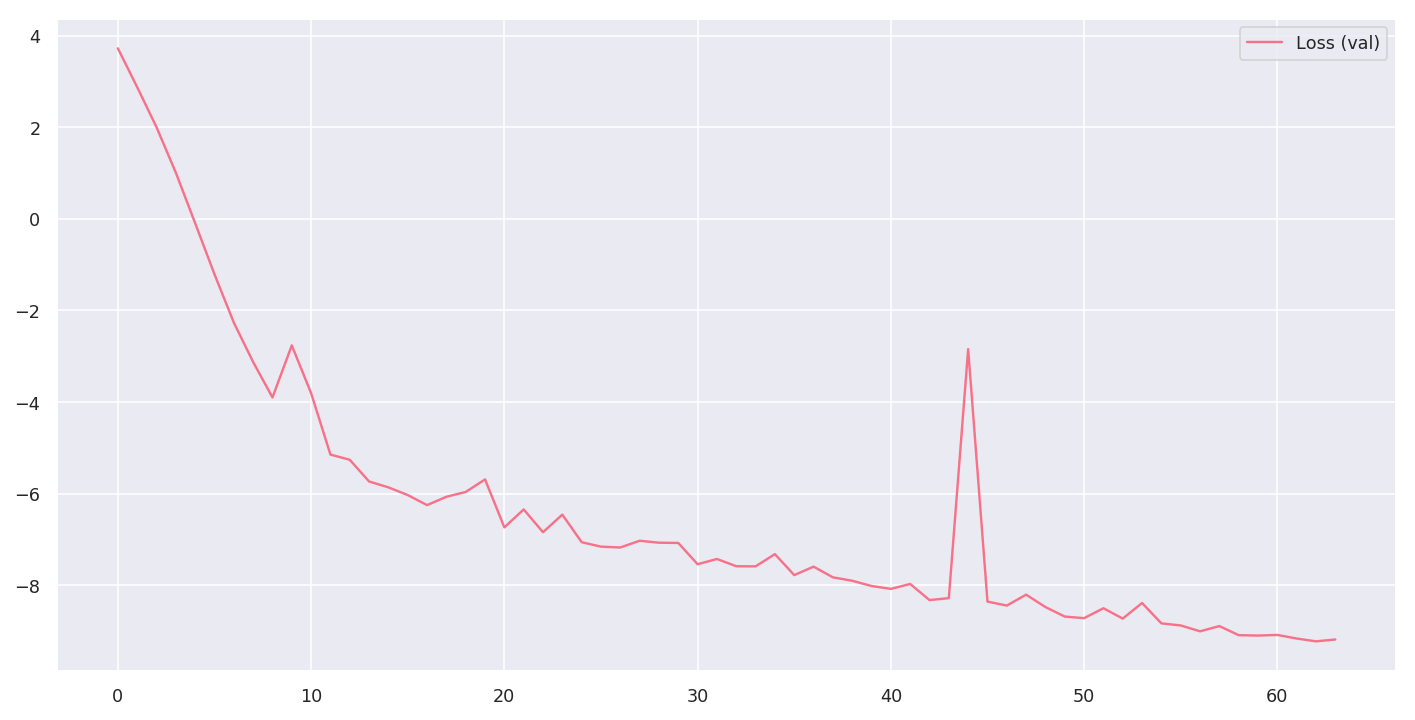

Step: 10048, loss: -9.2250


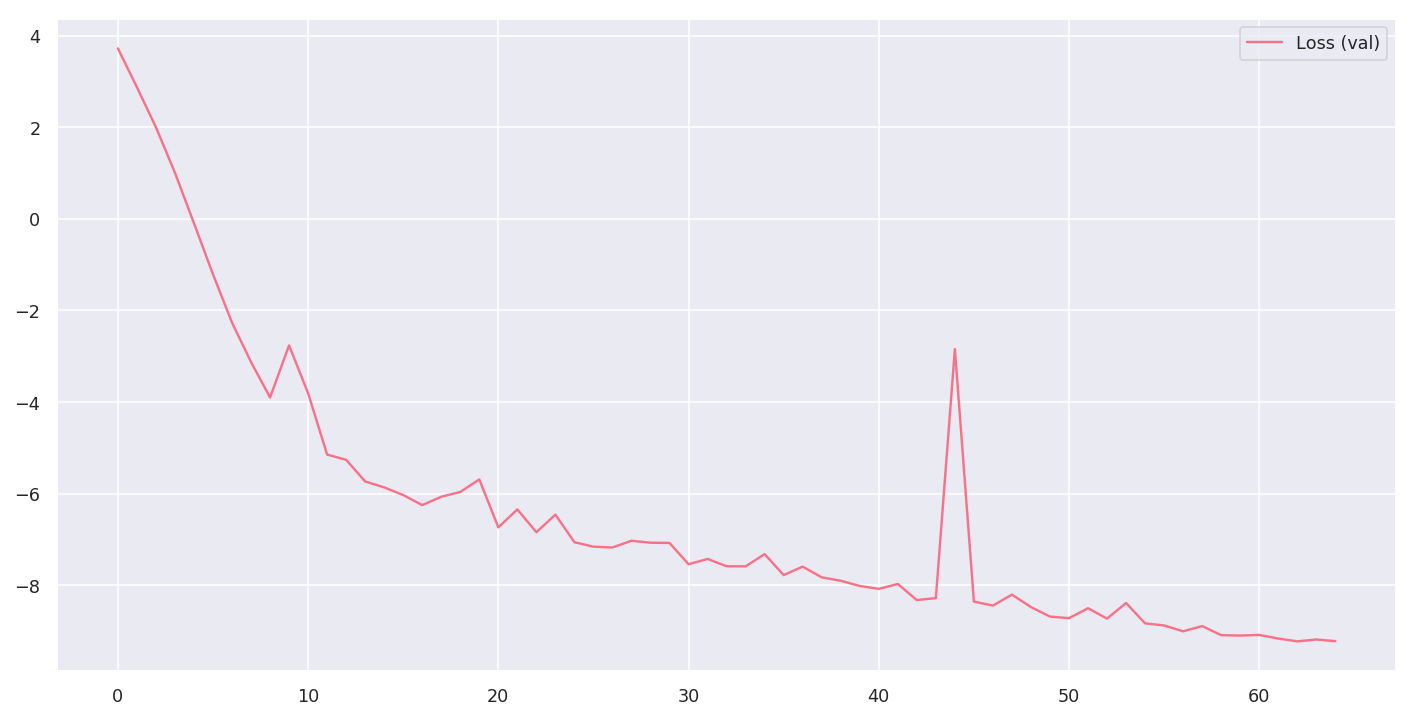

Step: 10205, loss: -9.3665


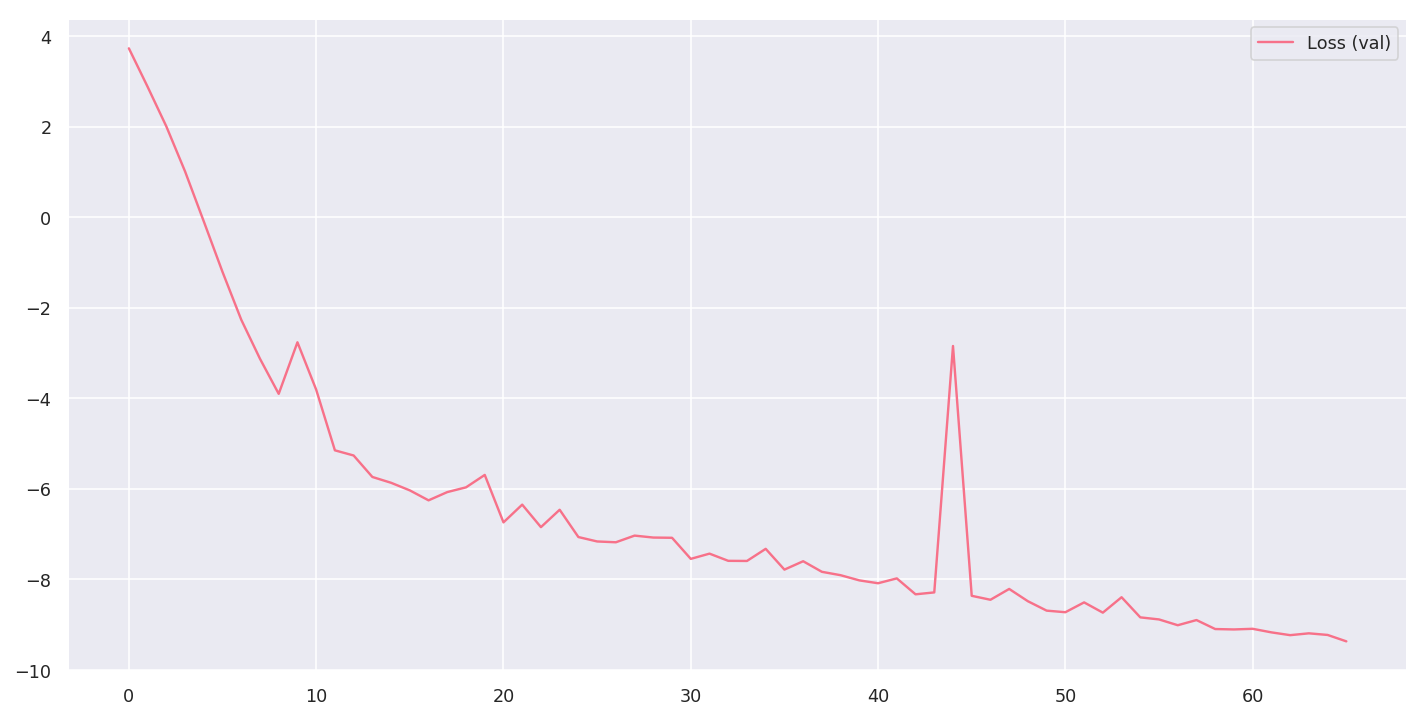

Step: 10362, loss: -9.3609


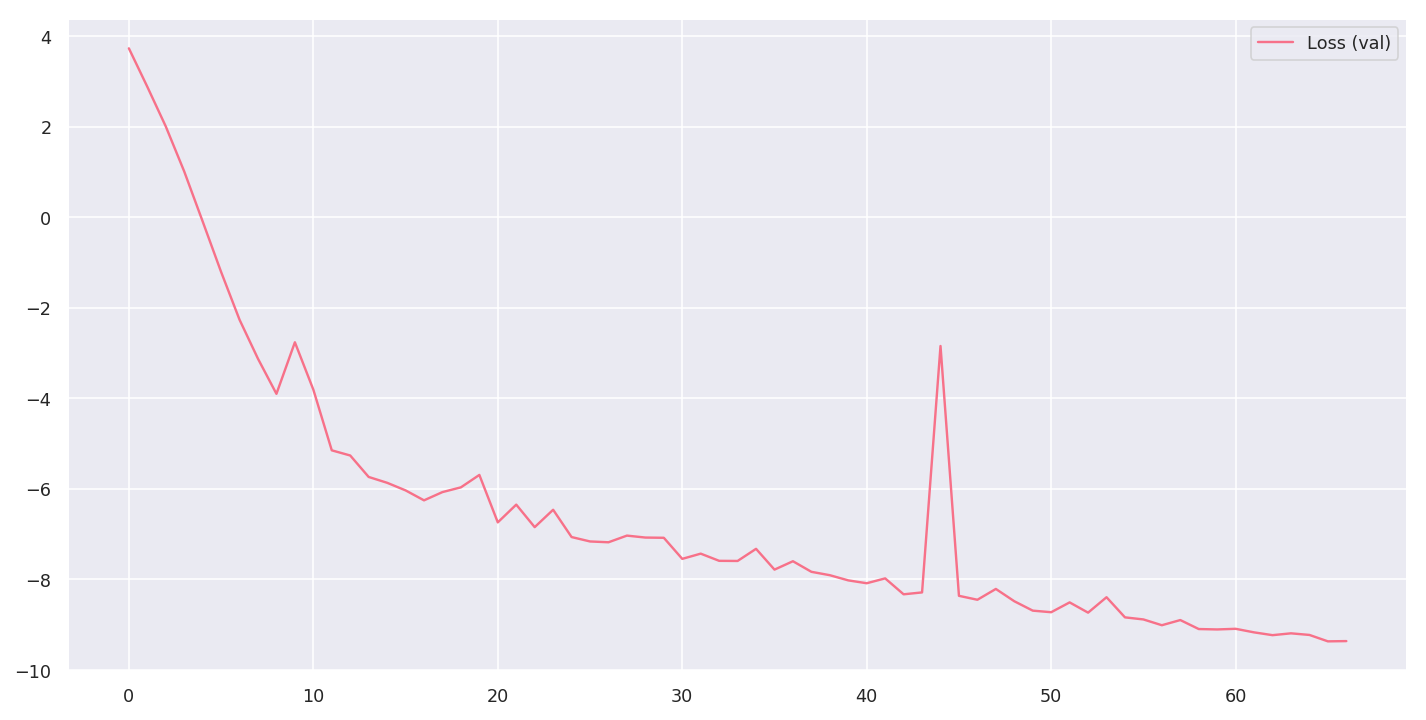

Step: 10519, loss: -9.4200


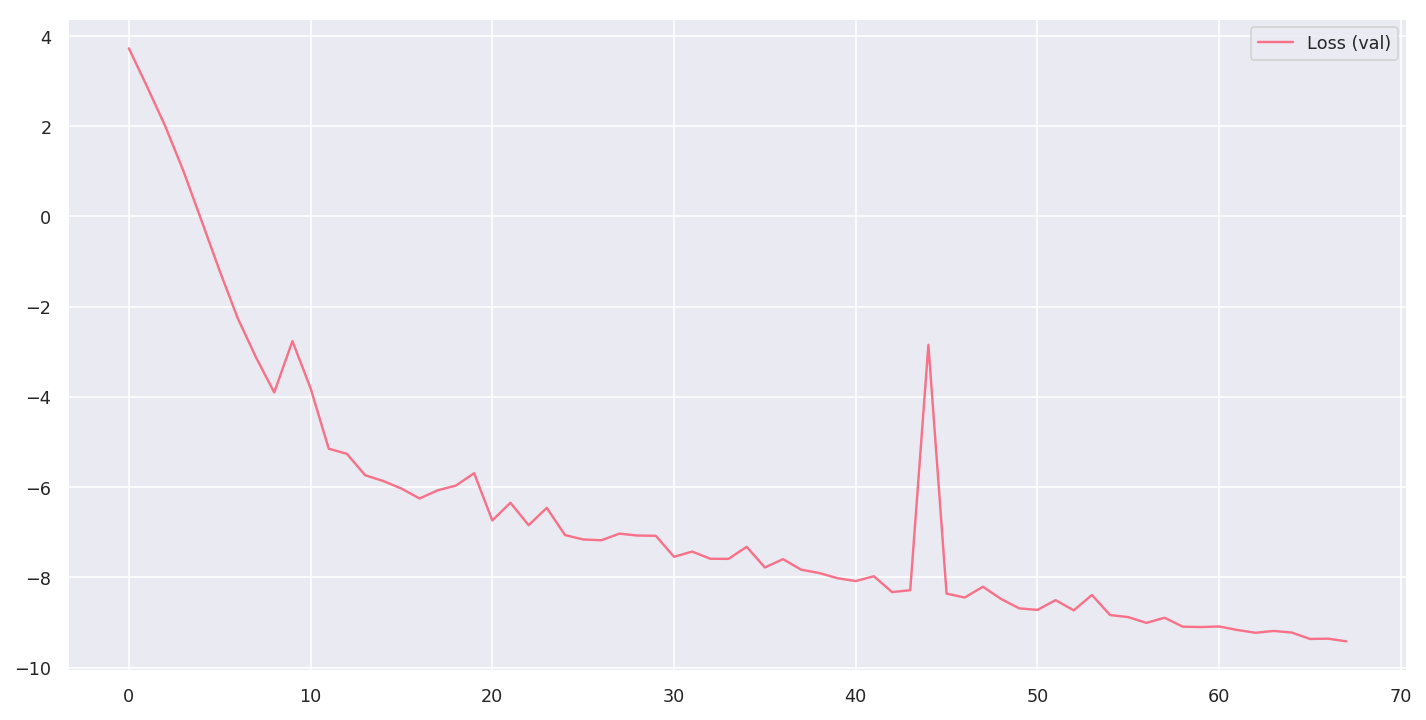

Step: 10676, loss: -9.1270


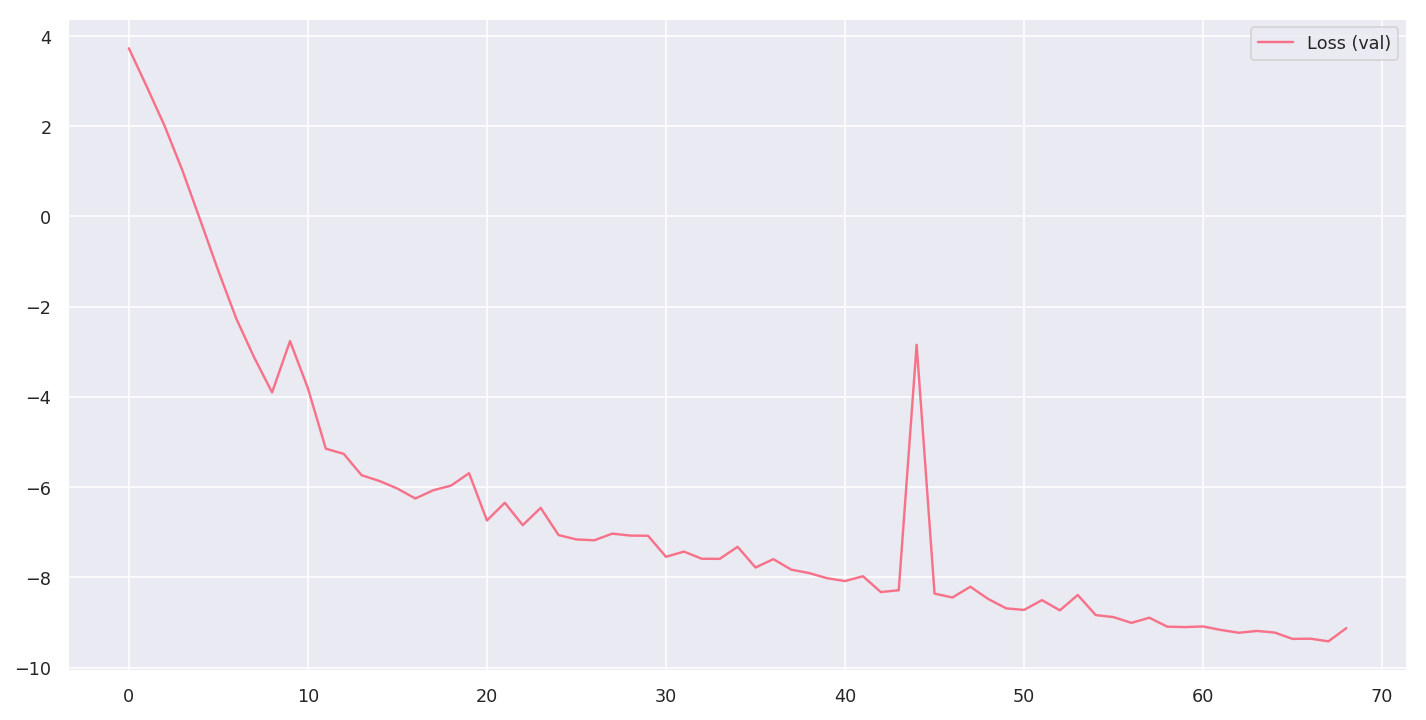

Step: 10833, loss: -9.3197


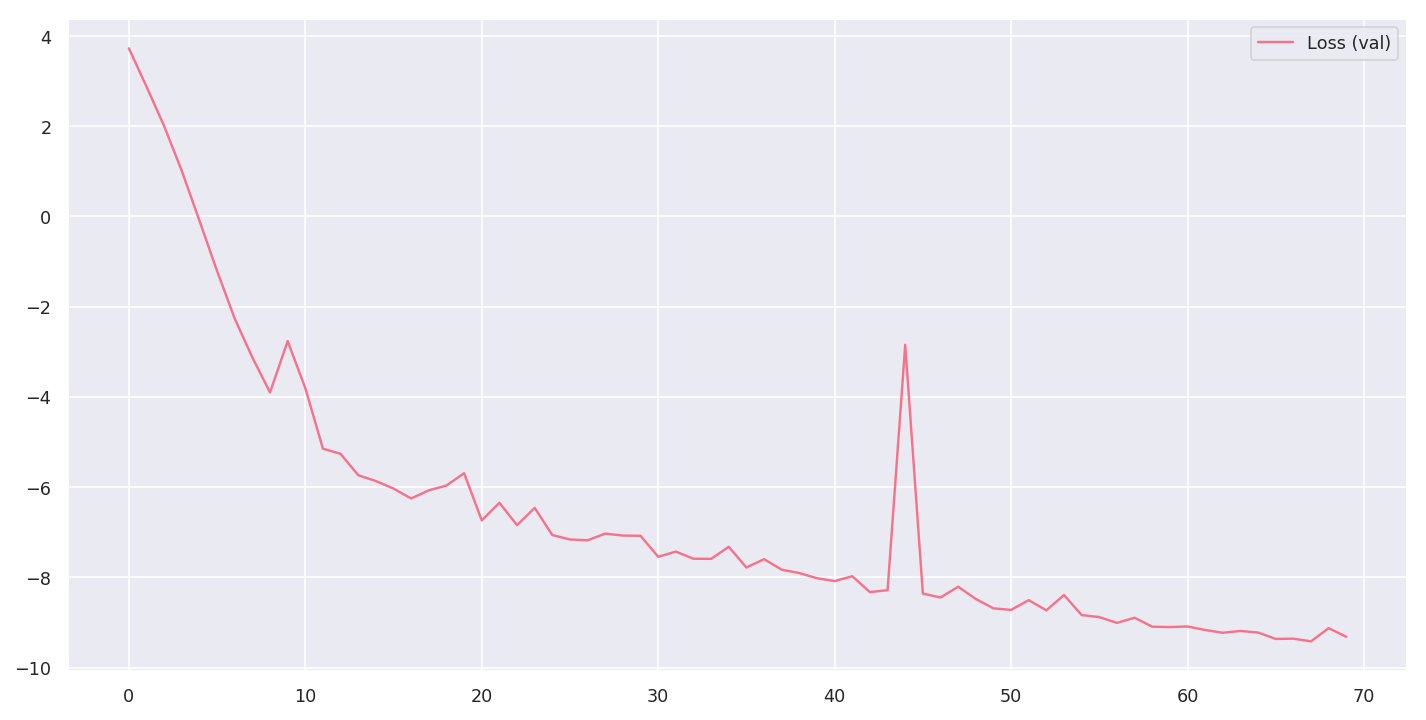

Step: 10990, loss: -9.5453


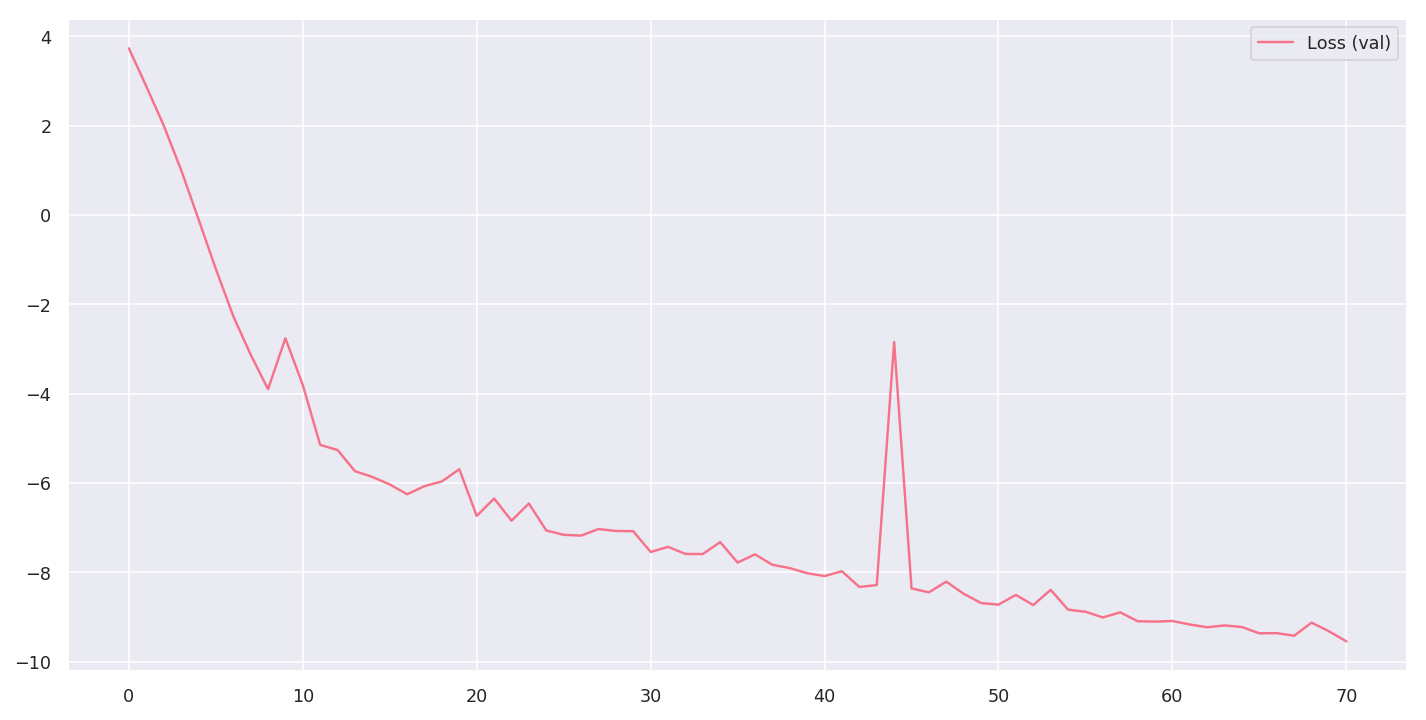

Step: 11147, loss: -9.5412


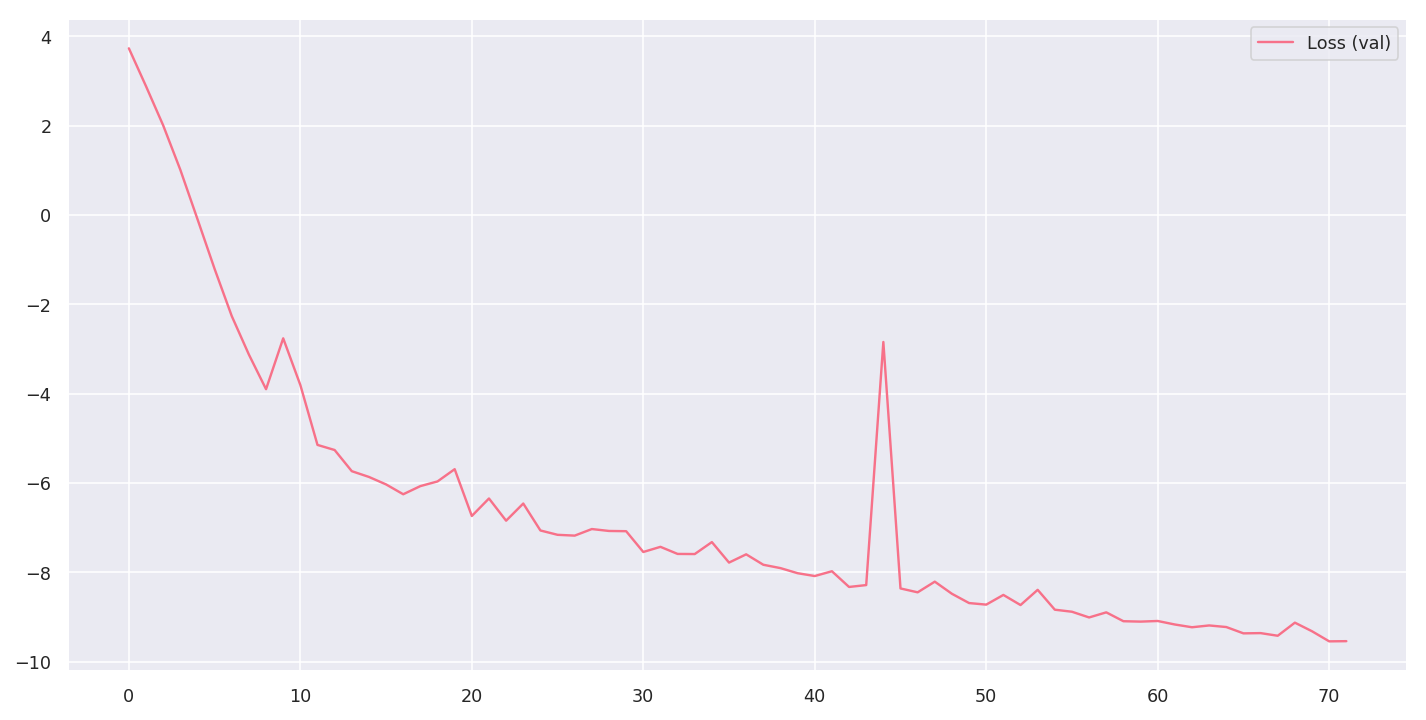

Step: 11304, loss: -9.5640


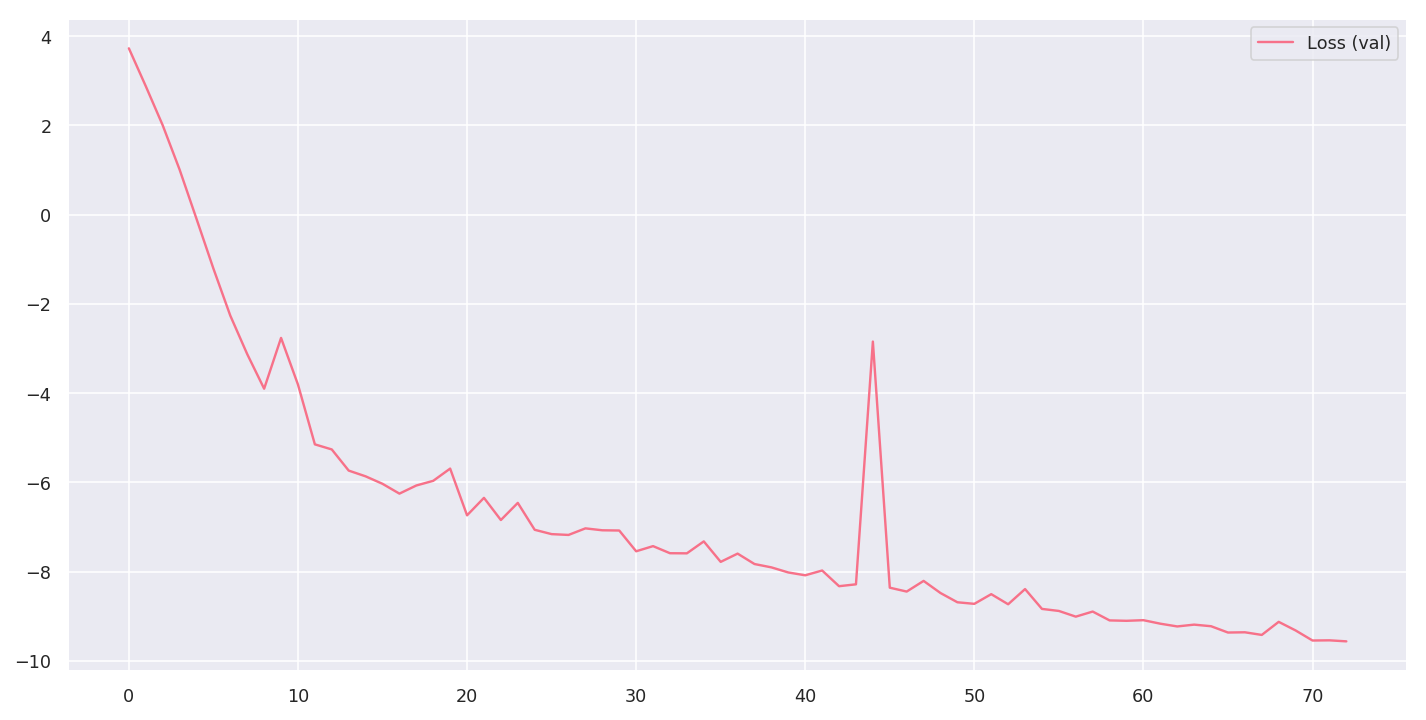

Step: 11461, loss: -9.6776


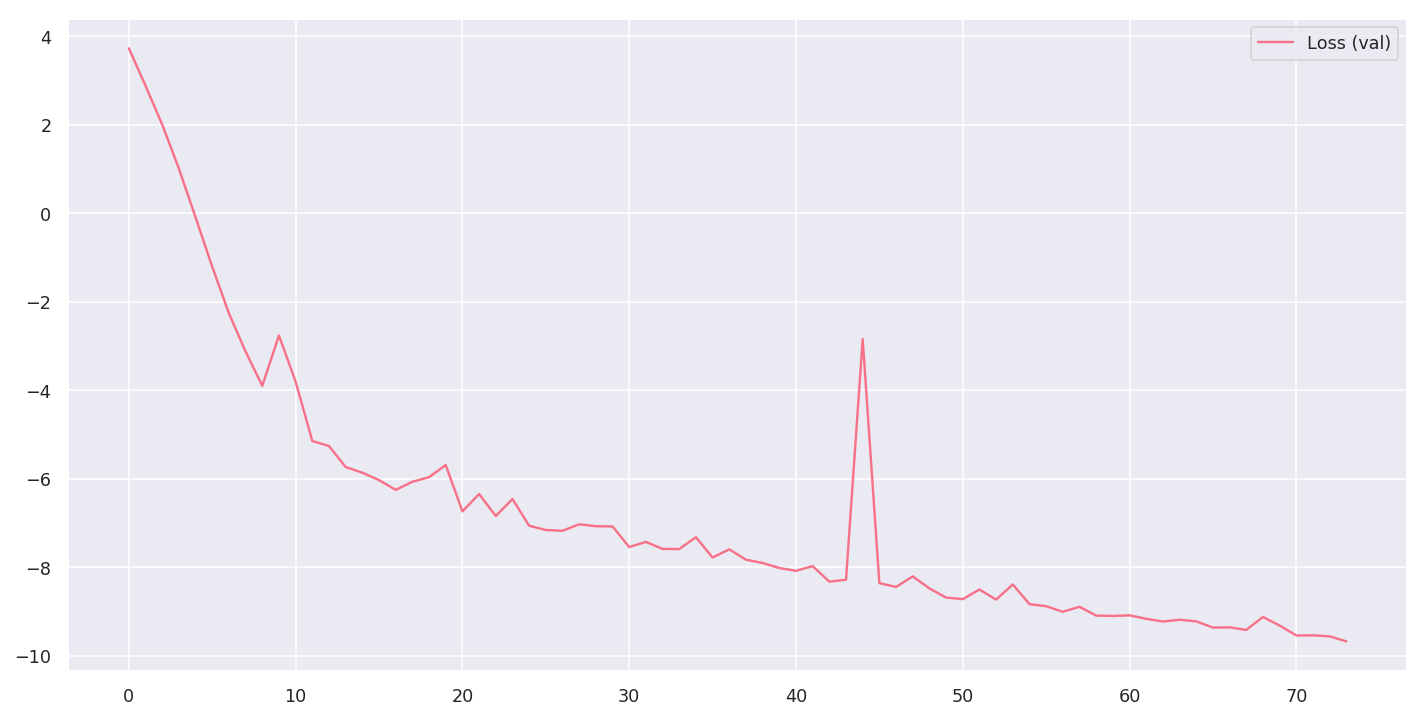

Step: 11618, loss: -9.6536


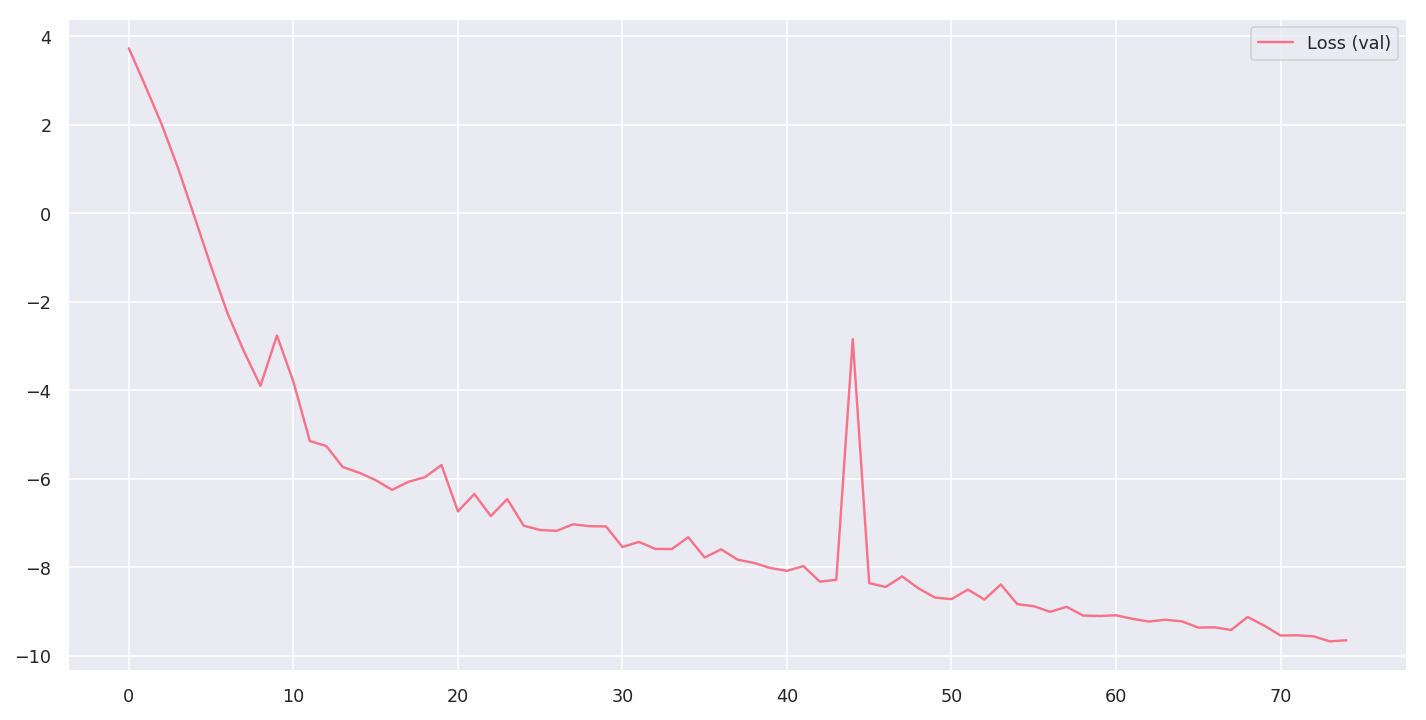

Step: 11775, loss: -9.6422


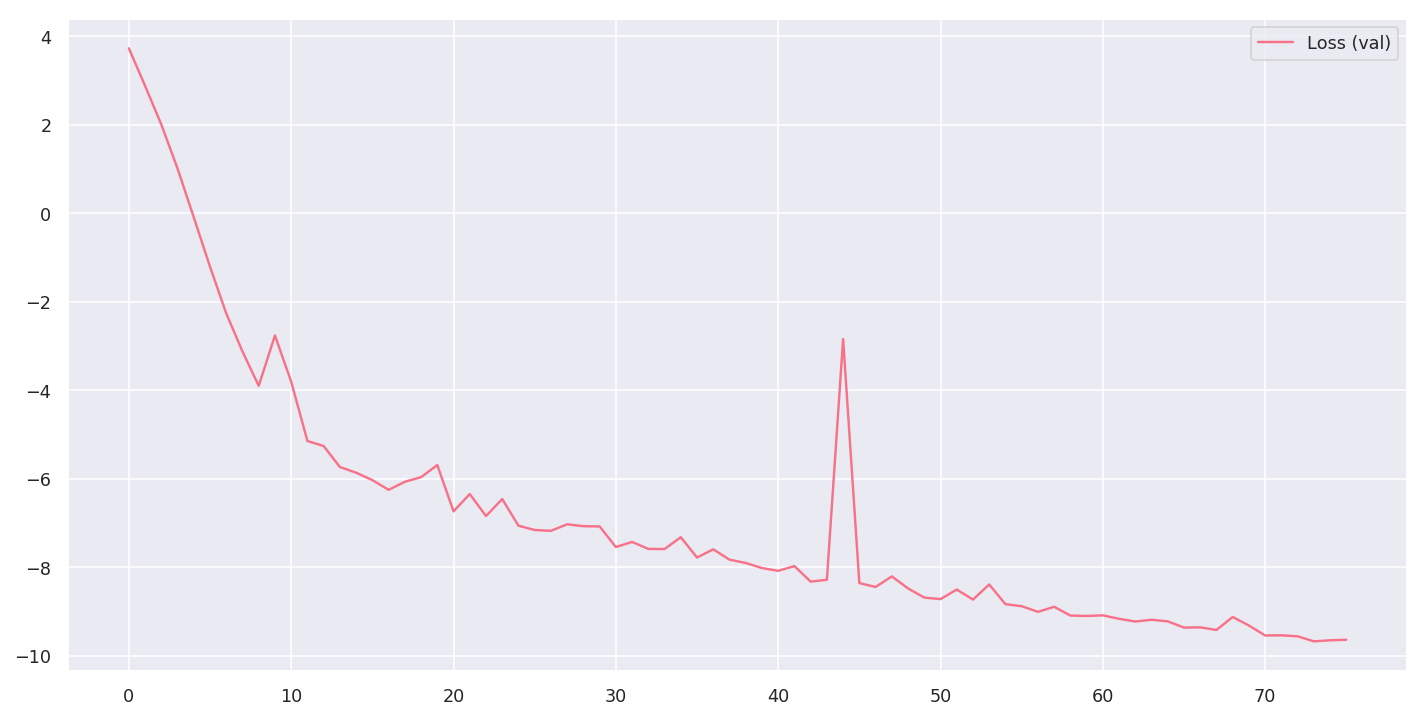

Step: 11932, loss: -9.7296


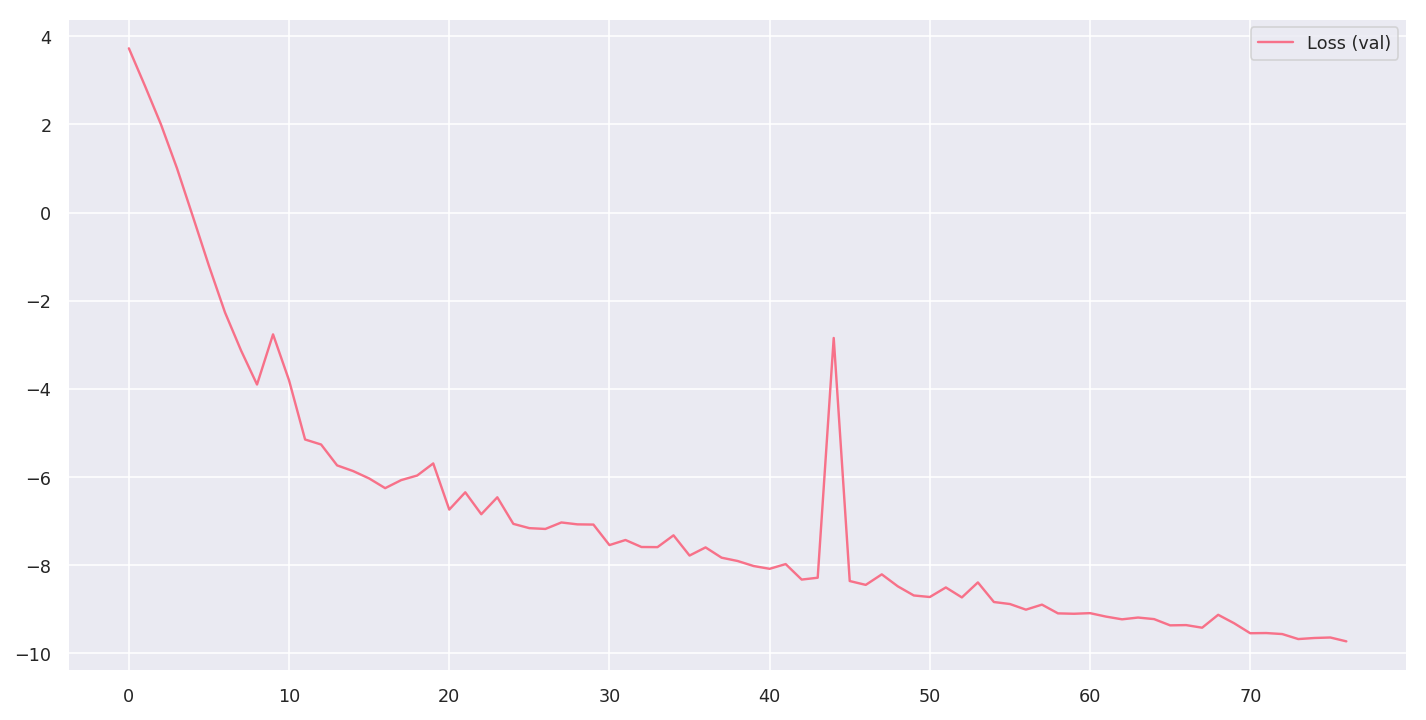

Step: 12089, loss: -9.6134


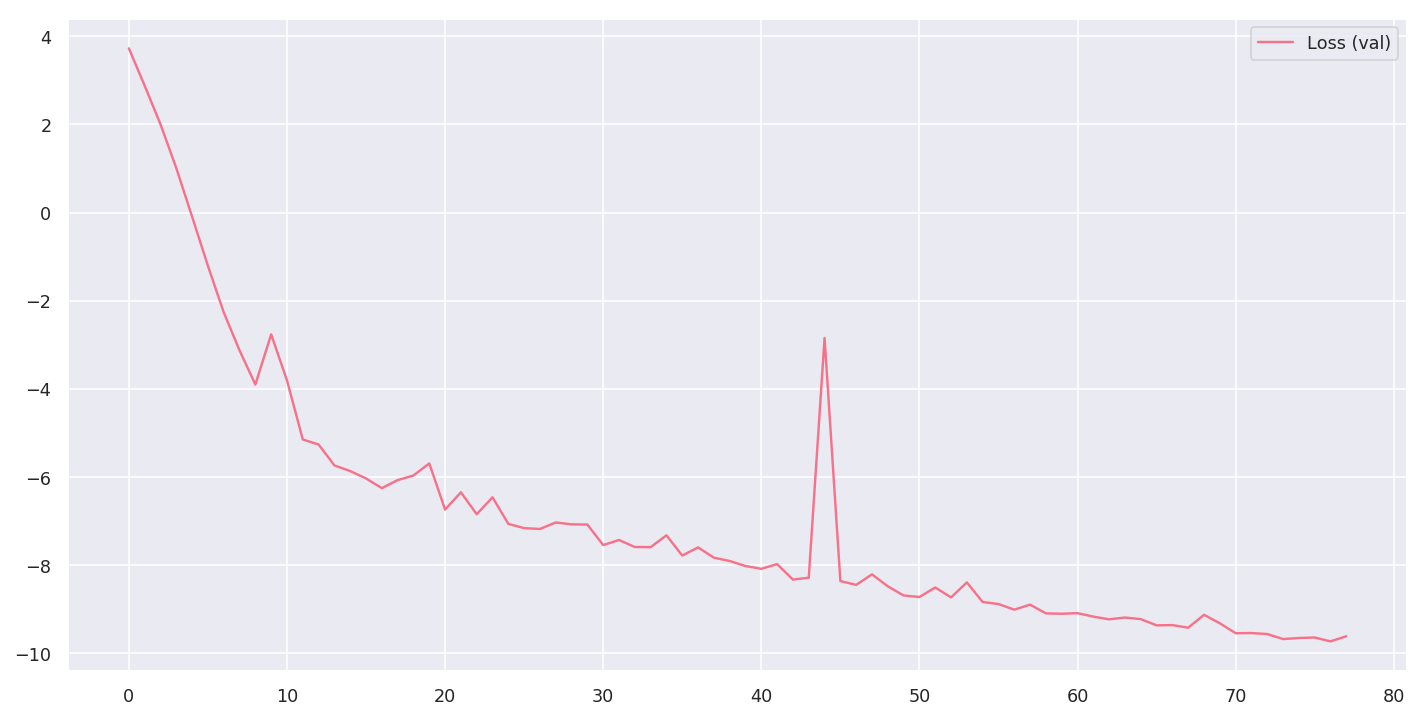

Step: 12246, loss: -9.7341


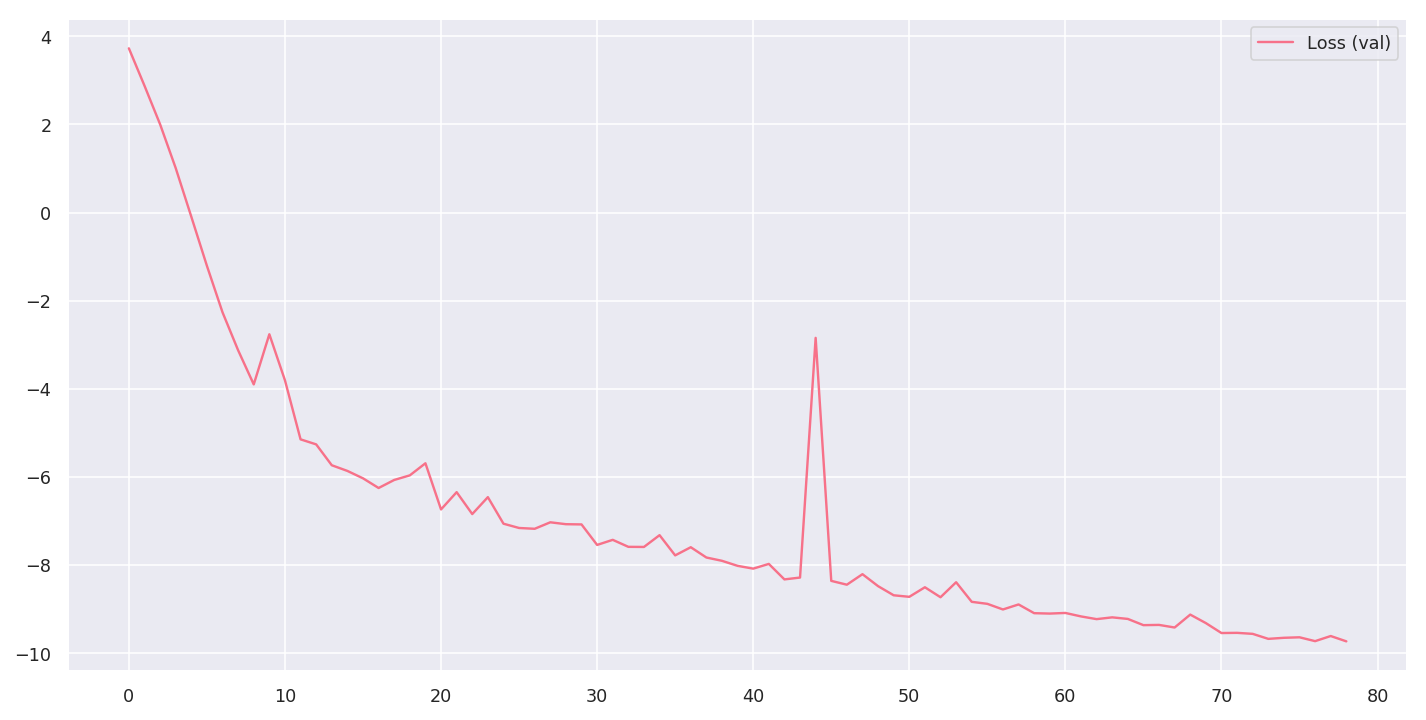

Step: 12403, loss: -9.7803


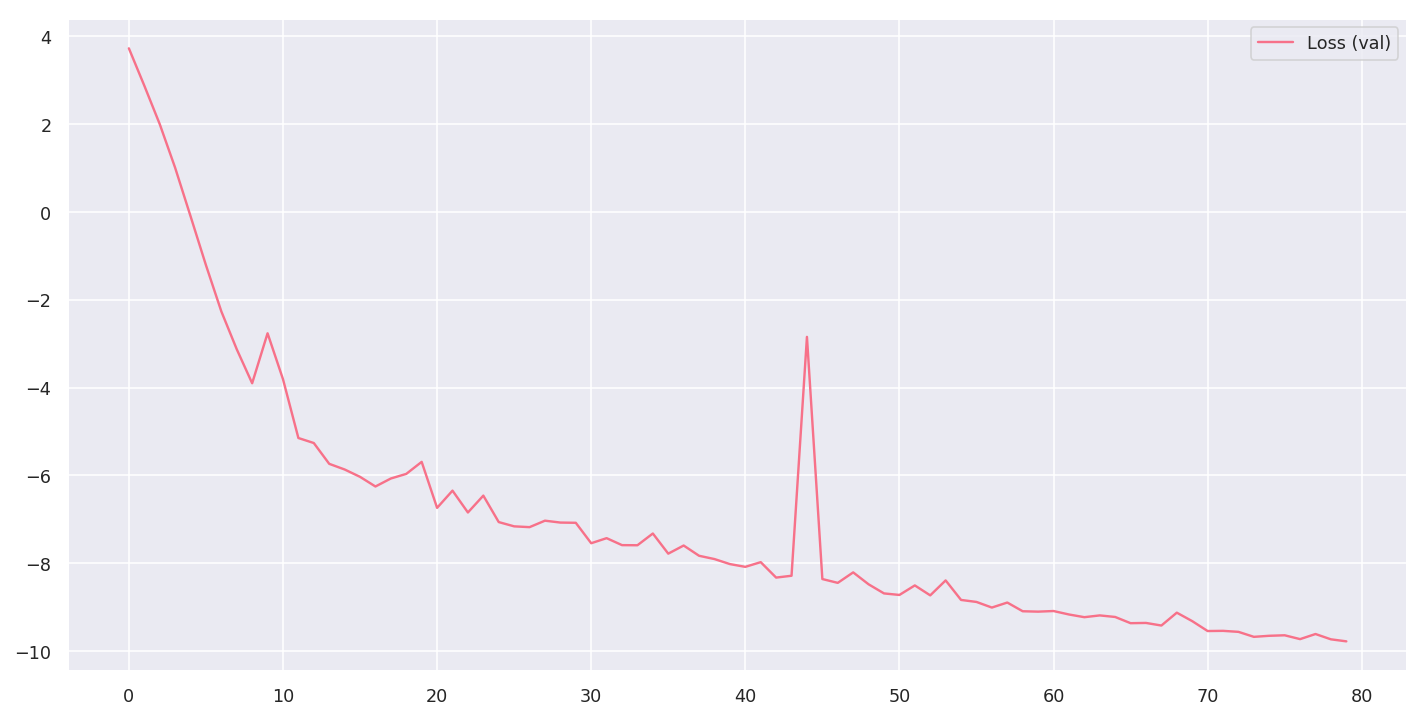

Step: 12560, loss: -9.8046


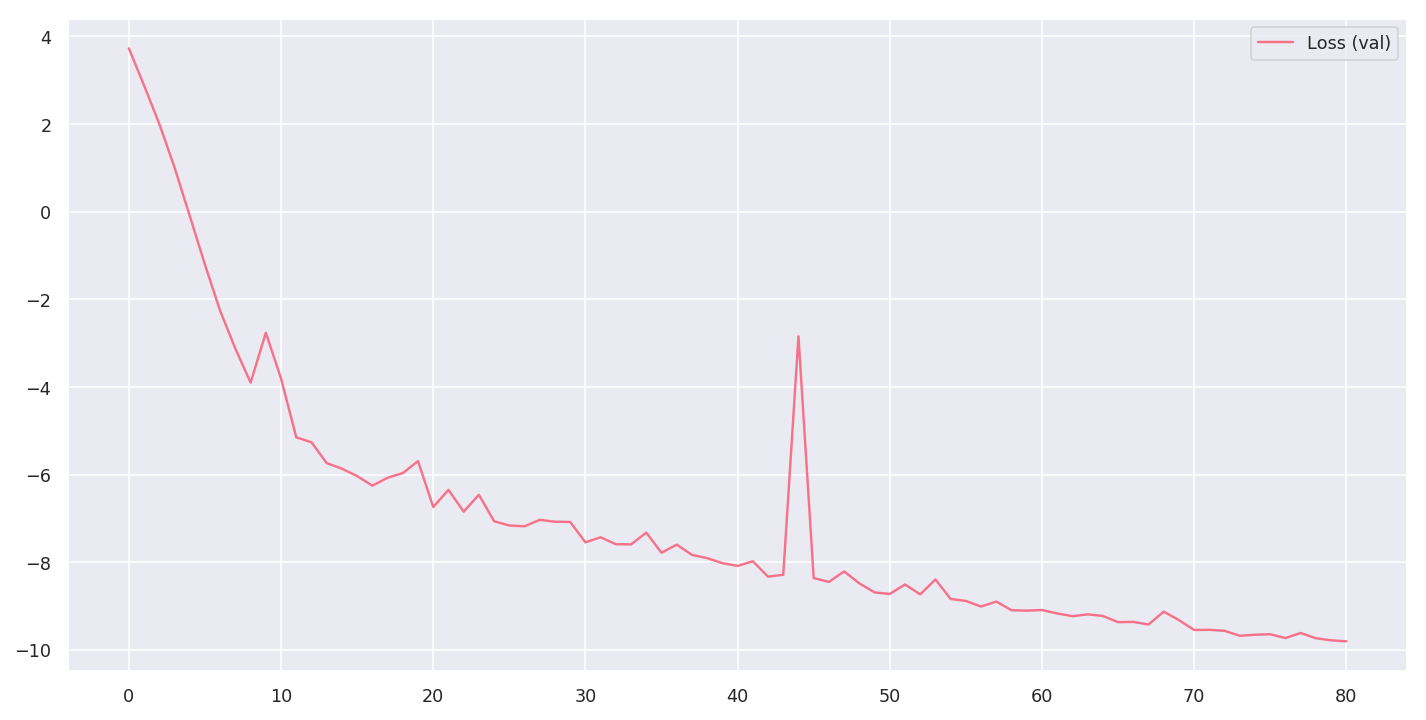

Step: 12717, loss: -9.7875


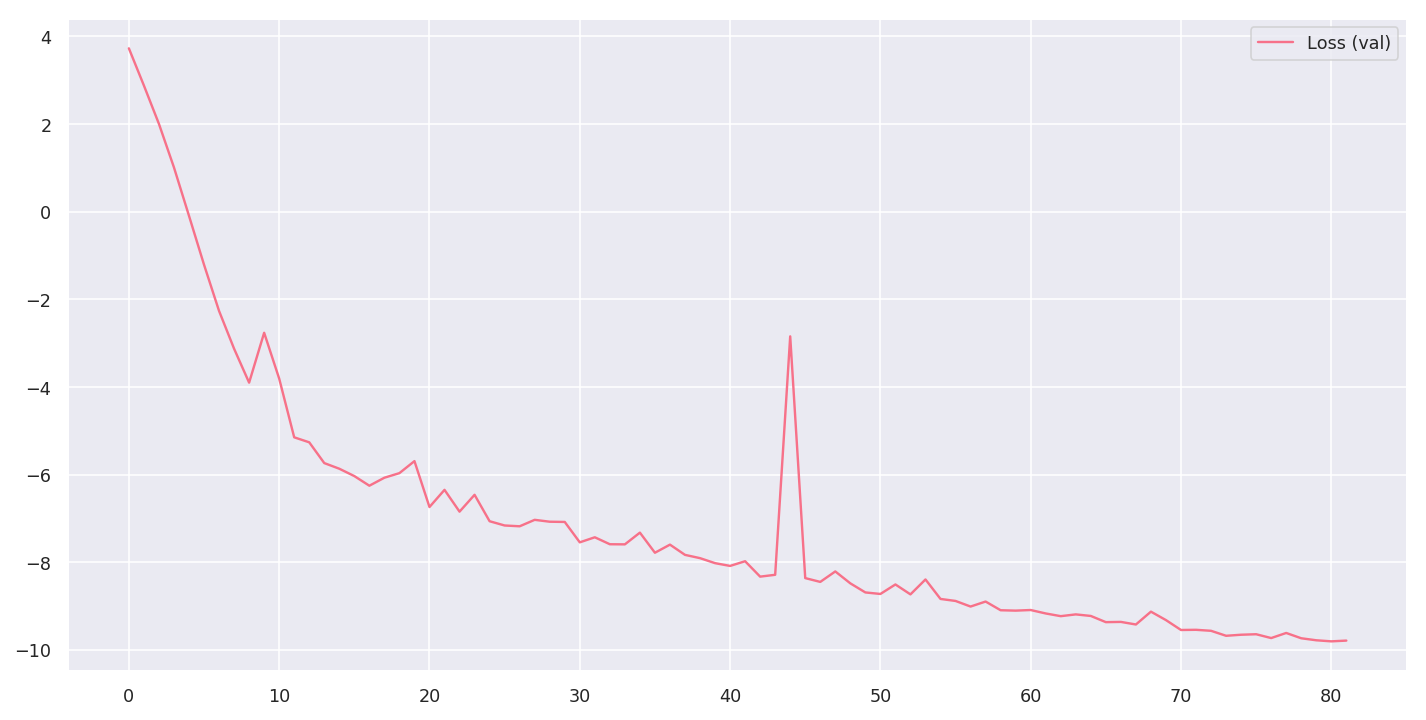

Step: 12874, loss: -9.7772


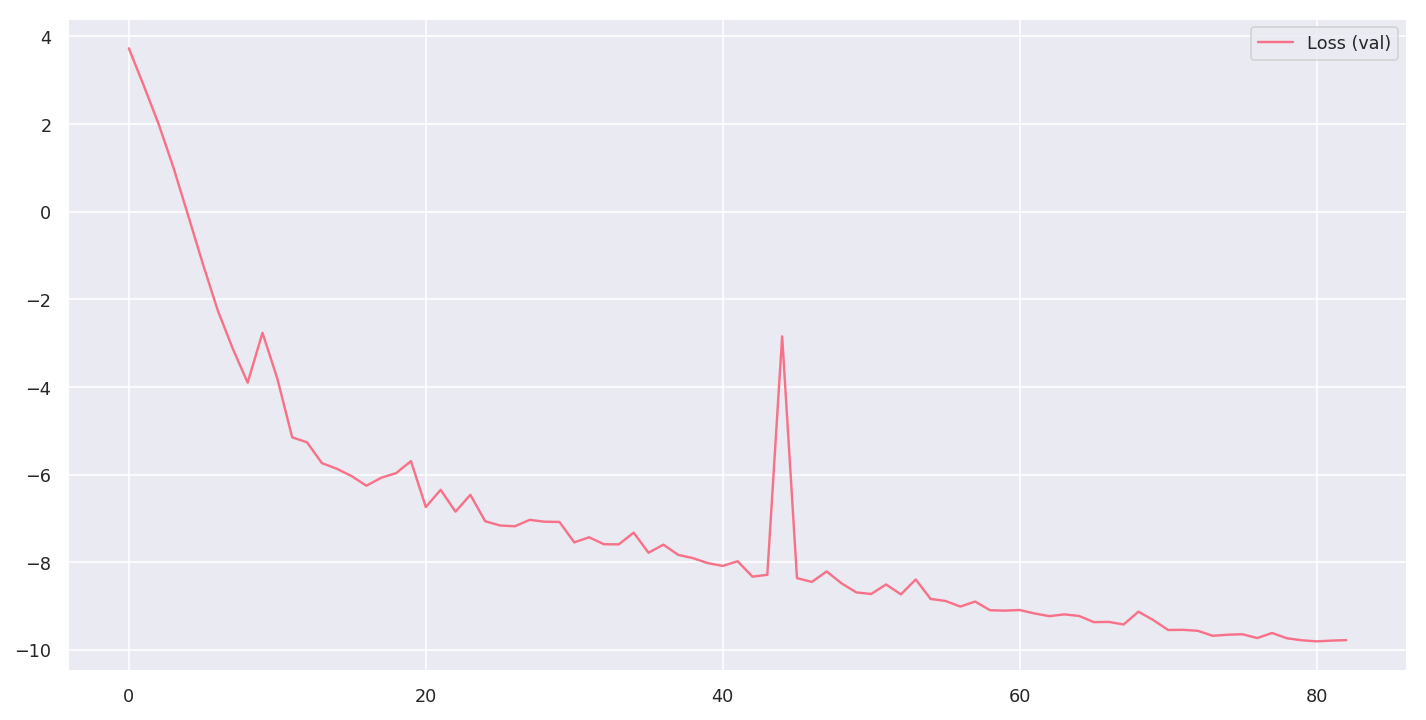

Step: 13031, loss: -9.8383


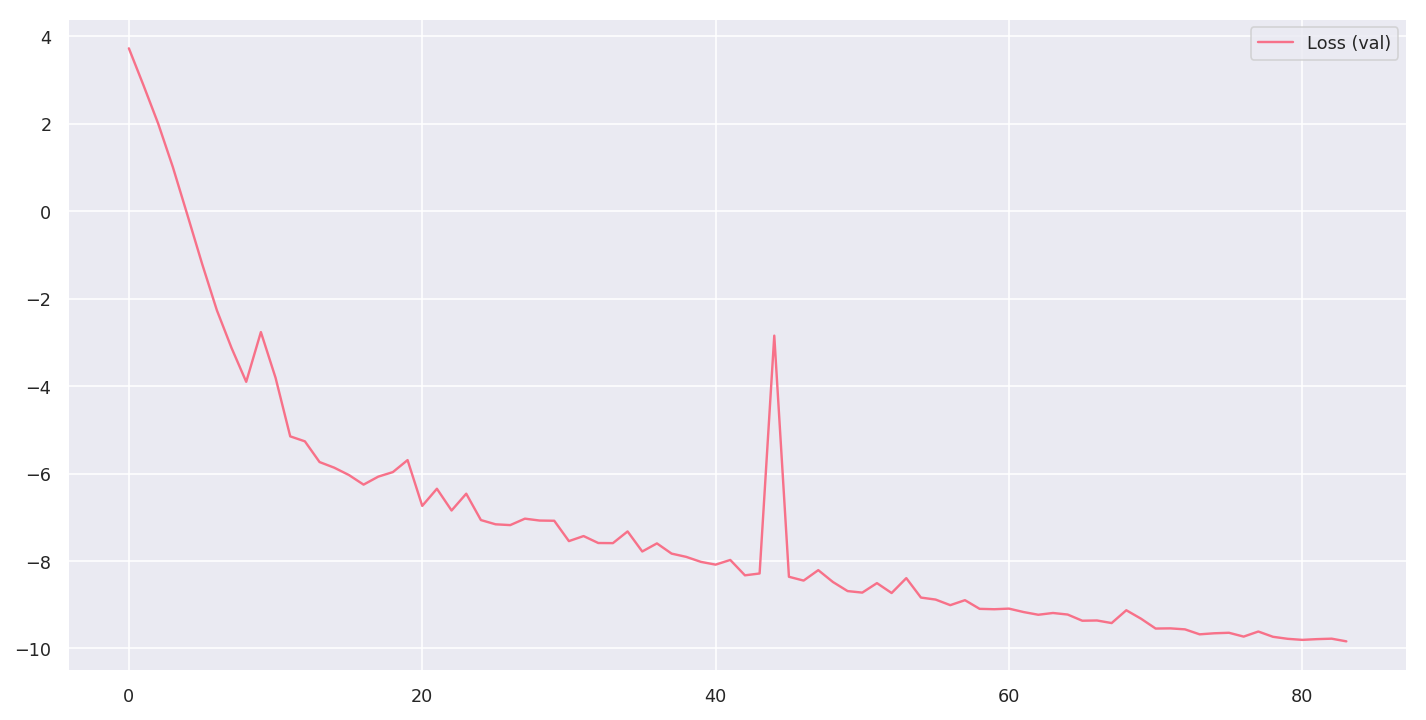

Step: 13188, loss: -9.8565


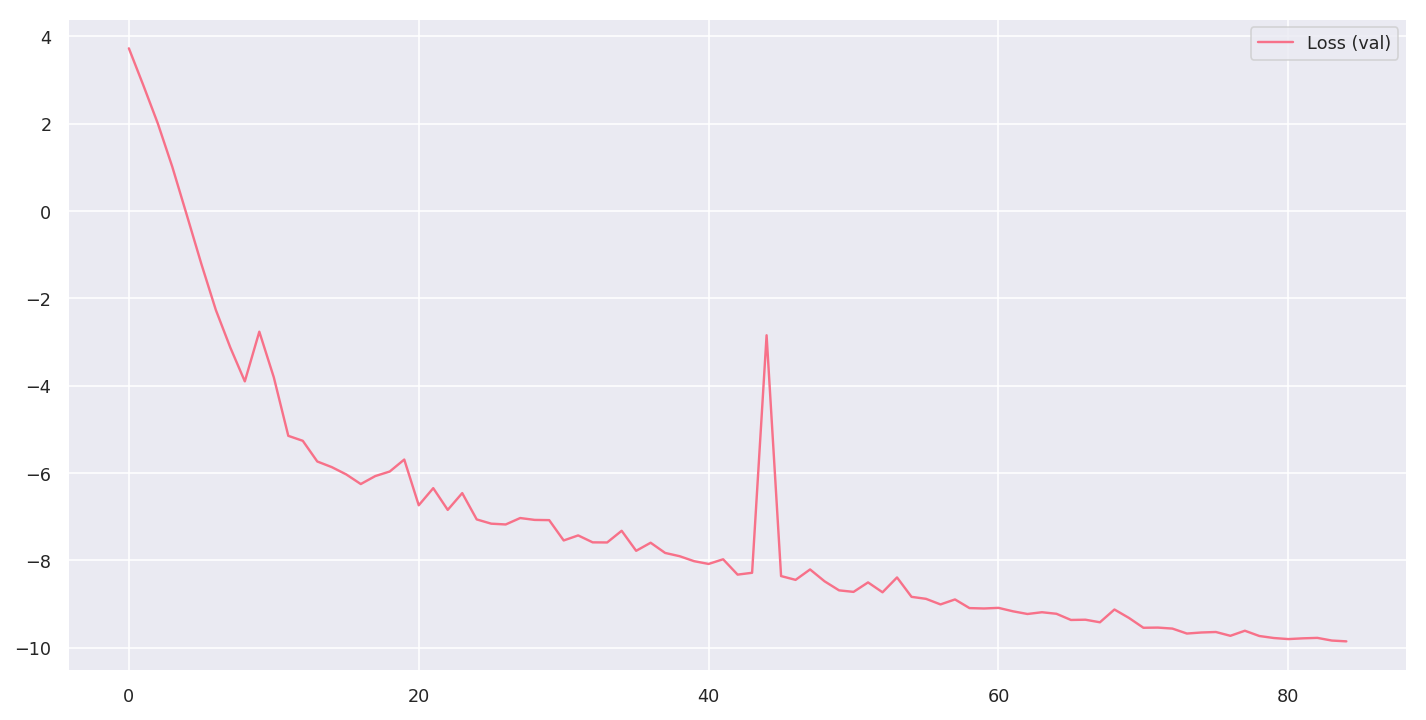

Step: 13345, loss: -9.8843


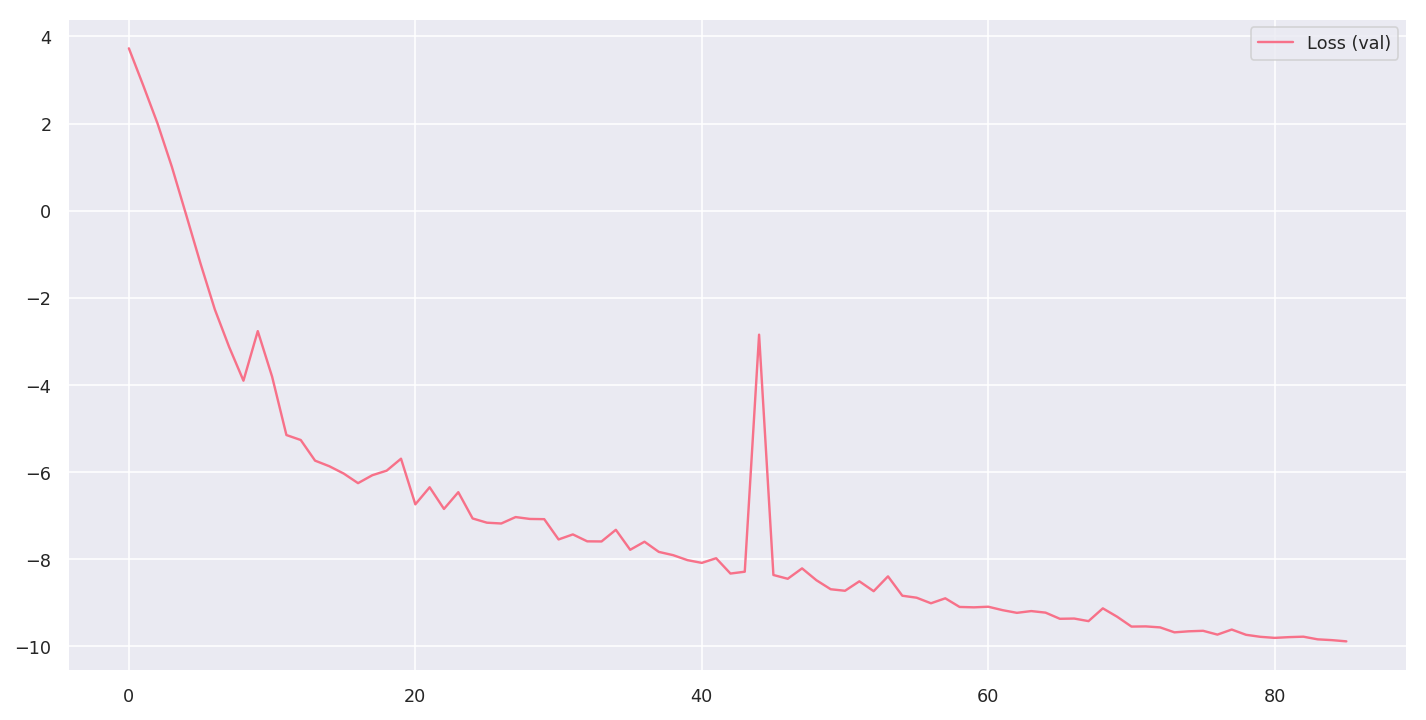

Step: 13502, loss: -9.8325


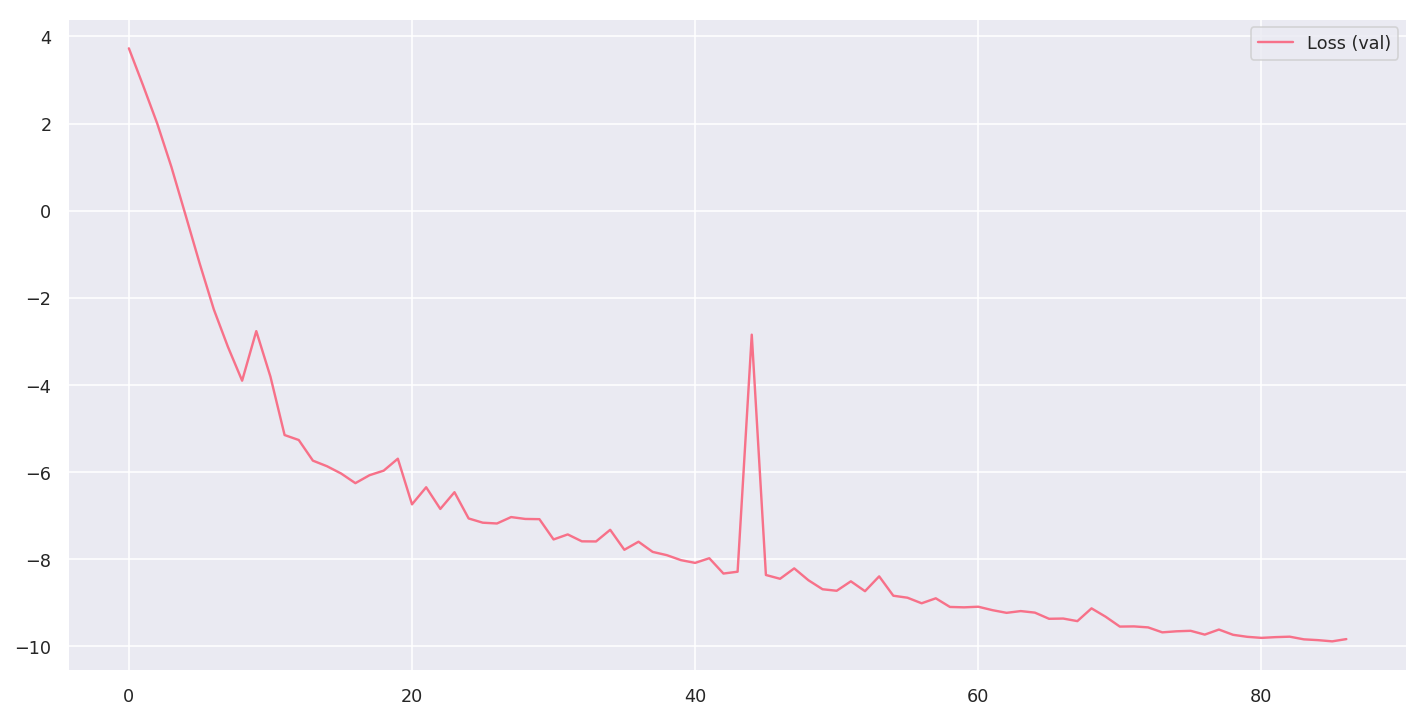

Step: 13659, loss: -9.6485


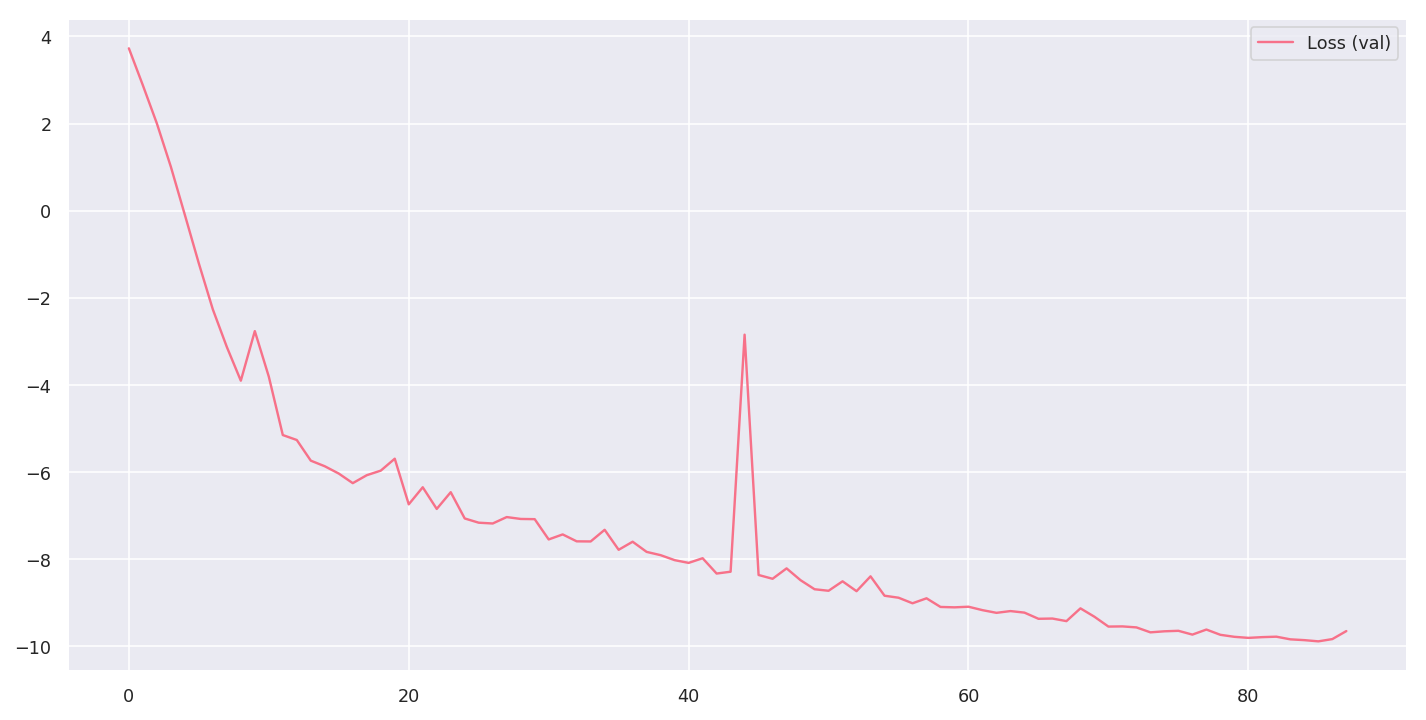

Step: 13816, loss: -10.0087


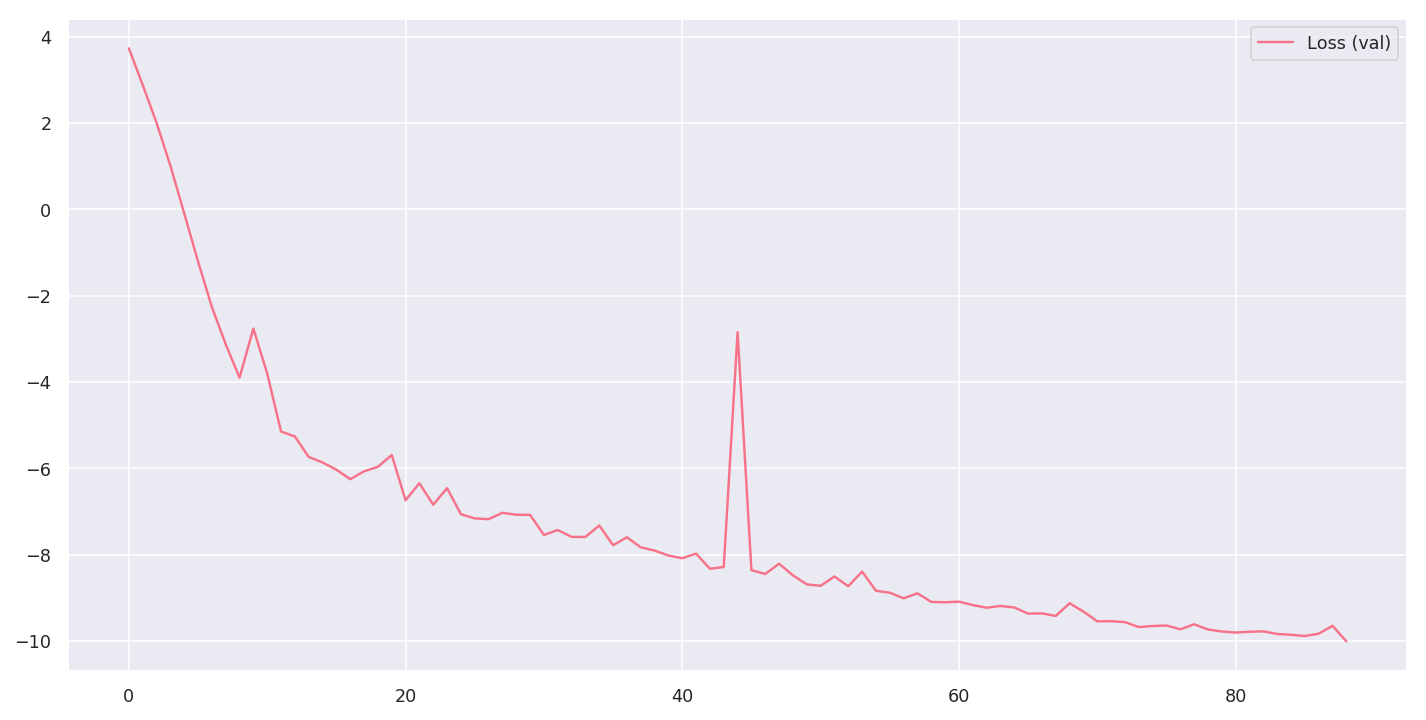

Step: 13973, loss: -9.8124


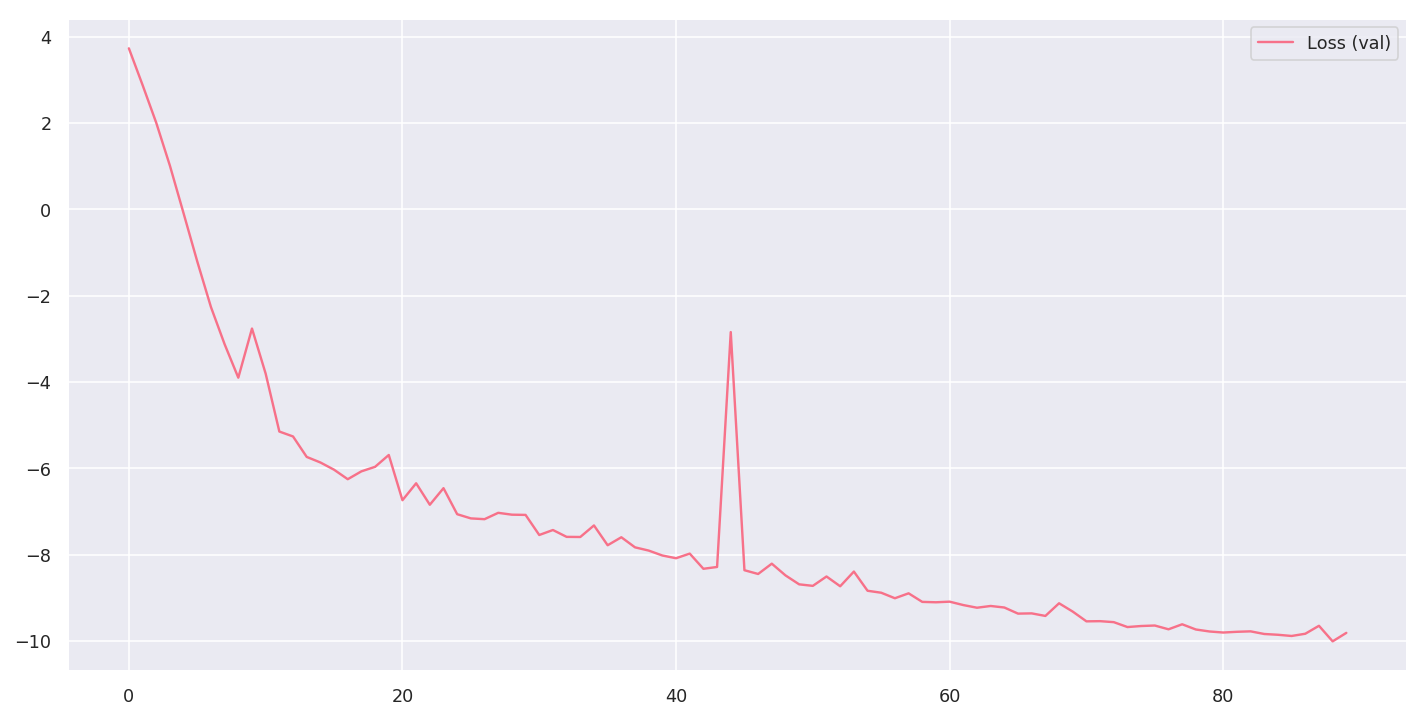

Step: 14130, loss: -9.6223


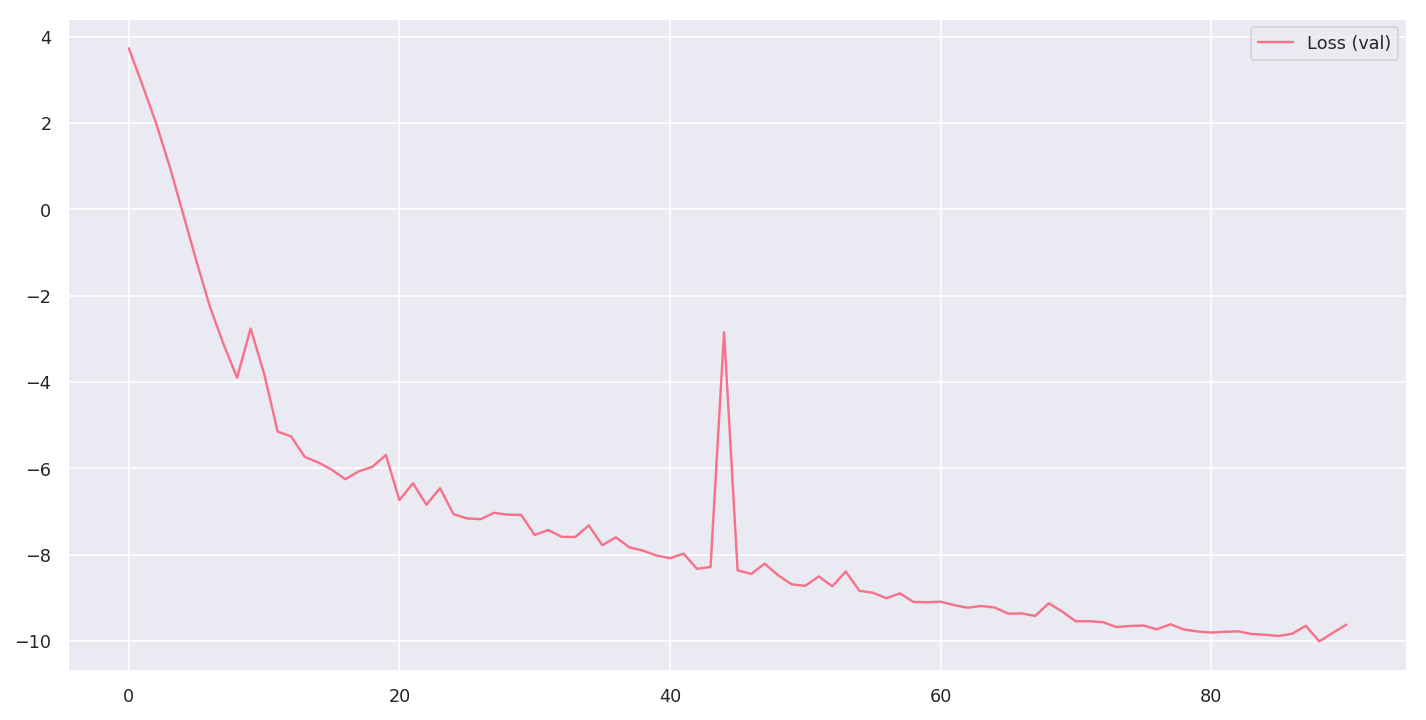

Step: 14287, loss: -9.7435


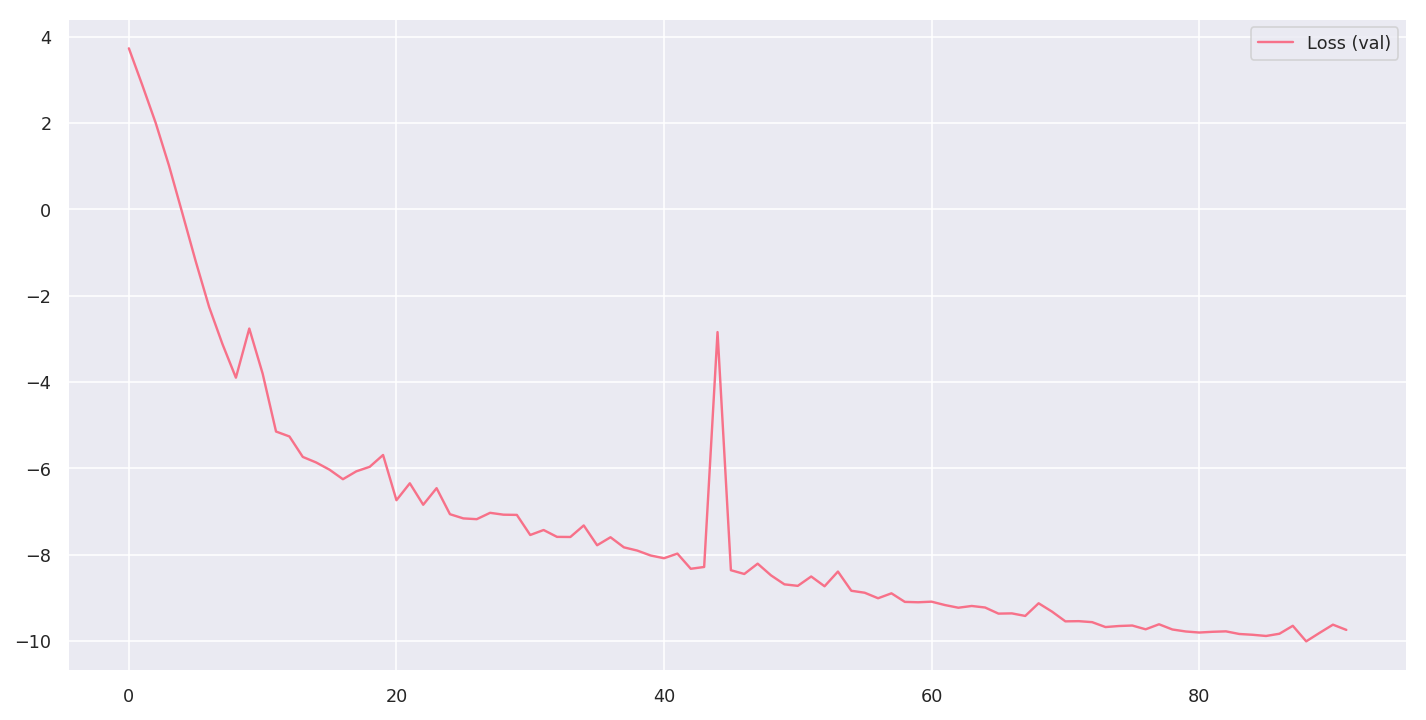

Step: 14444, loss: -9.9399


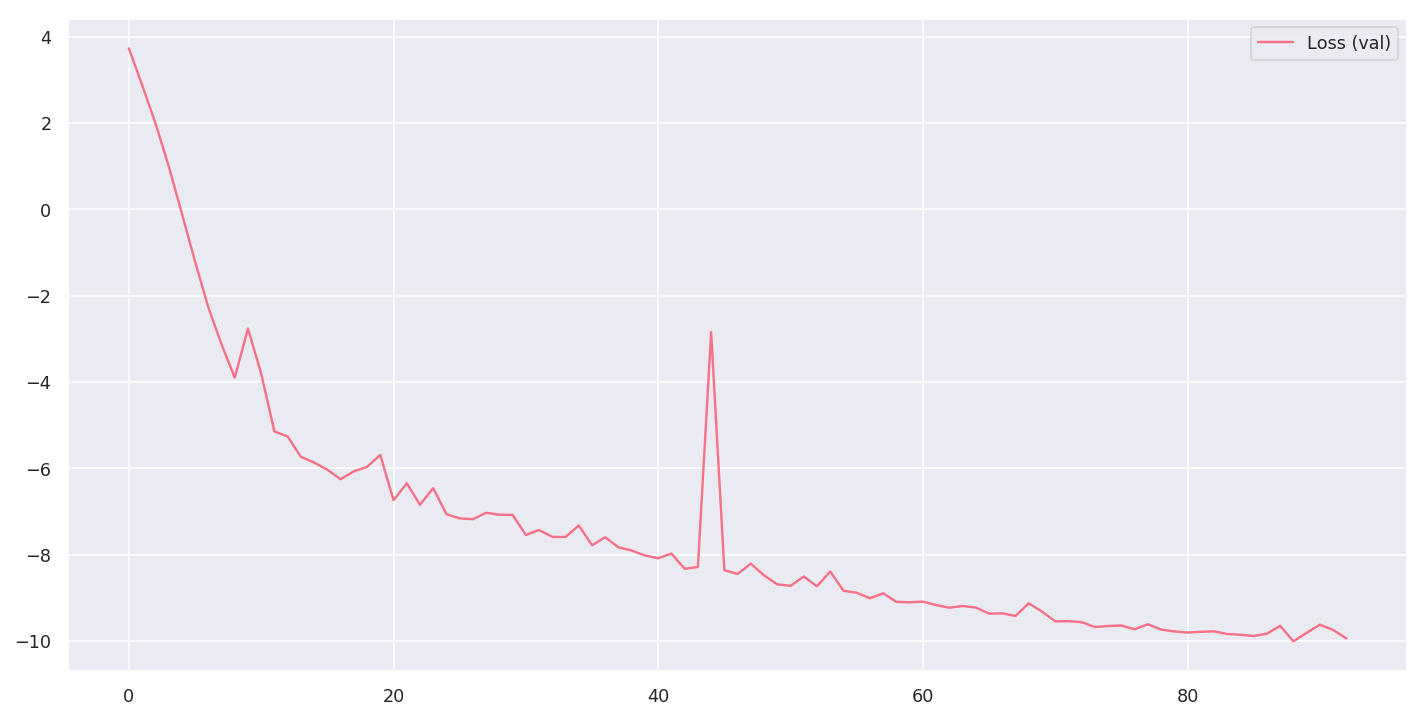

Step: 14601, loss: -9.8304


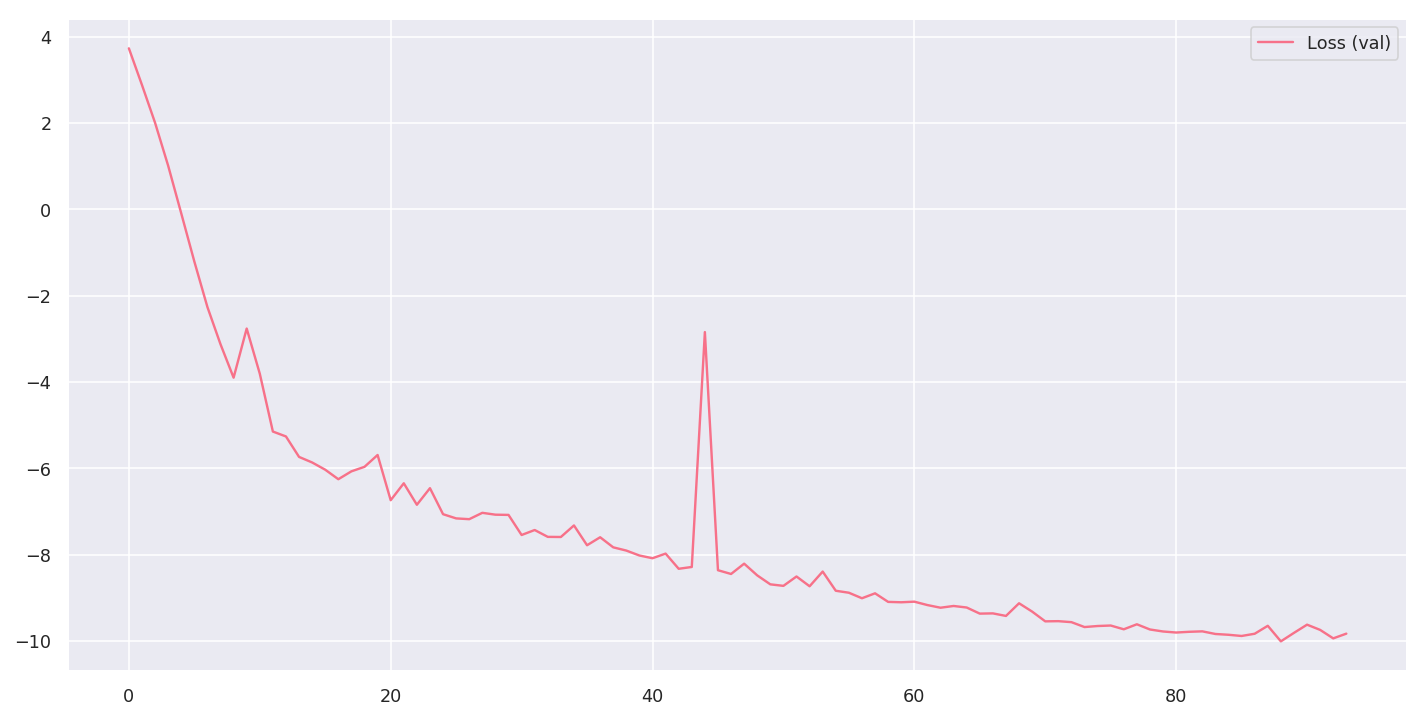

Step: 14758, loss: -9.7898


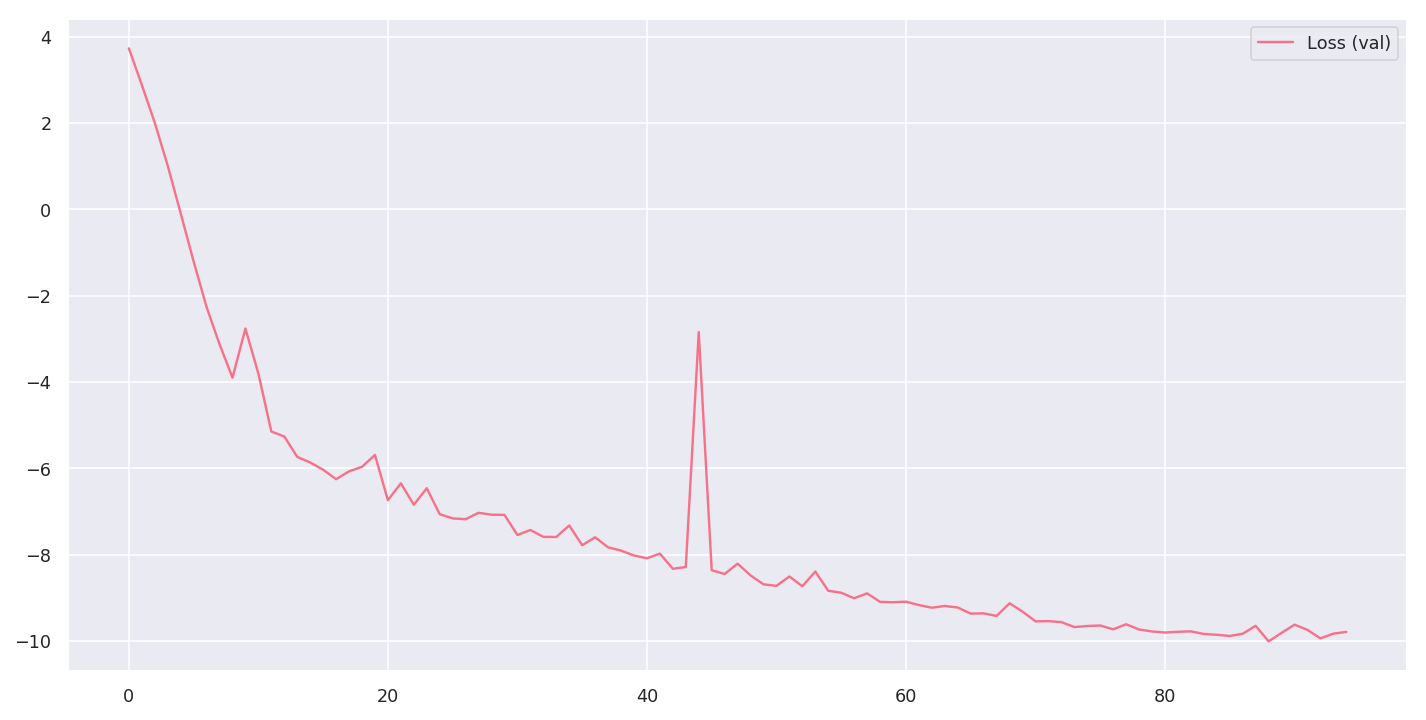

Step: 14915, loss: -9.8563


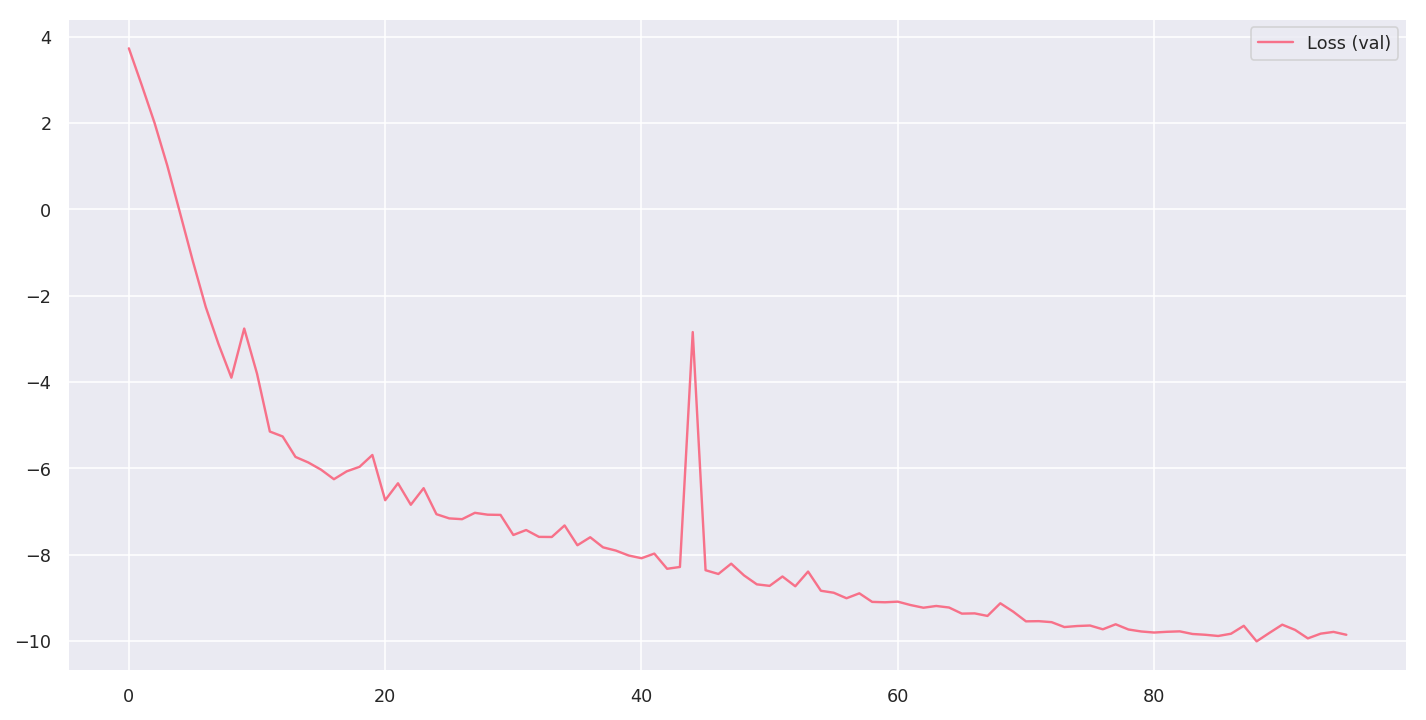

Step: 15072, loss: -9.9399


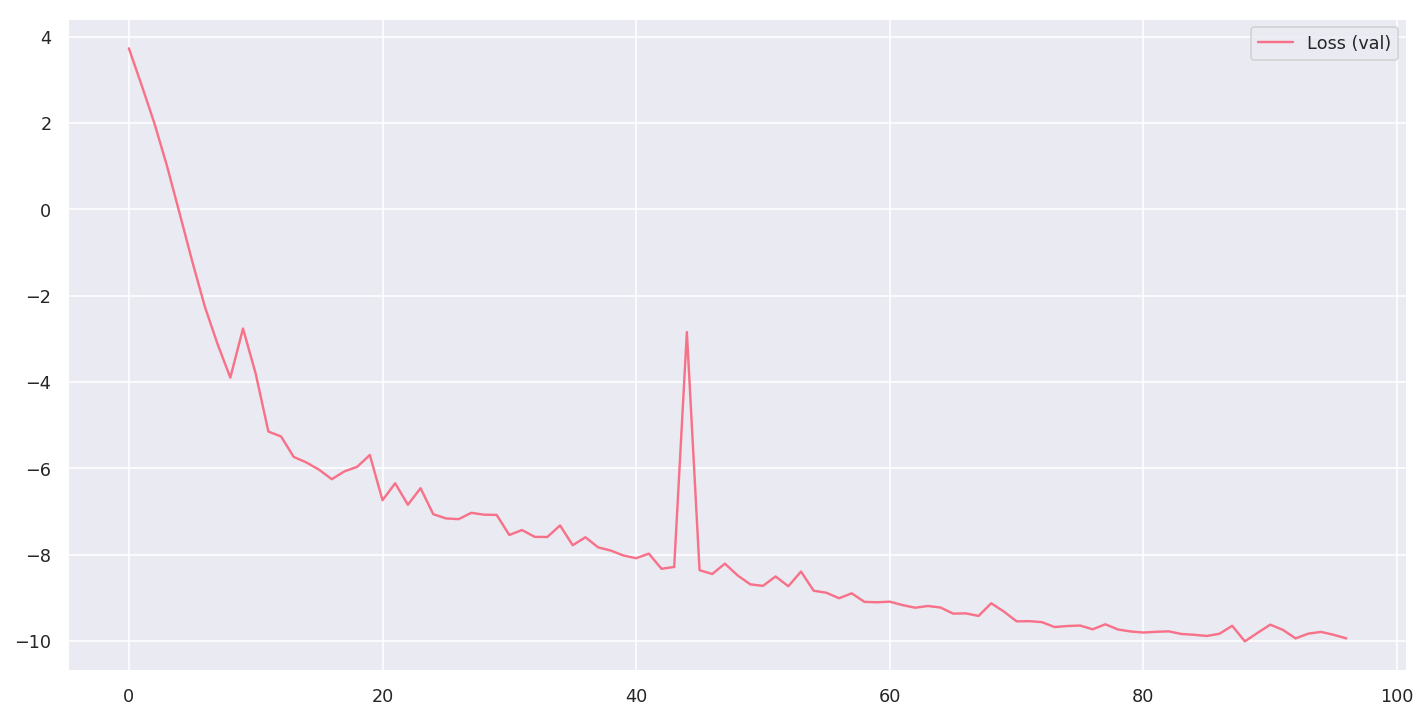

Step: 15229, loss: -9.8884


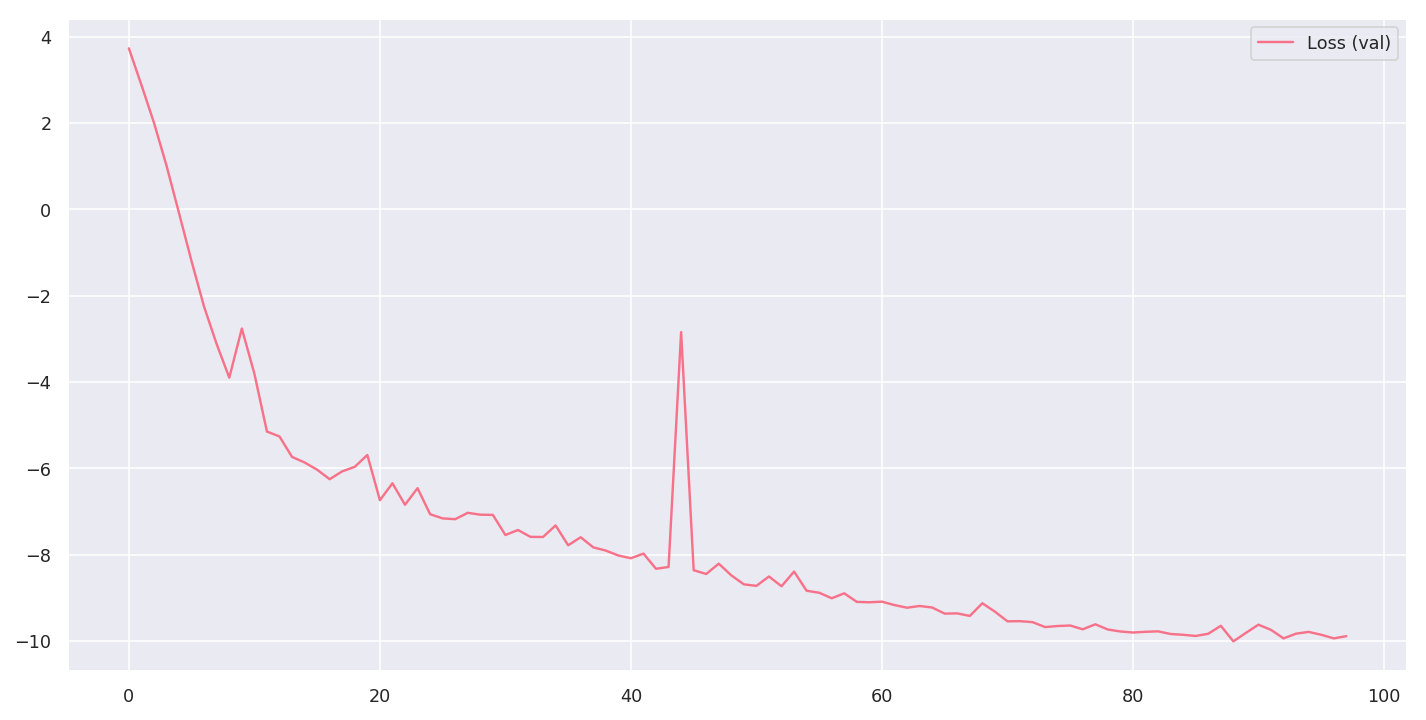

Step: 15386, loss: -9.9399


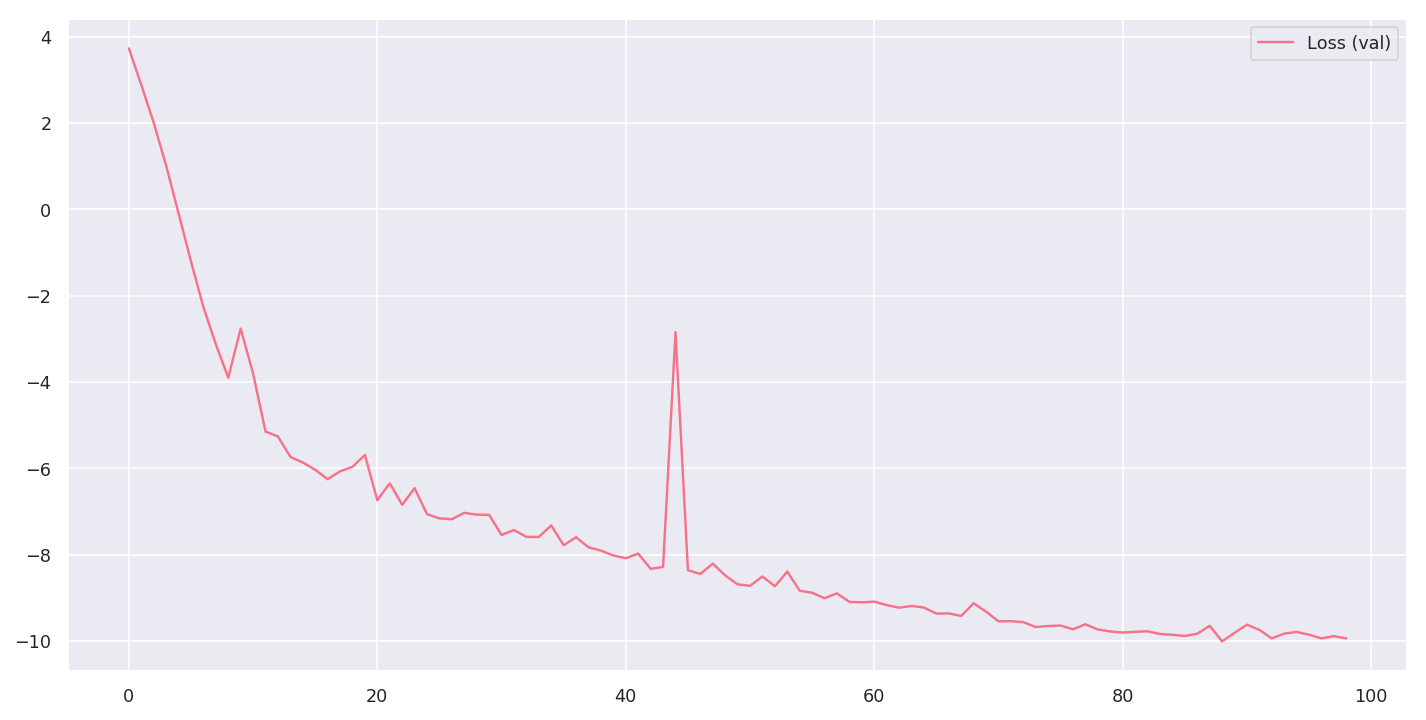

Step: 15543, loss: -9.7289


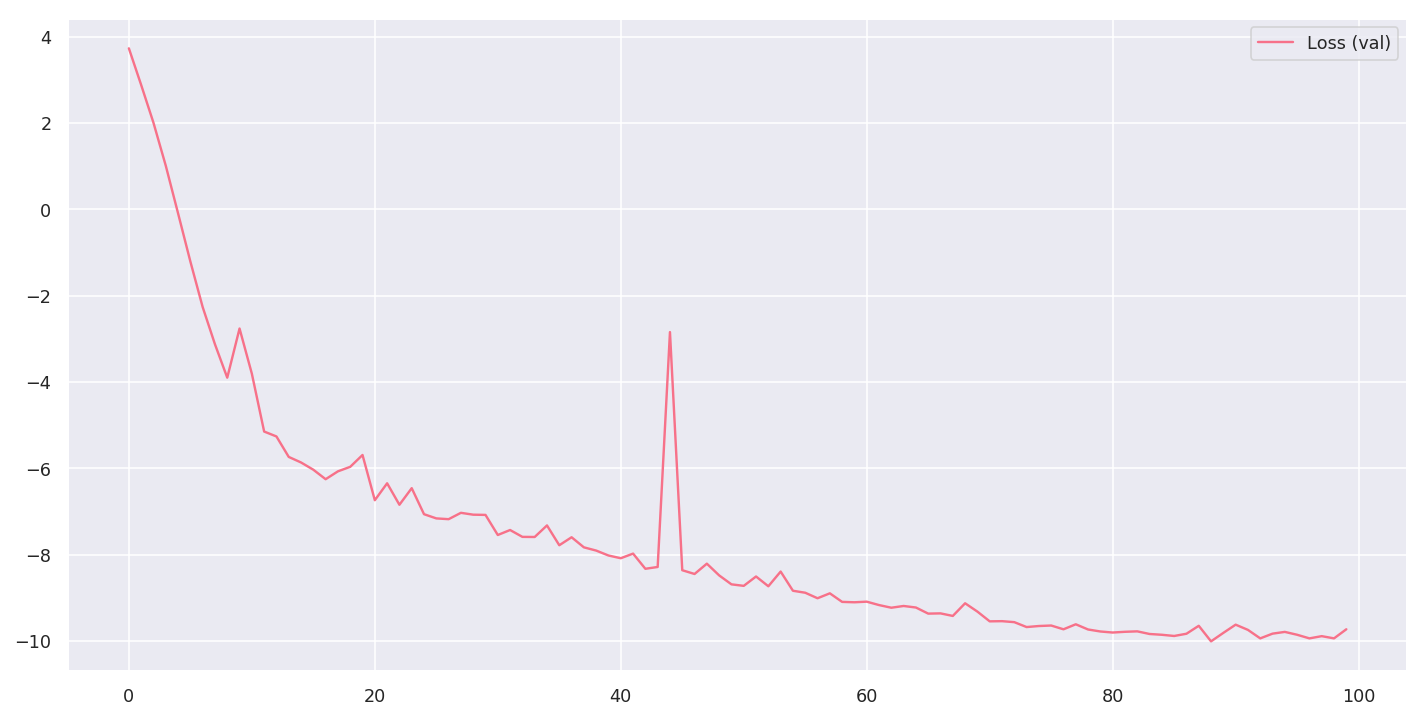

In [27]:
restore = False

path = './checkpoints/cartpole/decoder-size{}-dim{}-u{}-mix{}-n{}-shuffle{}-seed{}-b{}.ckpt'.format(
    len(states), len(dim_hidden), n_units, mixture_components, param_noise, int(shuffle), seed, batch_size_sim)
if not os.path.exists(os.path.basename(path)):
    os.mkdir(os.path.basename(path))
decoder_weights = tf.trainable_variables(scope='decoder_weights')
saver = tf.train.Saver(decoder_weights)

def save_fn():
    saver.save(sess, path)
    
if not restore:
    train_decoder(decoder_op, decoder_loss, n_epochs_decoder, n_batches_sim, n_trials, None, save_fn)
    

In [28]:
saver.restore(sess, path)

l = sess.run(decoder_loss)
print('Decoder loss: ', l)

Decoder loss:  -9.66964


Results with prior: -213.90007
Results with E[prior]: -161.21133
Results with phi: -482.11917
Results with phi (expected): -90.68771
****************
Learned params:  0.9338287, 0.97391194
Learned std:  0.55011666, 0.7553185
****************
MSE:  (0.0, 1.0824372)
RMSE: 1.0404024


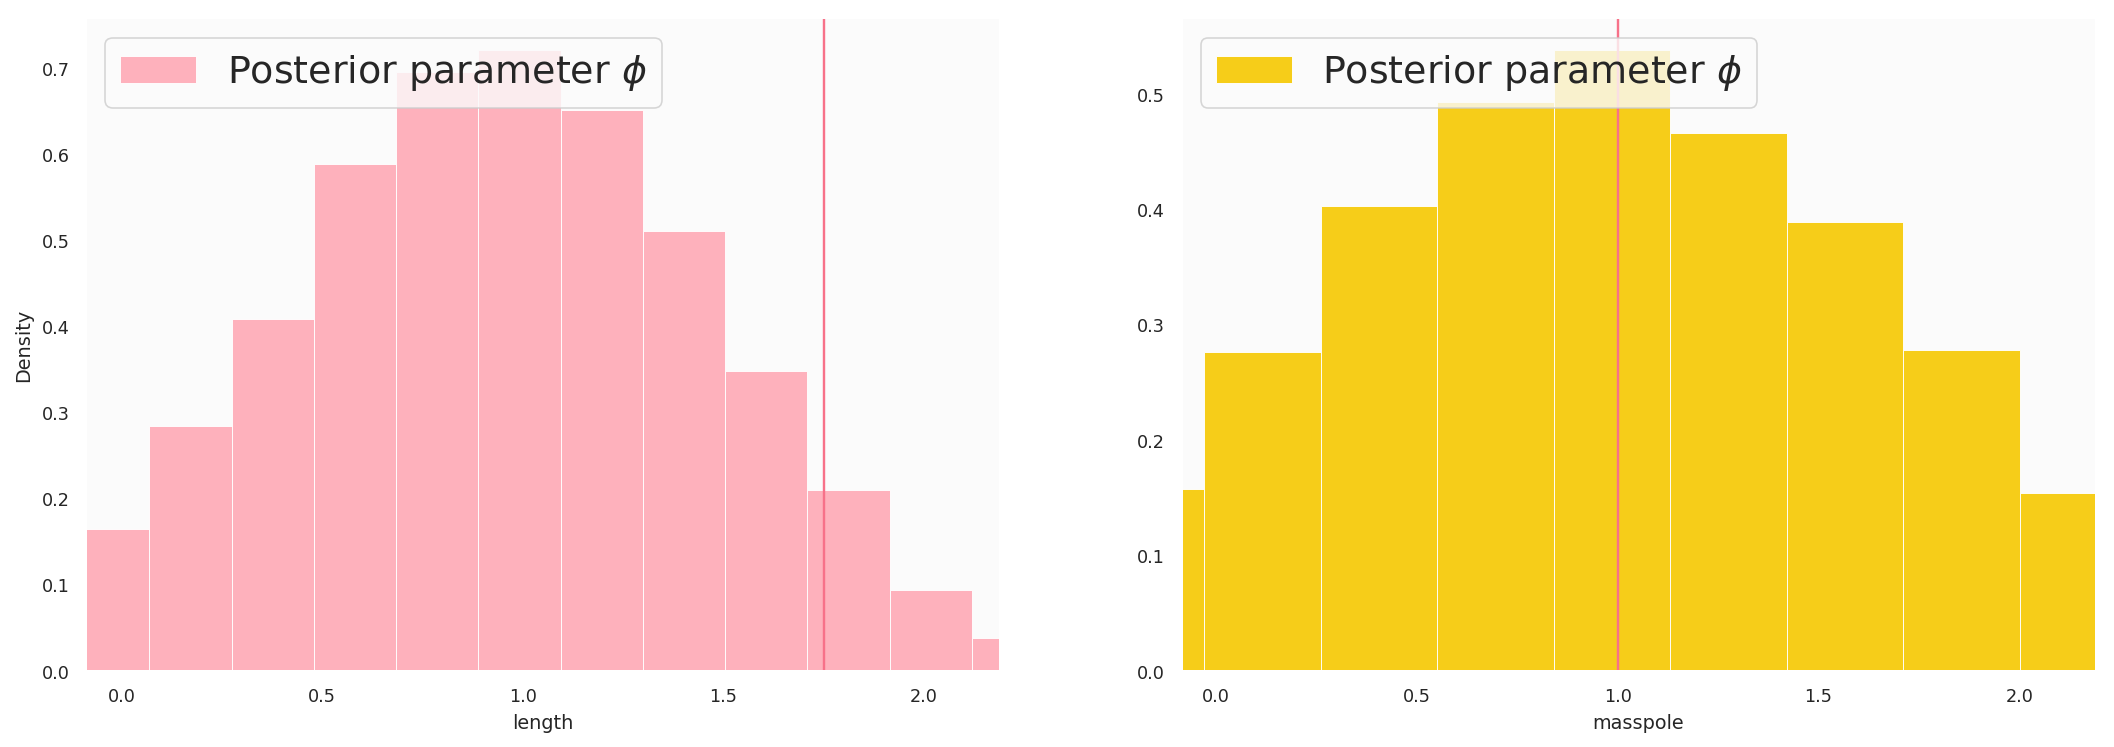

(array([0.9338, 0.9739], dtype=float32),
 array([0.5501, 0.7553], dtype=float32))

In [29]:
get_results()

# Train on real data

In [30]:
saver = tf.train.Saver()
cvae_path = './checkpoints/cvae-size{}-dim{}-u{}-mix{}-n{}-shuffle{}-seed{}.ckpt'.format(
    len(states), len(dim_hidden), n_units, mixture_components, param_noise, int(shuffle), seed)

def cvae_save_fn(path=cvae_path):
    saver.save(sess, path)

def cvae_restore_fn(path=cvae_path):
    saver.restore(sess, path)

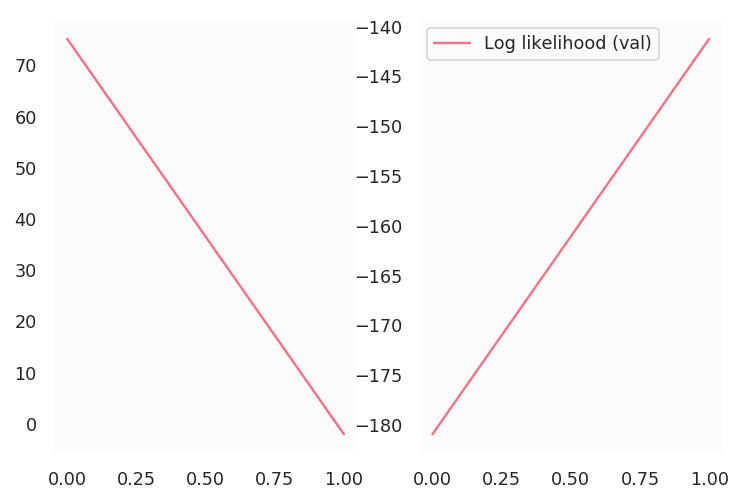

Results with prior: -145.12943
Results with E[prior]: -69.92618
Results with phi: 5.7609215
Results with phi (expected): 10.047364
****************
Learned params:  1.8349993, 1.4297998
Learned std:  0.16640733, 0.41211444
****************
MSE:  (1.0824372, 1.078322)
RMSE: 1.0384228


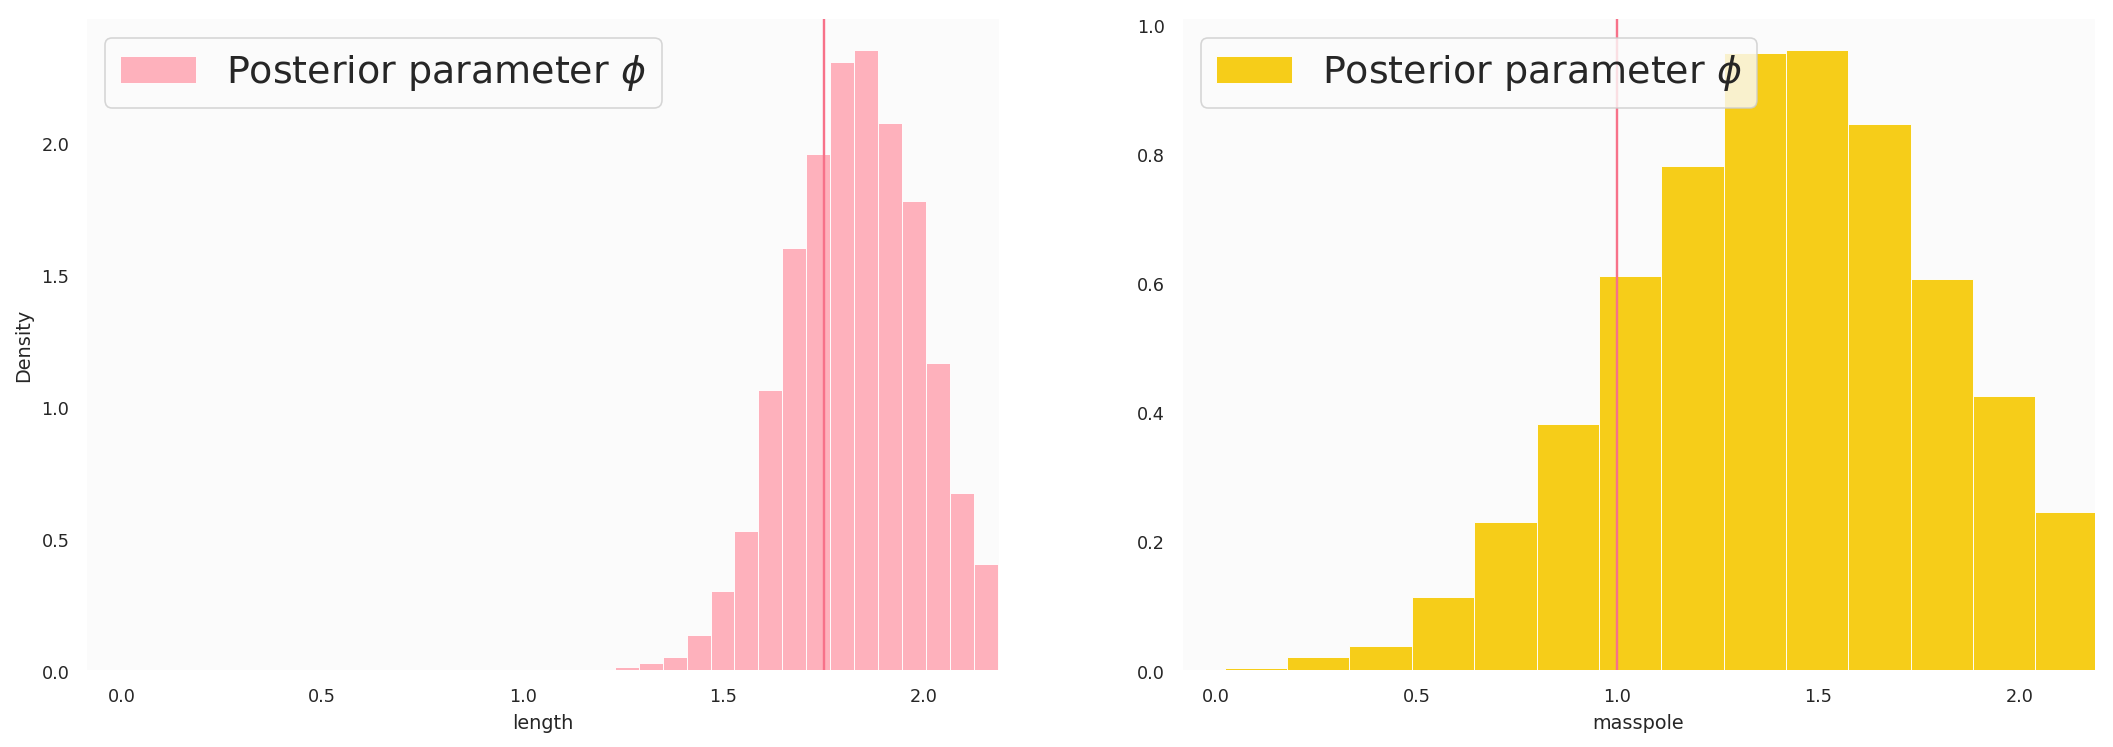

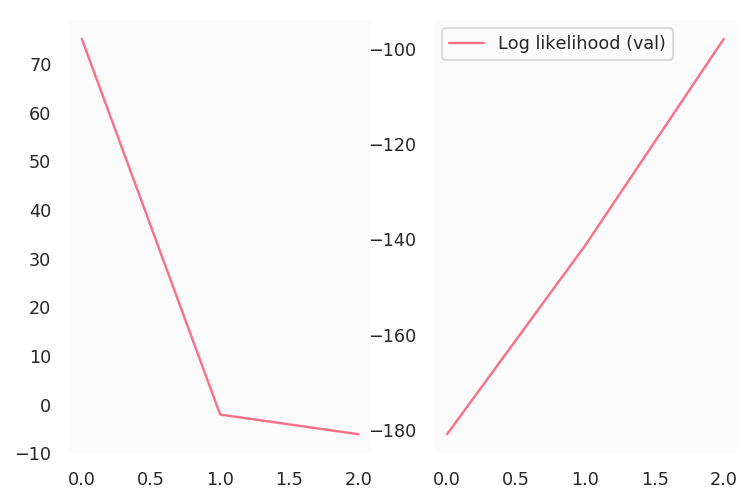

Results with prior: -96.55857
Results with E[prior]: -29.925646
Results with phi: 7.7849116
Results with phi (expected): 10.0448065
****************
Learned params:  1.813449, 1.4514968
Learned std:  0.12687948, 0.3660159
****************
MSE:  (1.078322, 1.0780629)
RMSE: 1.0382981


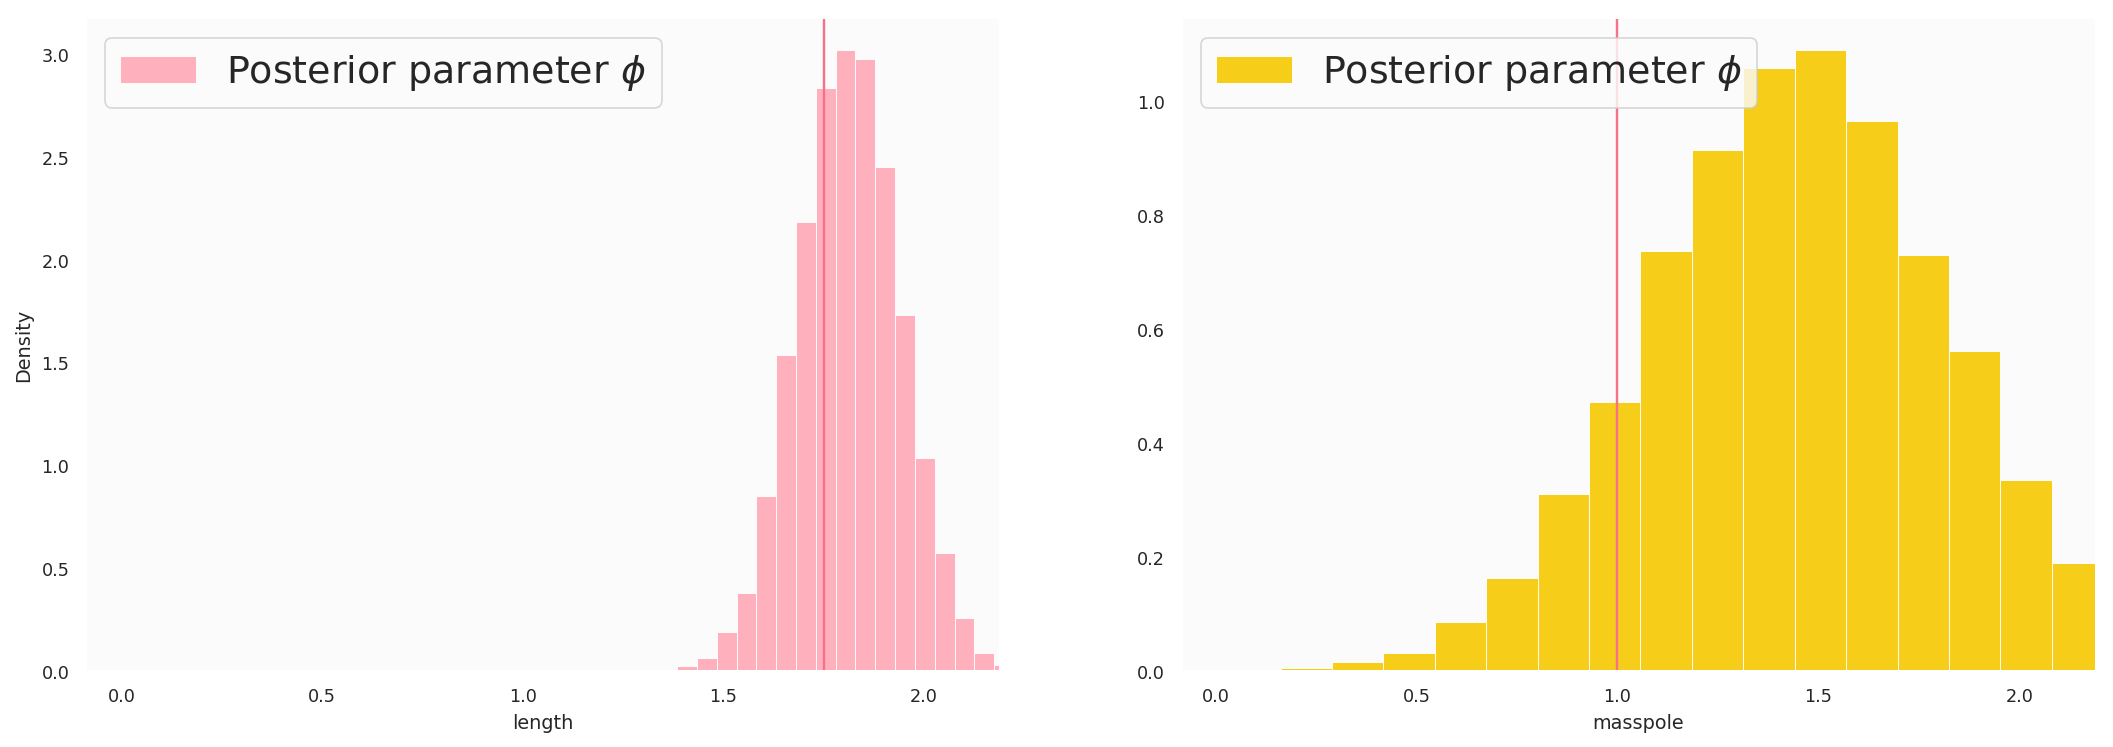

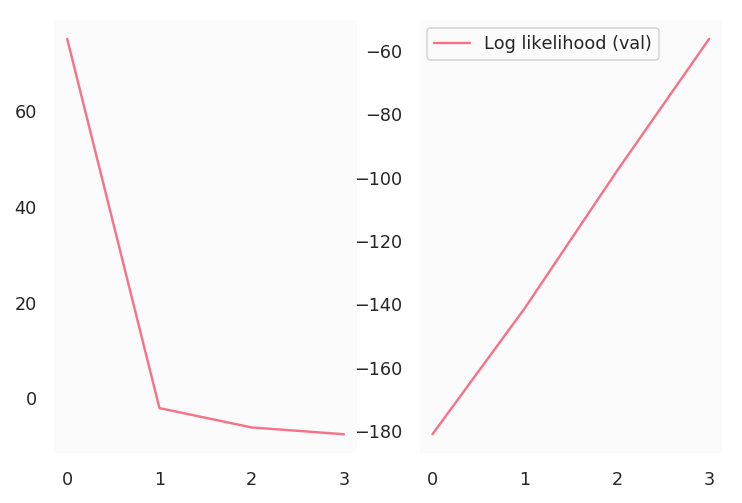

Results with prior: -56.410446
Results with E[prior]: -5.7645435
Results with phi: 8.250881
Results with phi (expected): 10.025438
****************
Learned params:  1.831534, 1.4468224
Learned std:  0.114698514, 0.33928892
****************
MSE:  (1.0780629, 1.0756221)
RMSE: 1.037122


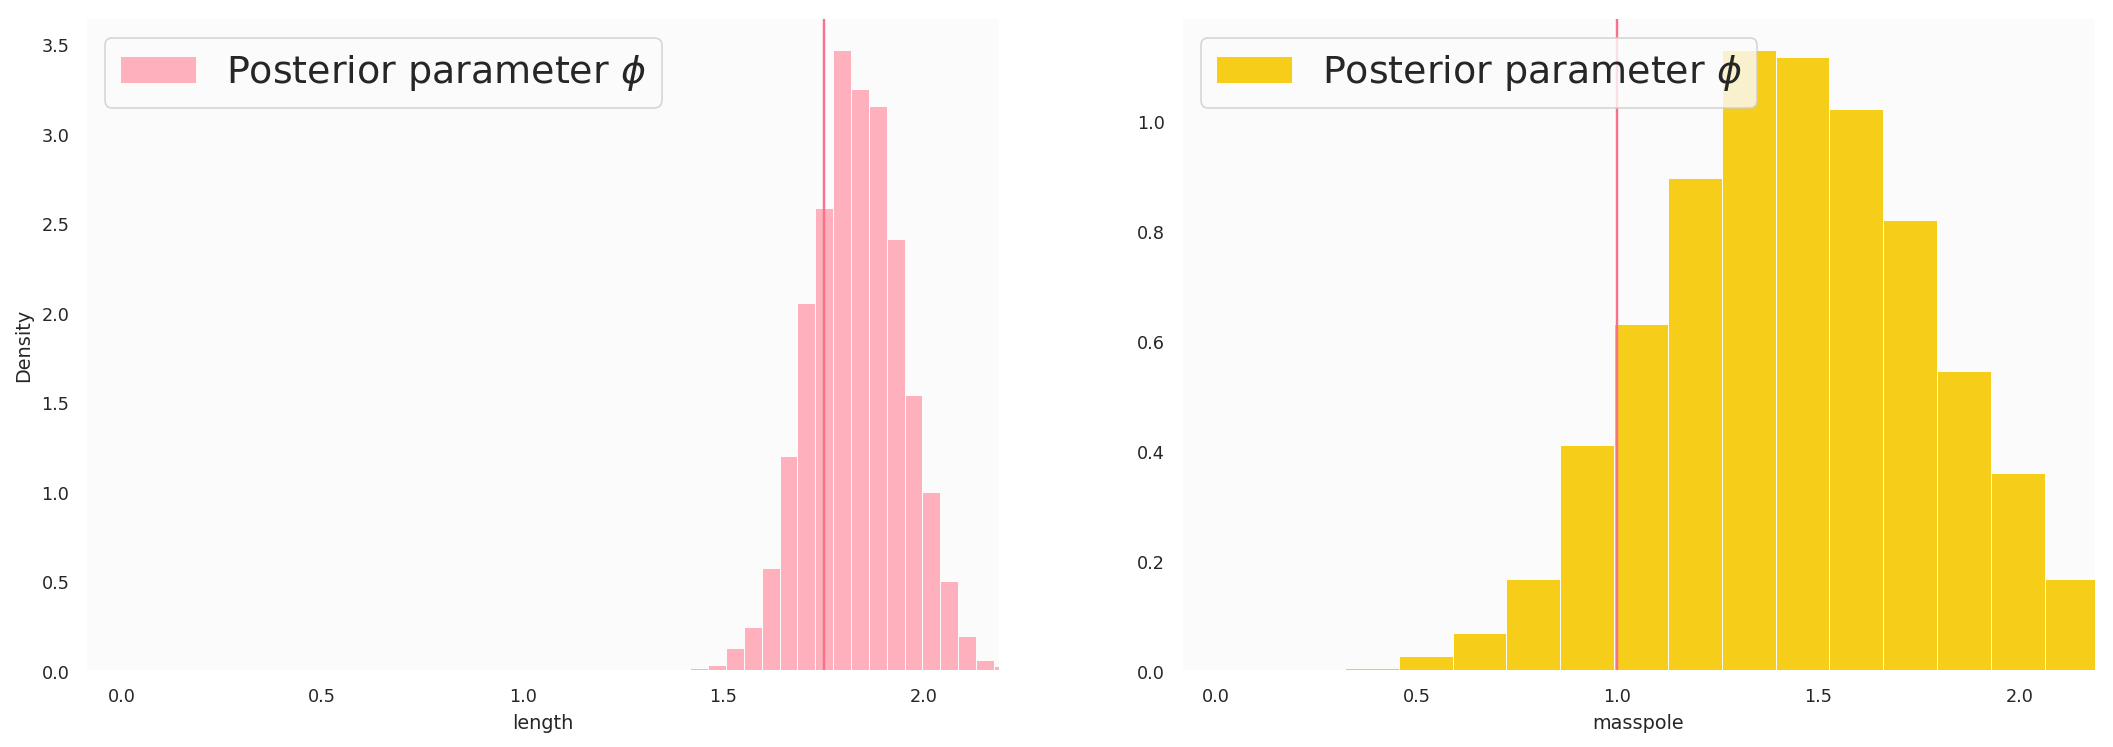

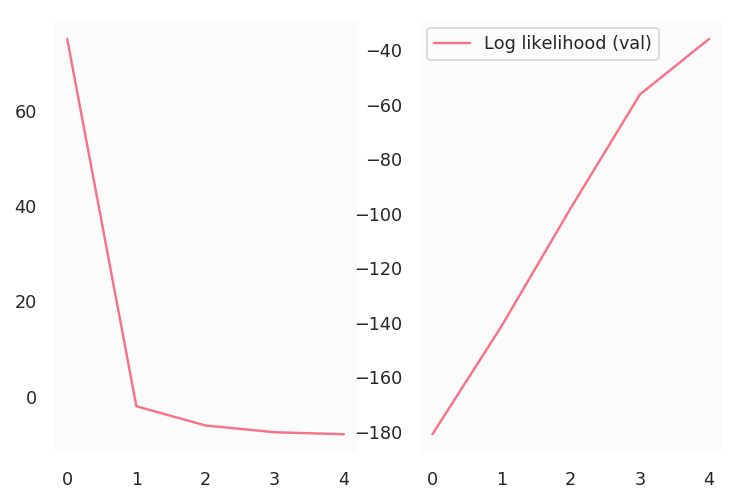

Results with prior: -32.80621
Results with E[prior]: 4.290986
Results with phi: 8.360829
Results with phi (expected): 10.05854
****************
Learned params:  1.7983714, 1.4224814
Learned std:  0.11314555, 0.32548368
****************
MSE:  (1.0756221, 1.0732743)
RMSE: 1.0359895


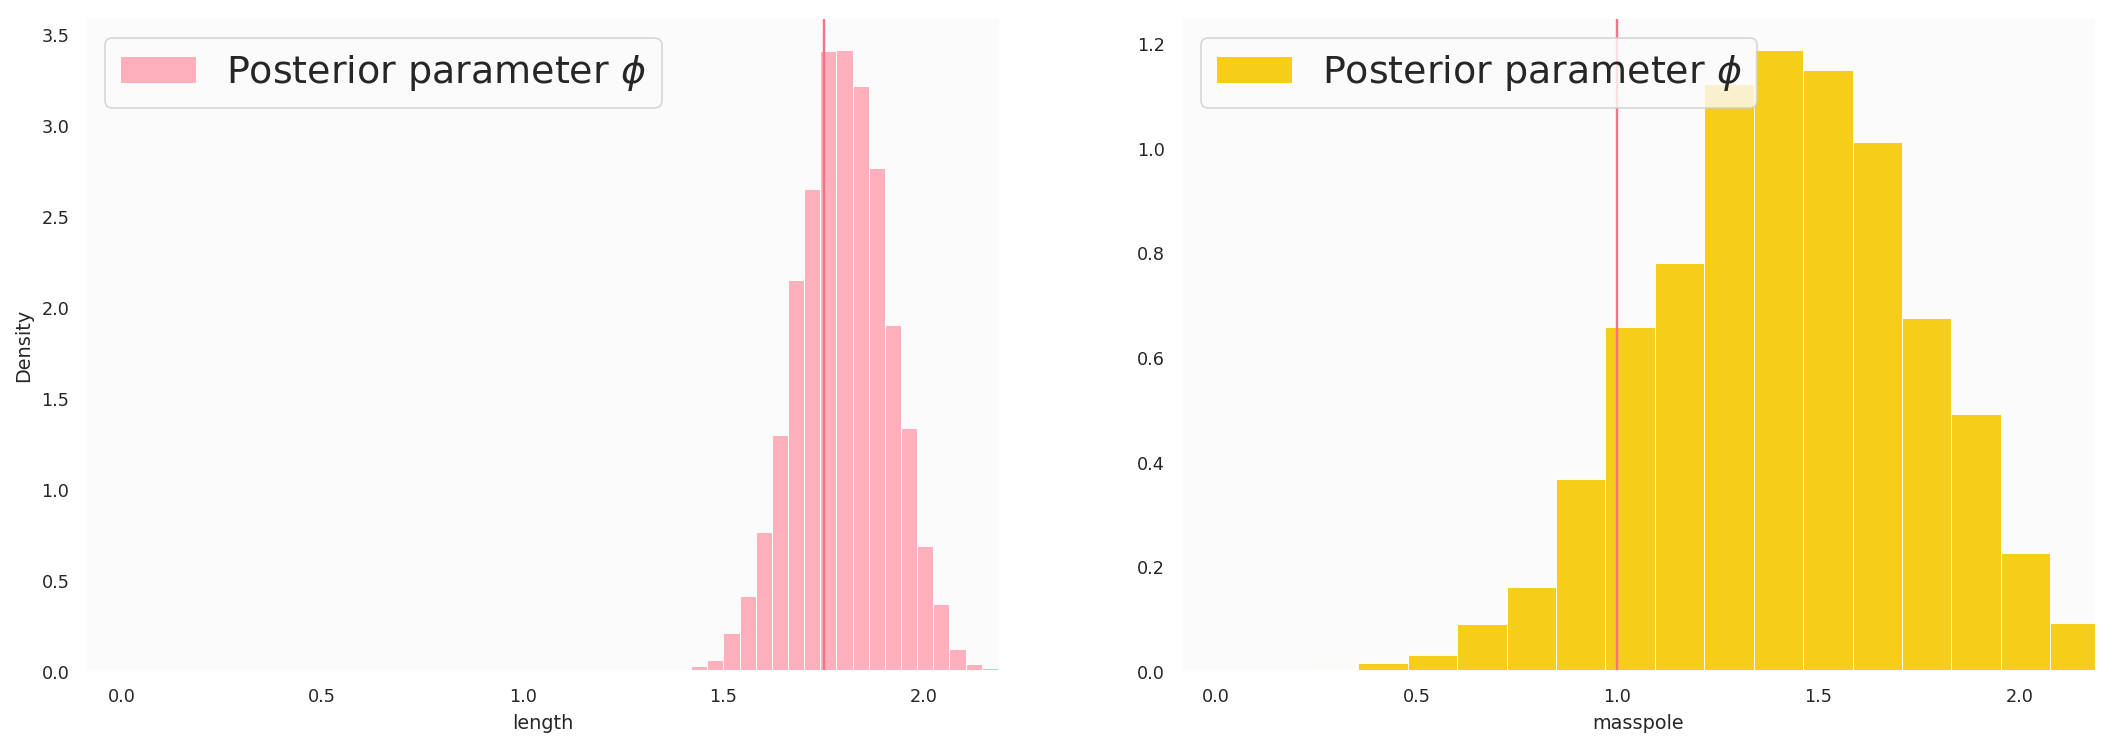

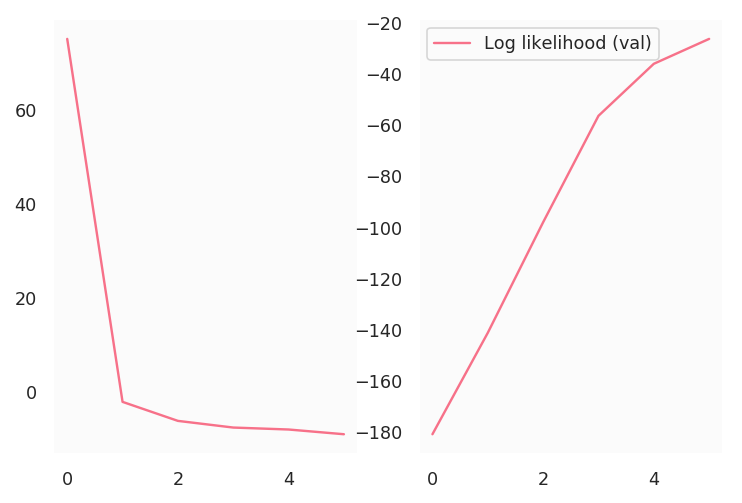

Results with prior: -20.686066
Results with E[prior]: 7.599685
Results with phi: 8.707021
Results with phi (expected): 10.10375
****************
Learned params:  1.8119521, 1.3810014
Learned std:  0.101455845, 0.31203386
****************
MSE:  (1.0732743, 1.0710889)
RMSE: 1.0349343


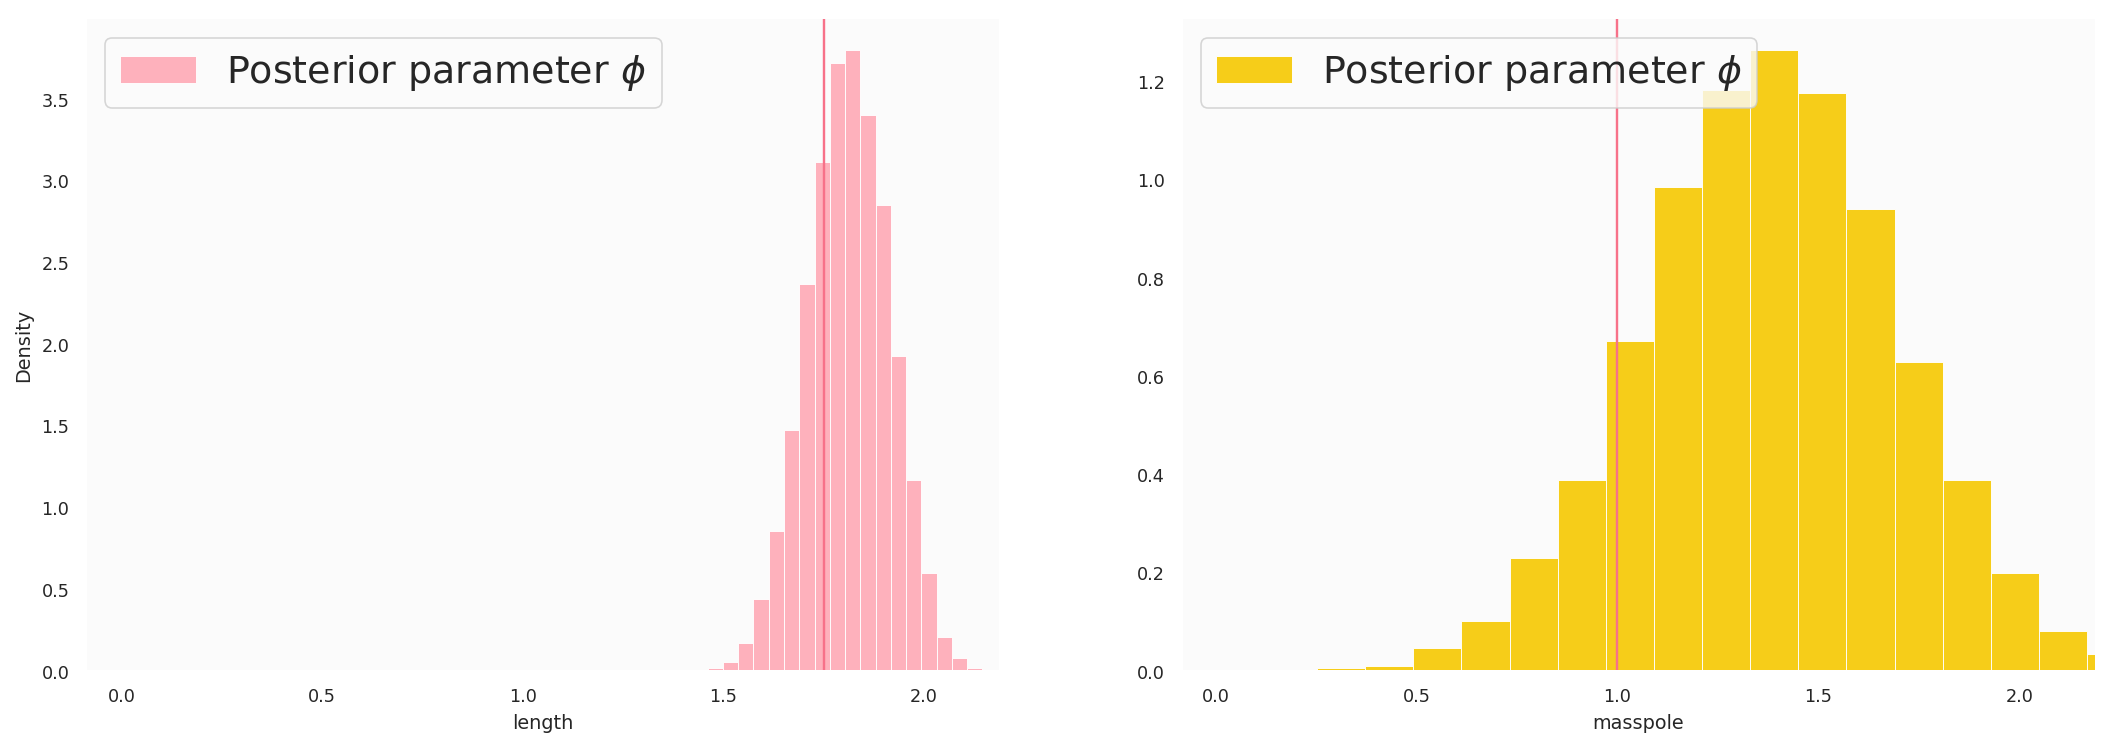

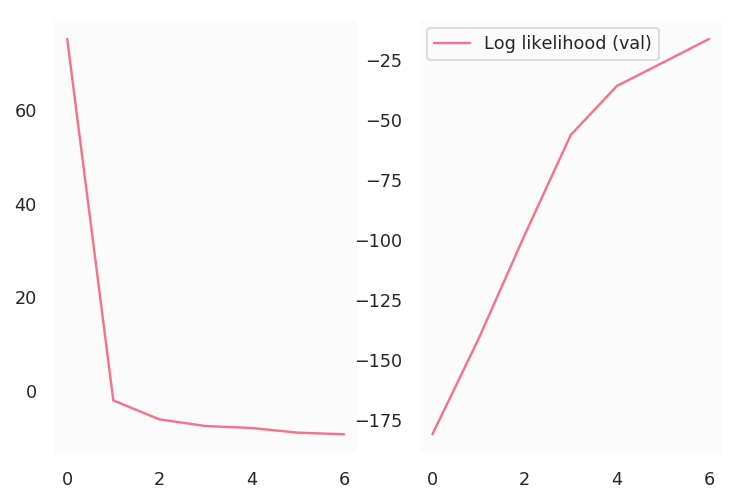

Results with prior: -15.462847
Results with E[prior]: 8.6256075
Results with phi: 8.968164
Results with phi (expected): 10.105478
****************
Learned params:  1.8080946, 1.3587439
Learned std:  0.091425374, 0.29625216
****************
MSE:  (1.0710889, 1.0714825)
RMSE: 1.0351244


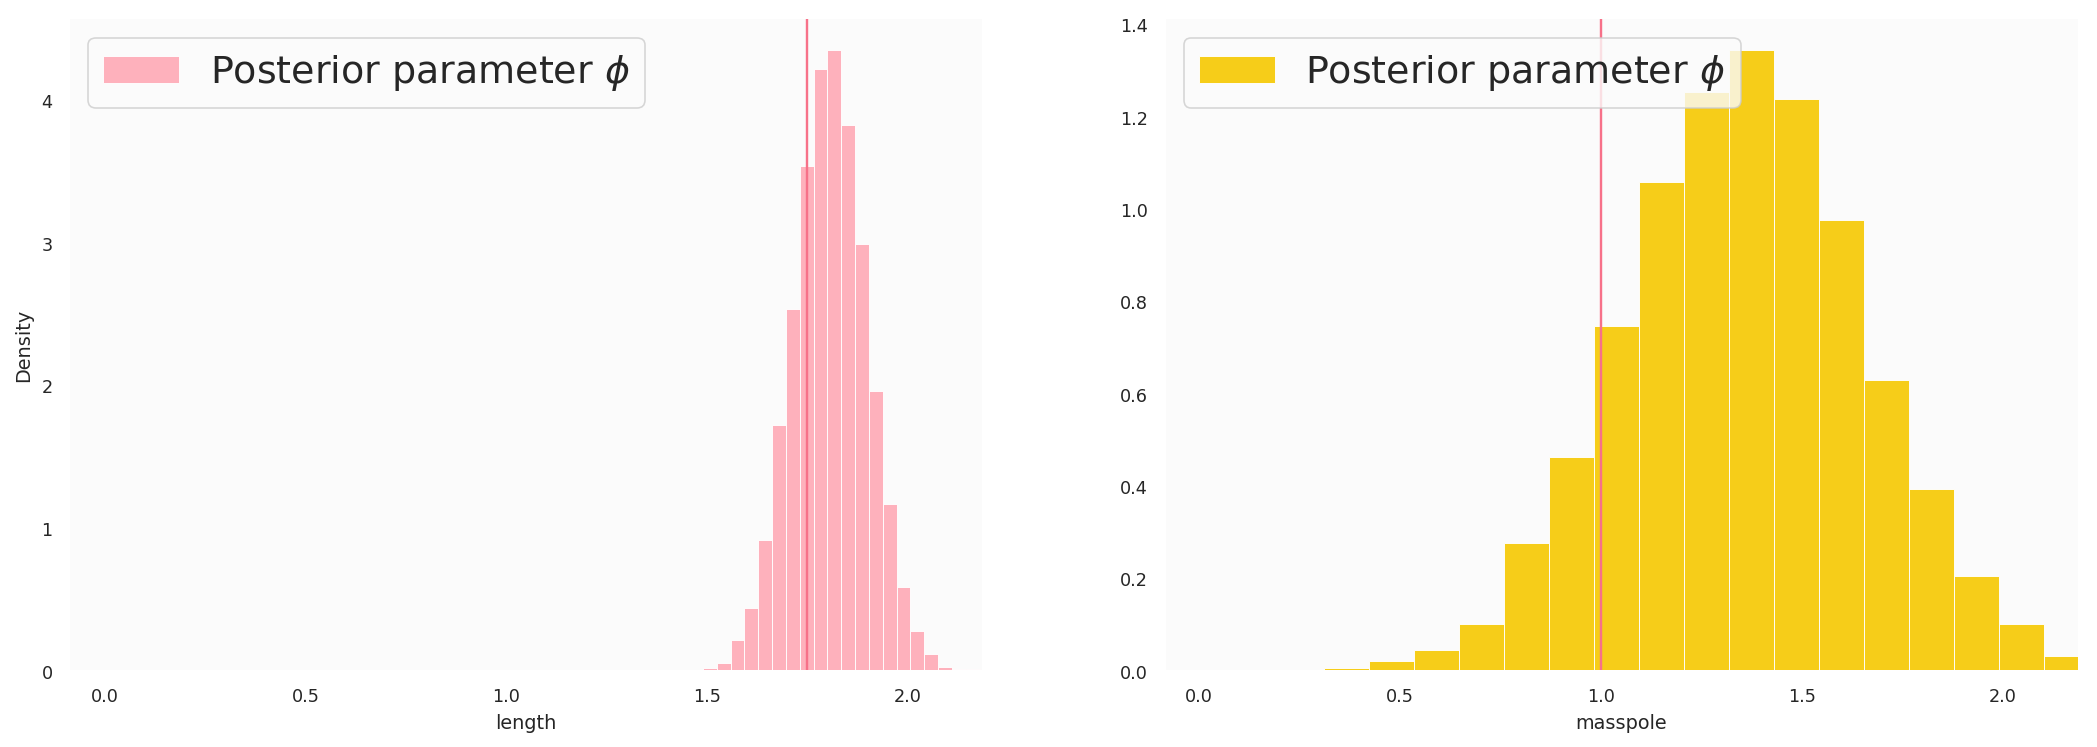

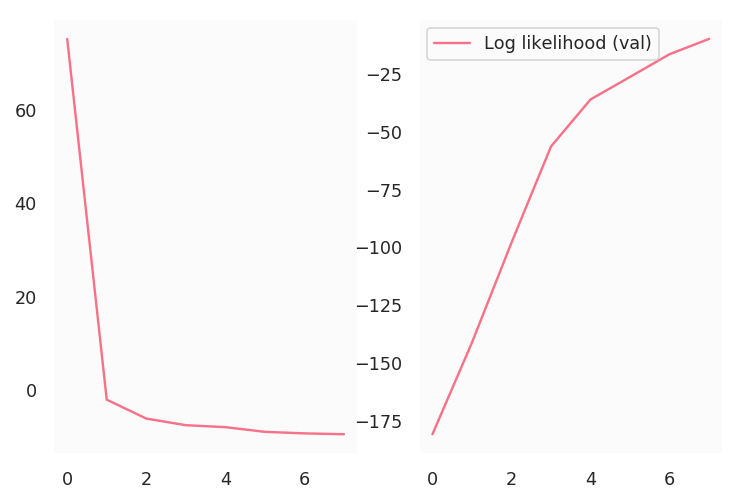

Results with prior: -11.355499
Results with E[prior]: 8.970756
Results with phi: 8.966896
Results with phi (expected): 10.084913
****************
Learned params:  1.797687, 1.3526156
Learned std:  0.09101879, 0.29499084
****************
MSE:  (1.0714825, 1.0728946)
RMSE: 1.0358063


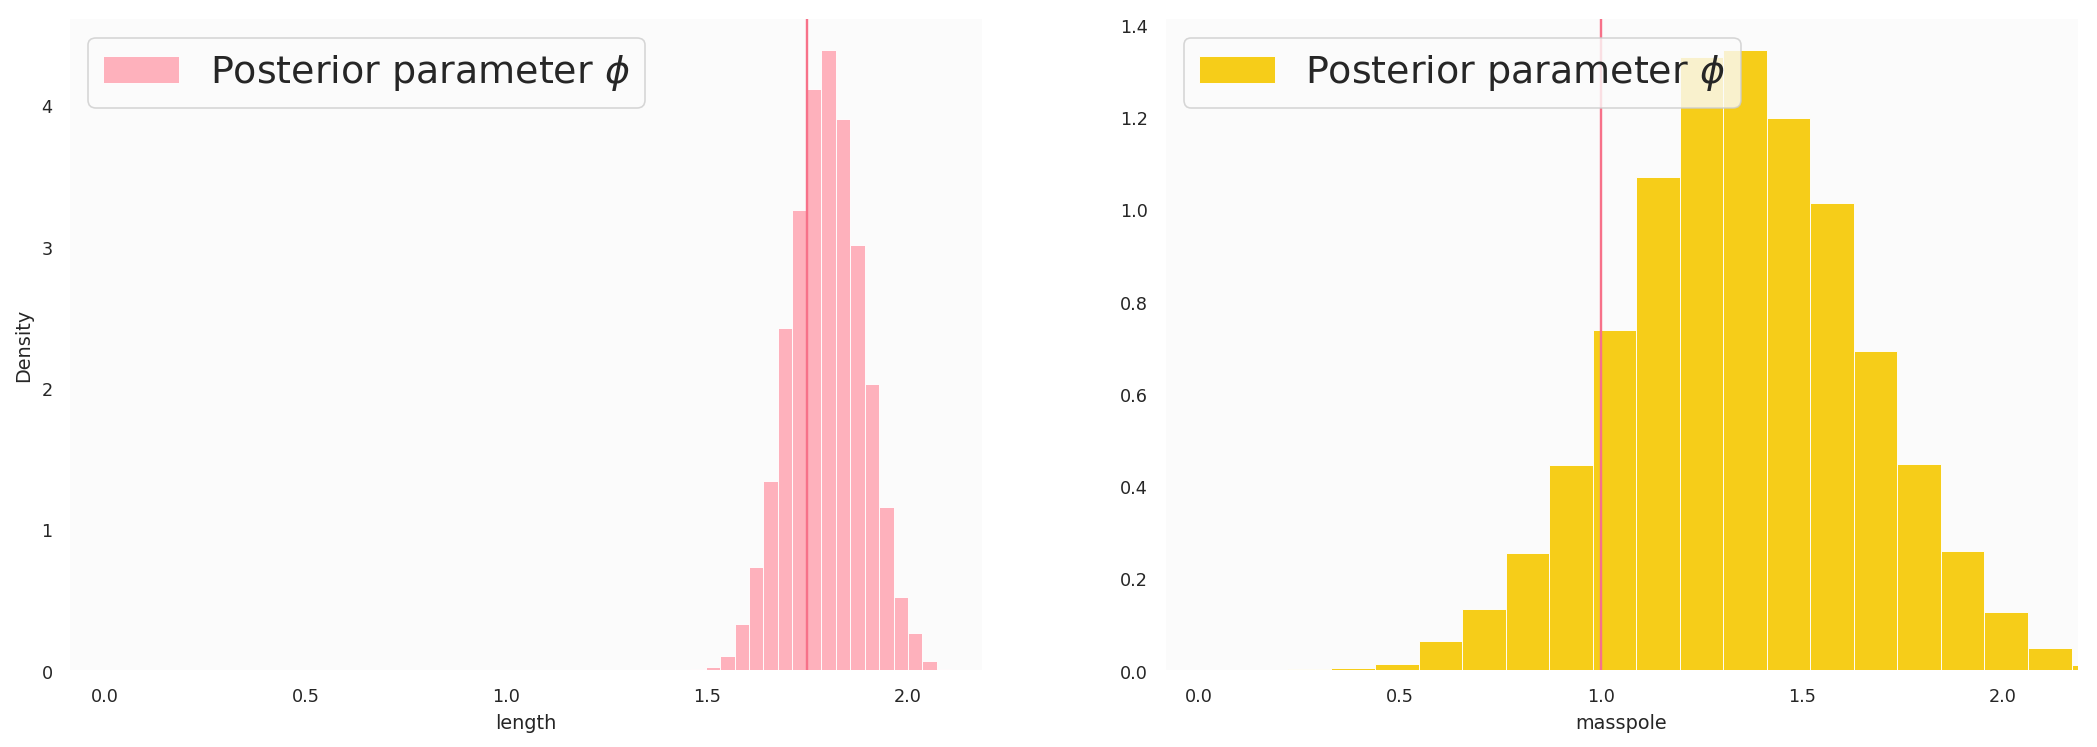

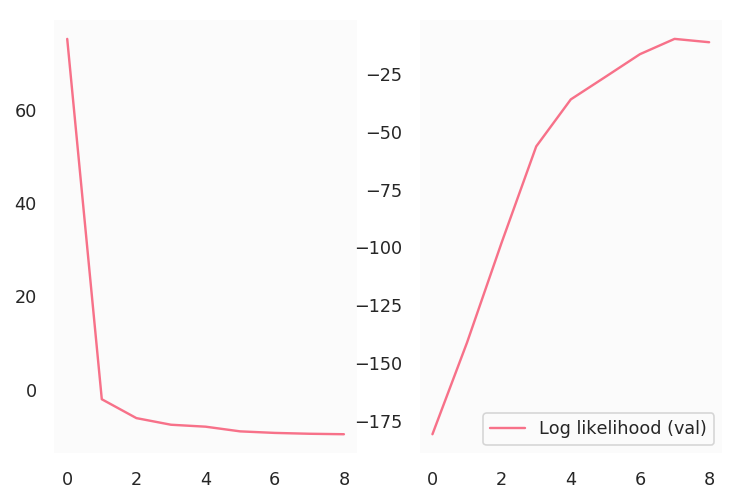

Results with prior: -11.572509
Results with E[prior]: 9.06946
Results with phi: 8.986295
Results with phi (expected): 10.096964
****************
Learned params:  1.8028038, 1.348219
Learned std:  0.09045523, 0.29297698
****************
MSE:  (1.0728946, 1.0729437)
RMSE: 1.0358299


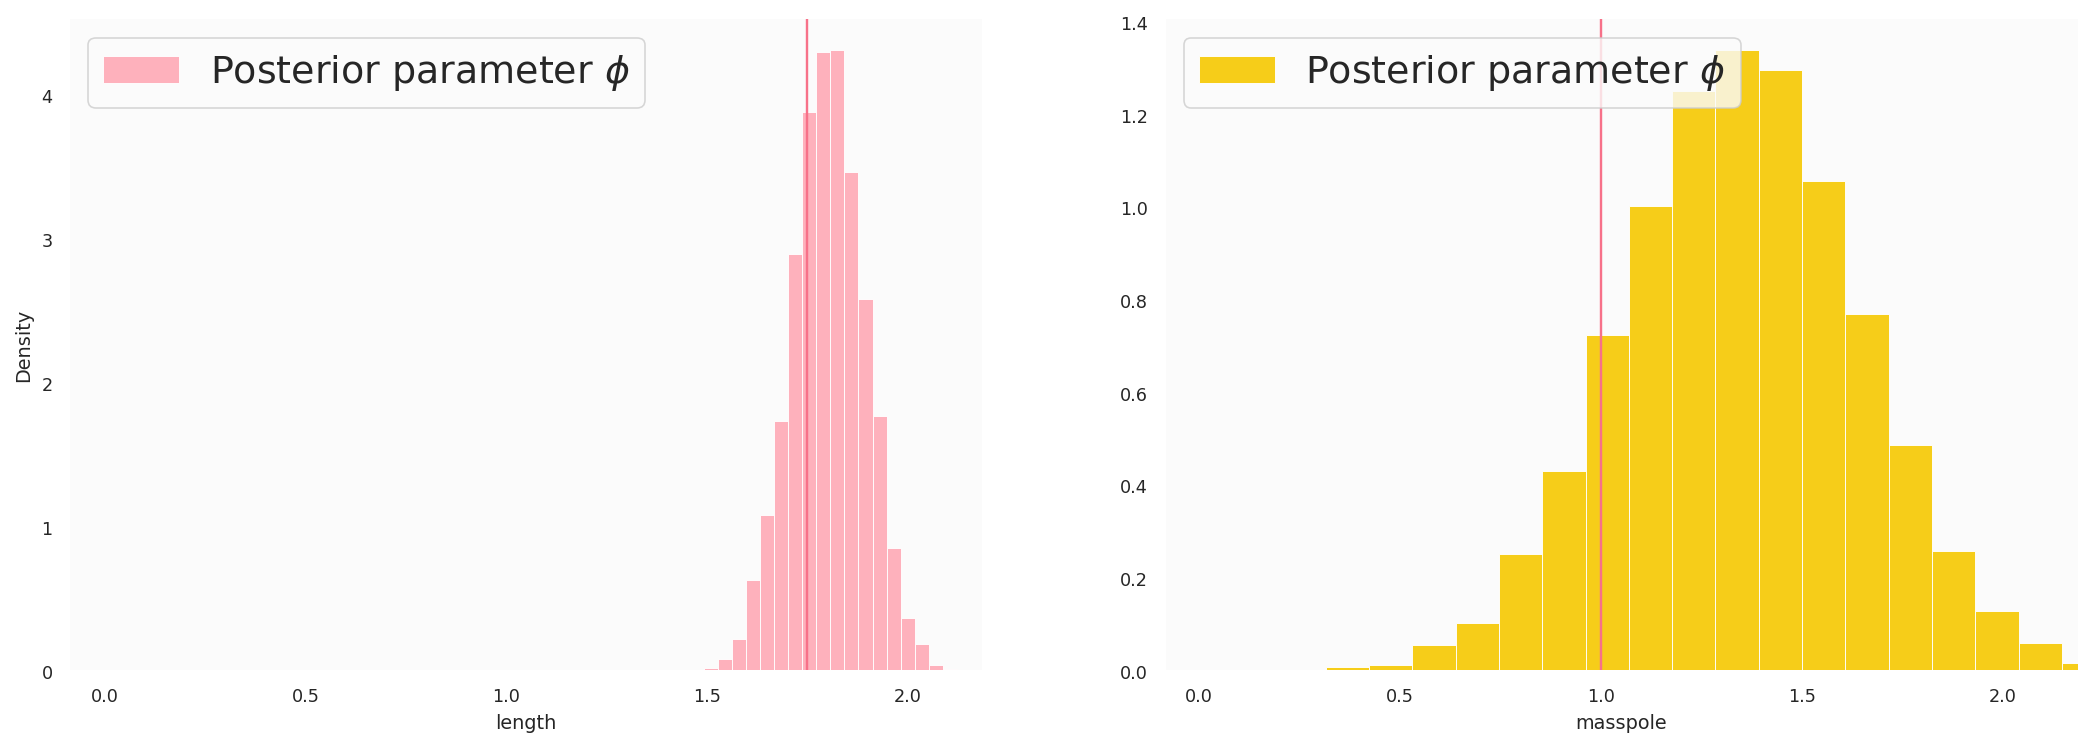

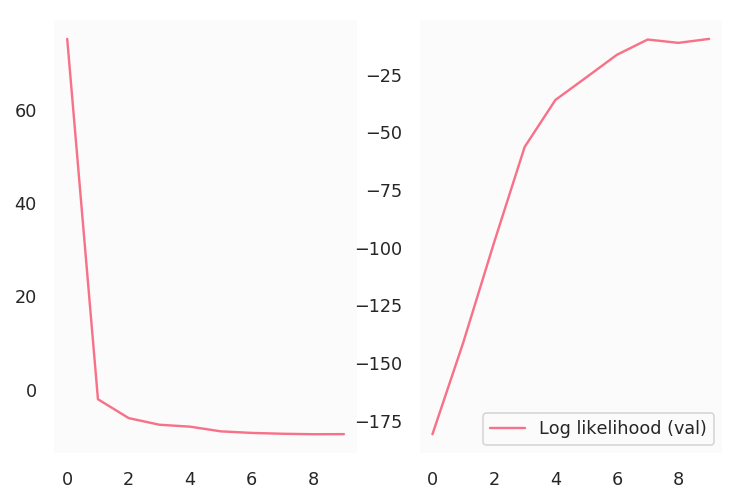

Results with prior: -11.190527
Results with E[prior]: 9.083695
Results with phi: 8.99022
Results with phi (expected): 10.098352
****************
Learned params:  1.8020104, 1.340403
Learned std:  0.08994517, 0.2908876
****************
MSE:  (1.0729437, 1.0728104)
RMSE: 1.0357656


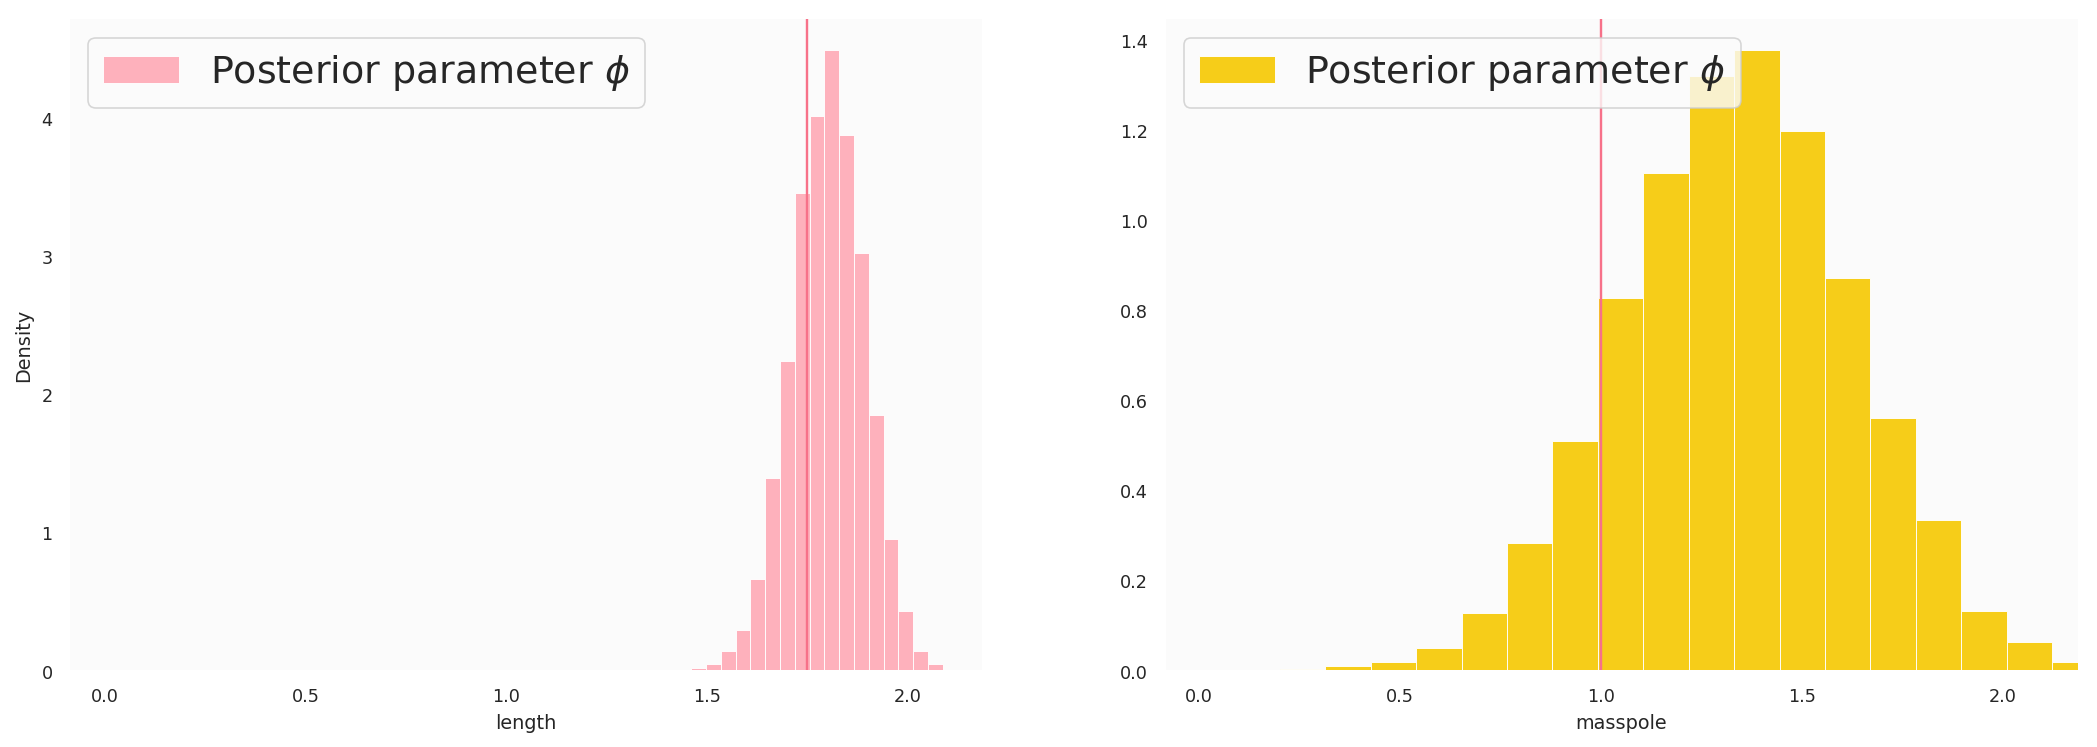

In [31]:
sess.run(real_init_op, {BATCH_SIZE: batch_size_real})
train_cvae(encoder_optimizer, loss, n_epochs_cvae_real, n_batches_real, n_trials, None, cvae_save_fn, plot_step=1)

In [32]:
cvae_restore_fn()

Results with prior: -10.169048
Results with E[prior]: 9.083695
Results with phi: 8.965652
Results with phi (expected): 10.098352
****************
Learned params:  1.8022637, 1.3445189
Learned std:  0.09069065, 0.29263103
****************
MSE:  (1.0728104, 1.0723792)
RMSE: 1.0355575


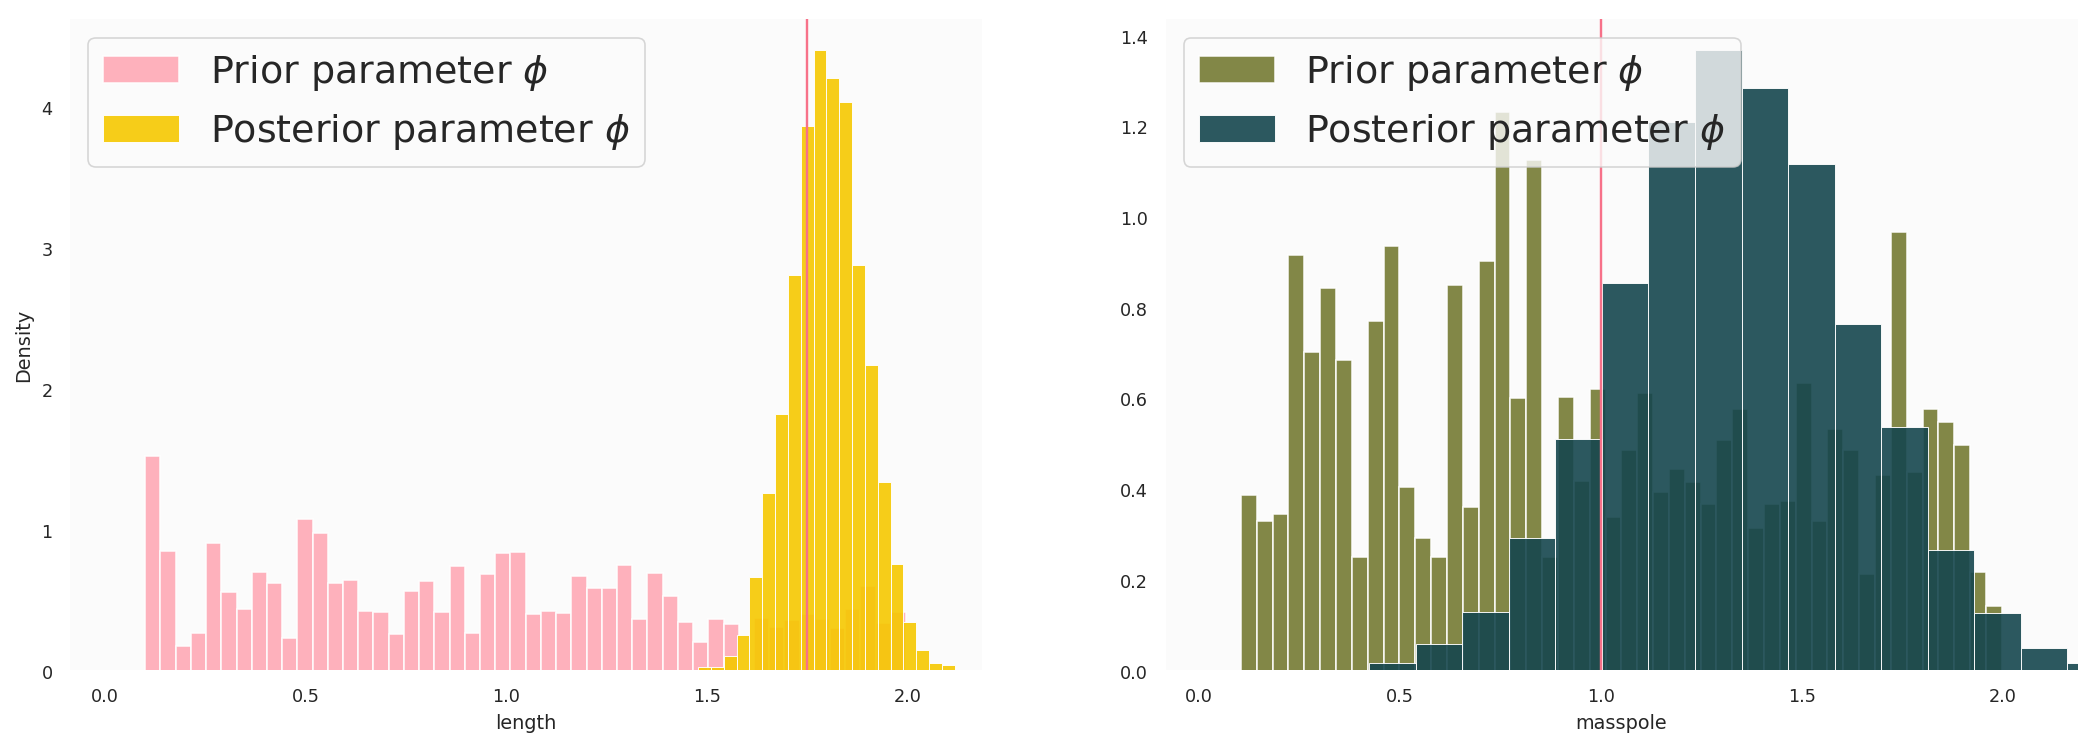

In [33]:
means, stddevs = get_results(plot_orig=True)

In [34]:
means

array([1.8023, 1.3445], dtype=float32)

In [35]:
stddevs

array([0.0907, 0.2926], dtype=float32)

In [36]:
ps = prior.sample(1000)
ps, mean = sess.run([ps, prior.mean()])

# Note that this may be different (probably slightly worse than the posterior)
print('Learned params from prior samples: ', np.mean(denormalize_params(ps), 0))
print('Learned params from prior mean: ', denormalize_params(mean))

Learned params from prior samples:  [1.7059 1.2461]
Learned params from prior mean:  [1.697  1.2636]


# Plot GM

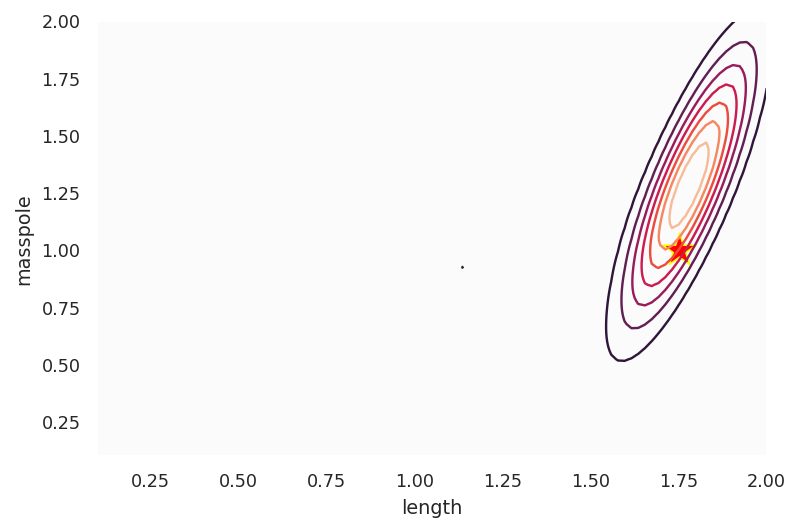

In [37]:
def meshgrid(x, y=None):
    if y is None:
        y = x
    [gx, gy] = np.meshgrid(x, y, indexing='ij')
    gx, gy = np.float32(gx), np.float32(gy)
    grid = np.concatenate([gx.ravel()[None, :], gy.ravel()[None, :]], axis=0)
    return grid.T.reshape(x.size, y.size, 2)

with sess.as_default():
    linspace_x = np.linspace(0.1, 2.0, 100, dtype=np.float32)
    linspace_y = linspace_x
    
    linspace = param_scaler.transform(np.vstack([linspace_x, linspace_y]).T)
    x = linspace[..., 0]
    y = linspace[..., 1]
    grid_normalized = meshgrid(x, y)
    
    grid = meshgrid(linspace_x, linspace_y)
    plt.contour(grid[..., 0], grid[..., 1], prior.prob(grid_normalized).eval());
    
    plt.xlabel(param_names[0])
    plt.ylabel(param_names[1])
    
    x, y = real_params.mean(axis=0)
    plt.scatter(x, y, marker='*', s=300, color='red', edgecolor='yellow')

# Plot each Gaussian

[[ 0.3657 -0.1486]
 [-0.1865 -0.7617]
 [ 1.1289  0.2043]
 [ 0.1796  0.7851]
 [ 1.5665  0.5638]]
[[-0.0843  0.4912  0.2044]
 [ 0.508  -0.348  -0.1639]
 [-0.3955  0.4831  0.5938]
 [ 0.6362 -0.2894  1.5209]
 [-0.4155 -0.583  -0.2138]]
[0.0208 0.0199 0.0269 0.059  0.8734]


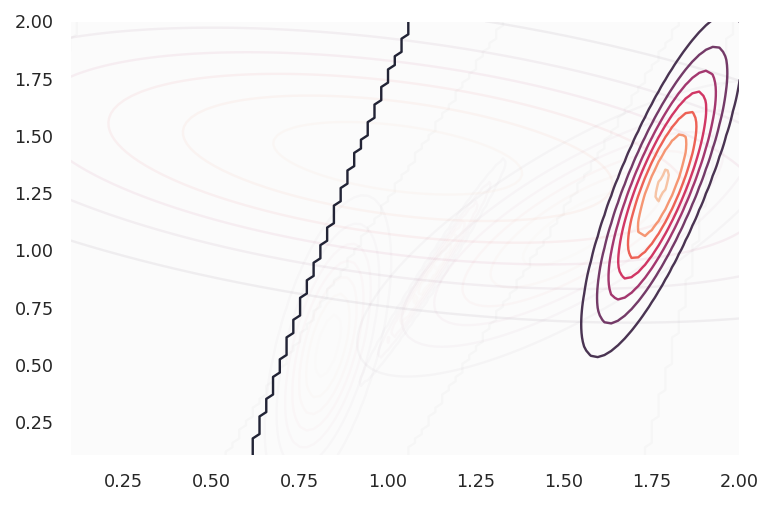

In [38]:
with sess.as_default():
    with tf.variable_scope('prior_weights', reuse=True):
        loc = tf.get_variable('loc').eval()        
        scale = tf.get_variable('raw_scale_diag').eval()
        mixtures = tf.nn.softmax(tf.get_variable('mixture_logits')).eval()
        
        print(loc)
        print(scale)
        print(mixtures)
        
        for i in range(mixture_components):        
            mvn = tfp.MultivariateNormalTriL(loc=loc[i], scale_tril=tfp.fill_triangular(scale[i]))
            
            # Tried to make alpha correspond to the contribution to the mixture but maybe there's a
            # prettier way.
            plt.contour(grid[..., 0], grid[..., 1], mvn.prob(grid_normalized).eval(), alpha=mixtures[i])